# Libraries and loading in the data

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
import time
import matplotlib.dates as mdates
import scipy.stats as ss

# Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

# Imputation
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import entropy
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
import time
from tqdm import tqdm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import periodogram
from scipy.stats import f_oneway
import missingno as msno
from scipy.stats import chi2_contingency
import scipy.stats as stats
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

/opt/anaconda3/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
# Load the data
csv_path = '/Users/aymanelhattache/Desktop/School /UU - ADS/Thesis/Data/TenderNed_data.csv'
df_tenderned = pd.read_csv(csv_path)

/var/folders/gs/nl34jk5j4p78xt66f6906_b80000gn/T/ipykernel_3916/67031740.py:3: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tenderned = pd.read_csv(csv_path)


In [4]:
# List of new date columns
date_columns = [
    'Datum gunning',
    'Sluitingsdatum aanmelding',
    'Sluitingsdatum aanbesteding',
    'Aanvang opdracht',
    'Voltooiing opdracht',
    'Termijn verkrijgen documenten',
    'Verzending uitnodigingen'
]

# Convert date columns to datetime and create additional columns for quarter and year
for col in date_columns:
    # Convert to datetime, coerce errors to NaT
    df_tenderned[col] = pd.to_datetime(df_tenderned[col], format='%d-%m-%Y', errors='coerce')
    df_tenderned[f'{col}_kwartaal'] = df_tenderned[col].dt.to_period('Q')
    df_tenderned[f'{col}_jaar'] = df_tenderned[col].dt.year

# Create a new column order
columns = df_tenderned.columns.tolist()
new_order = []
for col in columns:
    new_order.append(col)
    if col in date_columns:
        new_order.append(f'{col}_kwartaal')
        new_order.append(f'{col}_jaar')

# Remove duplicates by converting to a dictionary and back to a list
new_order = list(dict.fromkeys(new_order))

# Reorder the DataFrame columns
df_tenderned = df_tenderned[new_order]


In [5]:
date_columns = [
    'Publicatiemaand'
]

for col in date_columns:
    df_tenderned[col] = pd.to_datetime(df_tenderned[col], errors='coerce')
    df_tenderned[f'{col}_kwartaal'] = df_tenderned[col].dt.to_period('Q')
    df_tenderned[f'{col}_jaar'] = df_tenderned[col].dt.year # create year and quarter, may be useful later

# make a good voerview of where they are
columns = df_tenderned.columns.tolist()
new_order = []
for col in columns:
    new_order.append(col)
    if col in date_columns:
        new_order.append(f'{col}_kwartaal')
        new_order.append(f'{col}_jaar')

# Remove duplicates by converting to a dictionary and back to a list
new_order = list(dict.fromkeys(new_order))

df_tenderned = df_tenderned[new_order]

In [6]:
# check if all columsn are there in the right order
print(df_tenderned.columns.tolist())

['Id publicatie', 'Tenderned kenmerk', 'Publicatiedatum', 'Publicatiemaand', 'Publicatiemaand_kwartaal', 'Publicatiemaand_jaar', 'Naam Aanbestedende dienst', 'Cleaned name AB', 'Category AD', 'Nationaal identificatienummer', 'Naam aanbesteding', 'URL TenderNed', 'Geimporteerd', 'Tsender', 'Aanbesteding id', 'Sluitingsdatum aanmelding', 'Sluitingsdatum aanmelding_kwartaal', 'Sluitingsdatum aanmelding_jaar', 'Sluitingsdatum aanbesteding', 'Sluitingsdatum aanbesteding_kwartaal', 'Sluitingsdatum aanbesteding_jaar', 'Aanvang opdracht', 'Aanvang opdracht_kwartaal', 'Aanvang opdracht_jaar', 'Voltooiing opdracht', 'Voltooiing opdracht_kwartaal', 'Voltooiing opdracht_jaar', 'Termijn verkrijgen documenten', 'Termijn verkrijgen documenten_kwartaal', 'Termijn verkrijgen documenten_jaar', 'Verzending uitnodigingen', 'Verzending uitnodigingen_kwartaal', 'Verzending uitnodigingen_jaar', 'Tegen betaling documenten verkrijgen', 'Personen aanwezig opening kluis', 'Plaats opening kluis', 'Nationaal of Eu

In [7]:
df_tenderned['Publicatiemaand_kwartaal']

0        2010Q4
1        2010Q4
2        2011Q1
3        2011Q1
4        2011Q1
          ...  
21731    2023Q4
21732    2023Q4
21733    2023Q4
21734    2023Q4
21735    2023Q4
Name: Publicatiemaand_kwartaal, Length: 21736, dtype: period[Q-DEC]

In [8]:
df_tenderned['Cleaned name AB']
# Everything seems okay, a lot of cleaning in Excel so now lets move on

0                      Rijkswaterstaat Zuid Nederland
1                      Rijkswaterstaat Zuid Nederland
2                      Rijkswaterstaat Zuid Nederland
3                      Rijkswaterstaat Zuid Nederland
4                                             ProRail
                             ...                     
21731                               Provincie Utrecht
21732                         Provincie Noord-Holland
21733                               Gemeente Den Haag
21734                                Gemeente Utrecht
21735    Rijkswaterstaat Grote Projecten en Onderhoud
Name: Cleaned name AB, Length: 21736, dtype: object

# Missing data

## Missing data

The columns I will use for my approach are 'Publicatiemaand' and 'Aantal inschrijvingen'

In [9]:
nan_count = df_tenderned['Publicatiemaand'].isna().sum()
print(nan_count)
nan_count = df_tenderned['Aantal inschrijvingen'].isna().sum()
print(nan_count)

0
4621


Focus on the 'Aantal inschrijvingen column, since it contains missing data.

In [10]:
nan_count = df_tenderned['Aantal inschrijvingen'].isna().sum()
total_rows = len(df_tenderned)
percentage_missing = nan_count / total_rows * 100
print(f"Percentage missing: {percentage_missing:.1f}%")

Percentage missing: 21.3%


There is a lot of missing data in this dataset on the column 'Aantal inschrijvingen'. 4,6k, which is in total 21,3% of all rows, which is significant. Here we are going to look at what we should do with it.

## Exploratory

Let's check missing data per month

In [11]:
missing = df_tenderned.groupby('Publicatiemaand')['Aantal inschrijvingen'].apply(lambda x: x.isna().sum()) 
total = df_tenderned.groupby('Publicatiemaand').size()
missing_ratio = missing / total
available = total - missing


missing_month = pd.DataFrame({
    'Publicatiemaand': total.index,
    'All data points': total.values,
    'Available datapoints': available.values,
    'Missing datapoints': missing.values,
    'Missing ratio': missing_ratio.values
})

missing_month = missing_month.sort_values(by='Publicatiemaand', ascending=True) # oldest gets on top
missing_month.head()
# missing_month.to_excel(csv_path, index=False)

Publicatiemaand  All data points  Available datapoints  Missing datapoints  \
0      2010-12-01                2                     2                   0   
1      2011-02-01                2                     2                   0   
2      2011-03-01                2                     1                   1   
3      2011-04-01                2                     2                   0   
4      2011-05-01                1                     1                   0   

   Missing ratio  
0            0.0  
1            0.0  
2            0.5  
3            0.0  
4            0.0

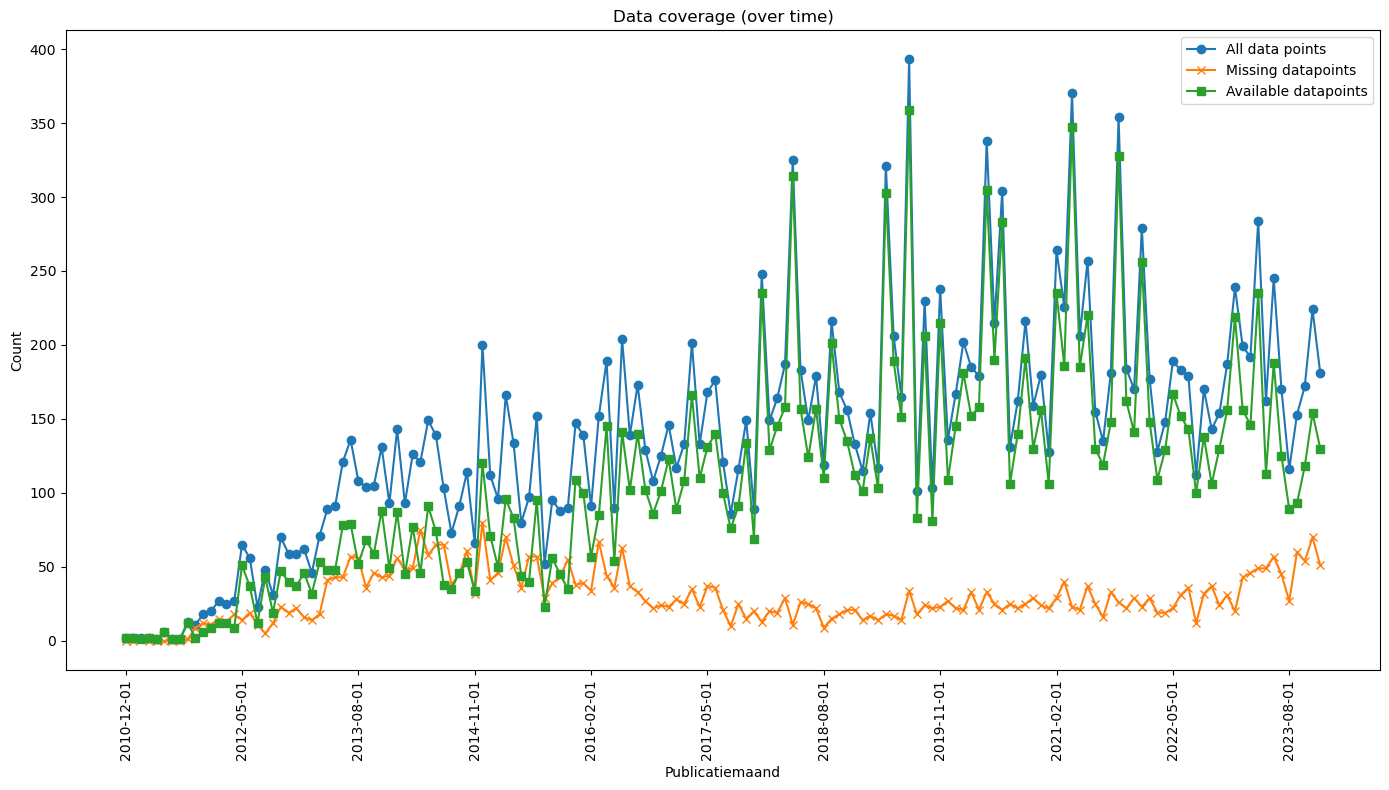

In [12]:
# visualization
plt.figure(figsize=(14, 8))
plt.plot(missing_month['Publicatiemaand'].astype(str), missing_month['All data points'], label='All data points', marker='o')
plt.plot(missing_month['Publicatiemaand'].astype(str), missing_month['Missing datapoints'], label='Missing datapoints', marker='x')
plt.plot(missing_month['Publicatiemaand'].astype(str), missing_month['Available datapoints'], label='Available datapoints', marker='s')
plt.xlabel('Publicatiemaand')
plt.ylabel('Count')
plt.title('Data coverage (over time)')
plt.legend()
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=15))
plt.tight_layout()
plt.show()

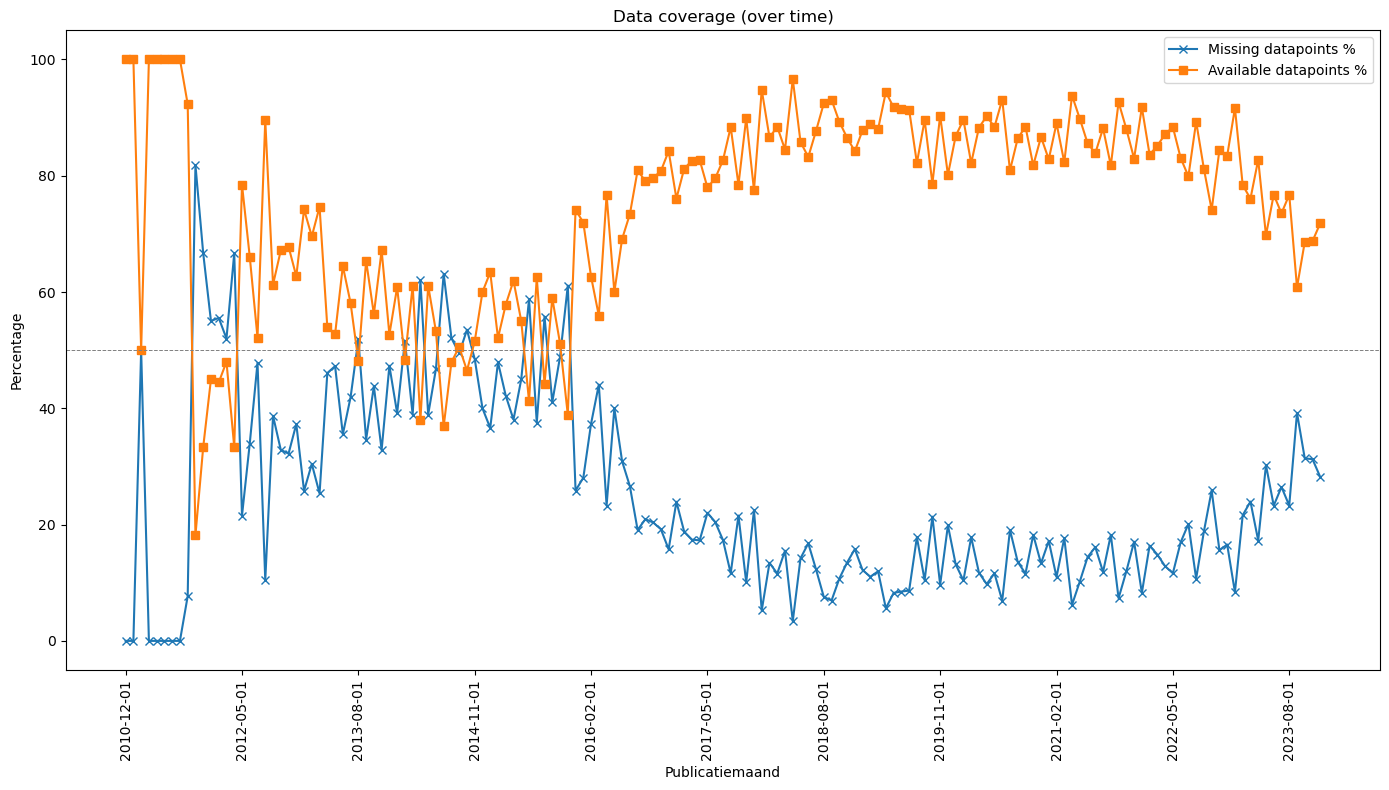

In [13]:
# Calculate the percentages
missing_month['Missing datapoints %'] = (missing_month['Missing datapoints'] / missing_month['All data points']) * 100
missing_month['Available datapoints %'] = (missing_month['Available datapoints'] / missing_month['All data points']) * 100

# Visualization
plt.figure(figsize=(14, 8))
plt.plot(missing_month['Publicatiemaand'].astype(str), missing_month['Missing datapoints %'], label='Missing datapoints %', marker='x')
plt.plot(missing_month['Publicatiemaand'].astype(str), missing_month['Available datapoints %'], label='Available datapoints %', marker='s')
plt.axhline(50, color='gray', linestyle='--', linewidth=0.7)  # Add a gridline at 50%
plt.xlabel('Publicatiemaand')
plt.ylabel('Percentage')
plt.title('Data coverage (over time)')
plt.legend()
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=15))
plt.tight_layout()
plt.show()


There are a lot of missing data points, but it appears that after a certain time (after 2016) the missing data decreases slowly. We will only work with the dataset that has less than 50% missing data.

In [14]:
half = 50
stable = missing_month[missing_month['Available datapoints %'] <= half]
stable = stable.sort_values(by='Publicatiemaand', ascending=False)
stable.head(10)

Publicatiemaand  All data points  Available datapoints  Missing datapoints  \
57      2015-11-01               90                    35                  55   
54      2015-08-01               52                    23                  29   
52      2015-06-01               97                    40                  57   
44      2014-10-01              114                    53                  61   
42      2014-08-01               73                    35                  38   
41      2014-07-01              103                    38                  65   
38      2014-04-01              121                    46                  75   
36      2014-02-01               93                    45                  48   
30      2013-08-01              108                    52                  56   
14      2012-04-01               27                     9                  18   

    Missing ratio  Missing datapoints %  Available datapoints %  
57       0.611111             61.111111               38.888889  
54       0.557692             55.769231               44.230769  
52       0.587629             58.762887               41.237113  
44       0.535088             53.508772               46.491228  
42       0.520548             52.054795               47.945205  
41       0.631068             63.106796               36.893204  
38       0.619835             61.983471               38.016529  
36       0.516129             51.612903               48.387097  
30       0.518519             51.851852               48.148148  
14       0.666667             66.666667               33.333333

from november 2015 onwards, it seems better, also confirmed in the graph

In [15]:
df_tender = df_tenderned[df_tenderned['Publicatiemaand'] >= '2015-12-01'] # take everything after nov 2015
df_tender = df_tender.sort_values(by='Publicatiemaand', ascending=True)

print(df_tender['Publicatiemaand'].unique())
# df_tender.to_excel('filtered_TenderNed_data.xlsx', index=False)

<DatetimeArray>
['2015-12-01 00:00:00', '2016-01-01 00:00:00', '2016-02-01 00:00:00',
 '2016-03-01 00:00:00', '2016-04-01 00:00:00', '2016-05-01 00:00:00',
 '2016-06-01 00:00:00', '2016-07-01 00:00:00', '2016-08-01 00:00:00',
 '2016-09-01 00:00:00', '2016-10-01 00:00:00', '2016-11-01 00:00:00',
 '2016-12-01 00:00:00', '2017-01-01 00:00:00', '2017-02-01 00:00:00',
 '2017-03-01 00:00:00', '2017-04-01 00:00:00', '2017-05-01 00:00:00',
 '2017-06-01 00:00:00', '2017-07-01 00:00:00', '2017-08-01 00:00:00',
 '2017-09-01 00:00:00', '2017-10-01 00:00:00', '2017-11-01 00:00:00',
 '2017-12-01 00:00:00', '2018-01-01 00:00:00', '2018-02-01 00:00:00',
 '2018-03-01 00:00:00', '2018-04-01 00:00:00', '2018-05-01 00:00:00',
 '2018-06-01 00:00:00', '2018-07-01 00:00:00', '2018-08-01 00:00:00',
 '2018-09-01 00:00:00', '2018-10-01 00:00:00', '2018-11-01 00:00:00',
 '2018-12-01 00:00:00', '2019-01-01 00:00:00', '2019-02-01 00:00:00',
 '2019-03-01 00:00:00', '2019-04-01 00:00:00', '2019-05-01 00:00:00',
 '20

In [16]:
df_tender.shape

(17430, 68)

In [17]:
nan_count = df_tender['Aantal inschrijvingen'].isna().sum()
total_rows = len(df_tender)
percentage_missing = nan_count / total_rows * 100
print(f"Percentage missing: {percentage_missing:.1f}%")

Percentage missing: 15.9%


In [18]:
nan_count

2763

Much better already, decrease of more than 5%.

## Removal of unnecessary CPV codes

There are multiple CPV codes which have a 100% missing data case. All the CPV-codes where there is missing data > 50%, i will remove from the dataset, as the imputation will cause more bias than good. Codes that have <50% missing data, i will impute with ML.

In [19]:
total_months = ((2023 - 2015) * 12)
print(f"I need at least {total_months} datapoints for a CPV code to be able to be analyzed")

I need at least 96 datapoints for a CPV code to be able to be analyzed


In [20]:
missing = df_tender.groupby('Hoofd CPV code')['Aantal inschrijvingen'].apply(lambda x: x.isna().sum())
total = df_tender.groupby('Hoofd CPV code').size()
missing_ratio = missing / total
available = total - missing


# Create the DataFrame for 'CPV5'
missing_cpv = pd.DataFrame({
    'Hoofd CPV code': total.index,
    'All data points': total.values,
    'Available datapoints': available.values,
    'Missing datapoints': missing.values,
    'Missing ratio': missing_ratio.values
})

missing_cpv = missing_cpv.sort_values(by='Available datapoints', ascending=True)
missing_cpv
# cpv5_missing_data.to_excel('cpv5_missing_data.xlsx', index=False)

Hoofd CPV code  All data points  Available datapoints  Missing datapoints  \
13             506                2                     2                   0   
6              455                4                     4                   0   
10             503               38                    24                  14   
11             504               77                    63                  14   
12             505              106                    93                  13   
15             508              140                   129                  11   
0              349              147                   137                  10   
14             507              206                   153                  53   
8              501              192                   174                  18   
2              451              292                   214                  78   
9              502              362                   262                 100   
4              453              658                   511                 147   
17             906              541                   515                  26   
5              454              591                   549                  42   
7              500              805                   724                  81   
1              450             2120                  1714                 406   
16             713             3932                  3508                 424   
3              452             7217                  5891                1326   

    Missing ratio  
13       0.000000  
6        0.000000  
10       0.368421  
11       0.181818  
12       0.122642  
15       0.078571  
0        0.068027  
14       0.257282  
8        0.093750  
2        0.267123  
9        0.276243  
4        0.223404  
17       0.048059  
5        0.071066  
7        0.100621  
1        0.191509  
16       0.107833  
3        0.183733

Some only have little datapoints as we can see. As the plan is alter to make an analysis PER CPV code, it is better to remove them since they will not have any benefit.

In [21]:
sufficient_data = missing_cpv[missing_cpv['Available datapoints'] >= 96]  # only with 96 data points or more, the rest will not be sufficient datapooints
CPV_good = sufficient_data['Hoofd CPV code'].tolist()

# Filter the original dataset to include only the selected CPV5 codes
df_tender = df_tender[df_tender['Hoofd CPV code'].isin(CPV_good)]
df_tender['Hoofd CPV code'].unique()

array([452, 500, 450, 502, 454, 508, 713, 451, 453, 507, 906, 501, 349])

We have removed 5 categories due to lack of data

## Split the dataset high and low risk

Since there is still some missing data, I will split the dataset in two sets. One with CPV codes with relatively low percentage of missing data (=< 20%), and one with high. This will help later when making error margins, as with one I can say I am highly confident and with the other I am less confident. Rijkswaterstaat agreed with me on this approach.

In [22]:
merged_df = pd.merge(df_tender, missing_cpv[['Hoofd CPV code', 'Missing ratio']], on='Hoofd CPV code', how='left')  # addition of missing ratio column
merged_df.head() # column is added

Id publicatie  Tenderned kenmerk Publicatiedatum Publicatiemaand  \
0          70403              85845      01-12-2015      2015-12-01   
1          71390              87149      16-12-2015      2015-12-01   
2          71390              87149      16-12-2015      2015-12-01   
3          71390              87149      16-12-2015      2015-12-01   
4          71390              87149      16-12-2015      2015-12-01   

  Publicatiemaand_kwartaal  Publicatiemaand_jaar Naam Aanbestedende dienst  \
0                   2015Q4                  2015        Gemeente Rotterdam   
1                   2015Q4                  2015   Waterschap Vechtstromen   
2                   2015Q4                  2015   Waterschap Vechtstromen   
3                   2015Q4                  2015   Waterschap Vechtstromen   
4                   2015Q4                  2015   Waterschap Vechtstromen   

           Cleaned name AB    Category AD  Nationaal identificatienummer  ...  \
0       Gemeente Rotterdam      Gemeentes                       22071782  ...   
1  Waterschap Vechtstromen  Waterschappen                      331835633  ...   
2  Waterschap Vechtstromen  Waterschappen                      331835633  ...   
3  Waterschap Vechtstromen  Waterschappen                      331835633  ...   
4  Waterschap Vechtstromen  Waterschappen                      331835633  ...   

  Datum gunning Datum gunning_kwartaal Datum gunning_jaar  \
0           NaT                    NaT                NaN   
1    2016-02-23                 2016Q1             2016.0   
2    2016-02-23                 2016Q1             2016.0   
3    2016-02-23                 2016Q1             2016.0   
4    2016-02-23                 2016Q1             2016.0   

  Aantal inschrijvingen  Aantal elektronische inschrijvingen  \
0                   NaN                                  NaN   
1                   0.0                                 16.0   
2                   0.0                                 23.0   
3                   0.0                                 16.0   
4                   0.0                                 16.0   

                       Officiele benaming             Cleaned name winner  \
0                                     NaN                             NaN   
1    Elektrotechnisch bureau Moekotte B.V  elektrotechnischbureaumoekotte   
2                     Roelofs Beheer B.V.                   roelofsbeheer   
3            Jansen Venneboer Advies B.V.           jansenvenneboeradvies   
4  Facta Pomp- en Besturingstechniek B.V.  factapomp-enbesturingstechniek   

                           Winner Kvknummer Missing ratio  
0                             NaN       NaN      0.183733  
1  elektrotechnischbureaumoekotte       NaN      0.100621  
2                         roelofs       NaN      0.100621  
3                 jansenvenneboer       NaN      0.100621  
4                           facta       NaN      0.100621  

[5 rows x 69 columns]

In [23]:
df_lowrisk = merged_df[merged_df['Missing ratio'] <= 0.2] # the splititng
df_highrisk = merged_df[merged_df['Missing ratio'] > 0.2]

unique_values = df_lowrisk['Missing ratio'].unique() # check
print(unique_values)
print(f"Number of rows: {df_lowrisk.shape[0]}")
df_lowrisk.head()

[0.18373285 0.10062112 0.19150943 0.07106599 0.07857143 0.10783316
 0.04805915 0.09375    0.06802721]
Number of rows: 15685


Id publicatie  Tenderned kenmerk Publicatiedatum Publicatiemaand  \
0          70403              85845      01-12-2015      2015-12-01   
1          71390              87149      16-12-2015      2015-12-01   
2          71390              87149      16-12-2015      2015-12-01   
3          71390              87149      16-12-2015      2015-12-01   
4          71390              87149      16-12-2015      2015-12-01   

  Publicatiemaand_kwartaal  Publicatiemaand_jaar Naam Aanbestedende dienst  \
0                   2015Q4                  2015        Gemeente Rotterdam   
1                   2015Q4                  2015   Waterschap Vechtstromen   
2                   2015Q4                  2015   Waterschap Vechtstromen   
3                   2015Q4                  2015   Waterschap Vechtstromen   
4                   2015Q4                  2015   Waterschap Vechtstromen   

           Cleaned name AB    Category AD  Nationaal identificatienummer  ...  \
0       Gemeente Rotterdam      Gemeentes                       22071782  ...   
1  Waterschap Vechtstromen  Waterschappen                      331835633  ...   
2  Waterschap Vechtstromen  Waterschappen                      331835633  ...   
3  Waterschap Vechtstromen  Waterschappen                      331835633  ...   
4  Waterschap Vechtstromen  Waterschappen                      331835633  ...   

  Datum gunning Datum gunning_kwartaal Datum gunning_jaar  \
0           NaT                    NaT                NaN   
1    2016-02-23                 2016Q1             2016.0   
2    2016-02-23                 2016Q1             2016.0   
3    2016-02-23                 2016Q1             2016.0   
4    2016-02-23                 2016Q1             2016.0   

  Aantal inschrijvingen  Aantal elektronische inschrijvingen  \
0                   NaN                                  NaN   
1                   0.0                                 16.0   
2                   0.0                                 23.0   
3                   0.0                                 16.0   
4                   0.0                                 16.0   

                       Officiele benaming             Cleaned name winner  \
0                                     NaN                             NaN   
1    Elektrotechnisch bureau Moekotte B.V  elektrotechnischbureaumoekotte   
2                     Roelofs Beheer B.V.                   roelofsbeheer   
3            Jansen Venneboer Advies B.V.           jansenvenneboeradvies   
4  Facta Pomp- en Besturingstechniek B.V.  factapomp-enbesturingstechniek   

                           Winner Kvknummer Missing ratio  
0                             NaN       NaN      0.183733  
1  elektrotechnischbureaumoekotte       NaN      0.100621  
2                         roelofs       NaN      0.100621  
3                 jansenvenneboer       NaN      0.100621  
4                           facta       NaN      0.100621  

[5 rows x 69 columns]

In [24]:
unique_values = df_highrisk['Missing ratio'].unique()
print(unique_values)
print(f"Number of rows: {df_highrisk.shape[0]}")
df_highrisk.head()

[0.27624309 0.26712329 0.22340426 0.25728155]
Number of rows: 1518


Id publicatie  Tenderned kenmerk Publicatiedatum Publicatiemaand  \
47          71961              85904      23-12-2015      2015-12-01   
59          71554              59815      17-12-2015      2015-12-01   
60          71561              84773      17-12-2015      2015-12-01   
61          71585              87479      17-12-2015      2015-12-01   
63          71616              77343      18-12-2015      2015-12-01   

   Publicatiemaand_kwartaal  Publicatiemaand_jaar  \
47                   2015Q4                  2015   
59                   2015Q4                  2015   
60                   2015Q4                  2015   
61                   2015Q4                  2015   
63                   2015Q4                  2015   

                            Naam Aanbestedende dienst  \
47                                  Provincie Limburg   
59                            Provincie Noord-Brabant   
60  Rijkswaterstaat Programma's Projecten en Onder...   
61                            Provincie Noord-Brabant   
63  Rijkswaterstaat Programma's Projecten en Onder...   

                                      Cleaned name AB      Category AD  \
47                                  Provincie Limburg       Provincies   
59                            Provincie Noord-Brabant       Provincies   
60  Rijkswaterstaat Programma's, Projecten en Onde...  Rijkswaterstaat   
61                            Provincie Noord-Brabant       Provincies   
63  Rijkswaterstaat Programma's, Projecten en Onde...  Rijkswaterstaat   

    Nationaal identificatienummer  ... Datum gunning Datum gunning_kwartaal  \
47                       44667438  ...           NaT                    NaT   
59                      422043498  ...           NaT                    NaT   
60                       82067183  ...           NaT                    NaT   
61                      422043498  ...    2016-06-29                 2016Q2   
63                       82067183  ...           NaT                    NaT   

   Datum gunning_jaar Aantal inschrijvingen  \
47                NaN                   NaN   
59                NaN                   NaN   
60                NaN                   NaN   
61             2016.0                   1.0   
63                NaN                   NaN   

    Aantal elektronische inschrijvingen  \
47                                  NaN   
59                                  NaN   
60                                  NaN   
61                                  1.0   
63                                  NaN   

                                   Officiele benaming  \
47                                                NaN   
59                                                NaN   
60                                                NaN   
61  Geen, de aanbesteding is gestaakt en van de ma...   
63                                                NaN   

                                 Cleaned name winner       Winner Kvknummer  \
47                                               NaN          NaN       NaN   
59                                               NaN          NaN       NaN   
60                                               NaN          NaN       NaN   
61  geen,deaanbestedingisgestaaktenvandemarktgehaald  geenwinnaar       NaN   
63                                               NaN          NaN       NaN   

   Missing ratio  
47      0.276243  
59      0.276243  
60      0.267123  
61      0.276243  
63      0.223404  

[5 rows x 69 columns]

Everything seems to have went well.

## Impute missing data

I want to impute the missing data, based on a ML model. That is what I am going to do here.

In [25]:
# df_lowrisk.to_csv('df_lowrisk.csv', index=False )

In [26]:
print(df_lowrisk.columns)

Index(['Id publicatie', 'Tenderned kenmerk', 'Publicatiedatum',
       'Publicatiemaand', 'Publicatiemaand_kwartaal', 'Publicatiemaand_jaar',
       'Naam Aanbestedende dienst', 'Cleaned name AB', 'Category AD',
       'Nationaal identificatienummer', 'Naam aanbesteding', 'URL TenderNed',
       'Geimporteerd', 'Tsender', 'Aanbesteding id',
       'Sluitingsdatum aanmelding', 'Sluitingsdatum aanmelding_kwartaal',
       'Sluitingsdatum aanmelding_jaar', 'Sluitingsdatum aanbesteding',
       'Sluitingsdatum aanbesteding_kwartaal',
       'Sluitingsdatum aanbesteding_jaar', 'Aanvang opdracht',
       'Aanvang opdracht_kwartaal', 'Aanvang opdracht_jaar',
       'Voltooiing opdracht', 'Voltooiing opdracht_kwartaal',
       'Voltooiing opdracht_jaar', 'Termijn verkrijgen documenten',
       'Termijn verkrijgen documenten_kwartaal',
       'Termijn verkrijgen documenten_jaar', 'Verzending uitnodigingen',
       'Verzending uitnodigingen_kwartaal', 'Verzending uitnodigingen_jaar',
       'Teg

In [27]:
nominal_columns = [
    'Publicatiemaand', 'Publicatiemaand_kwartaal', 
    'Sluitingsdatum aanbesteding_kwartaal', 'Aanvang opdracht_kwartaal', 
    'Voltooiing opdracht_kwartaal', 'Termijn verkrijgen documenten_kwartaal', 
    'Cleaned name AB', 'Category AD', 'Sluitingsdatum aanbesteding', 
    'Aanvang opdracht', 'Voltooiing opdracht', 'Termijn verkrijgen documenten', 
    'Verzending uitnodigingen', 'Tegen betaling documenten verkrijgen', 
    'Personen aanwezig opening kluis', 'Nationaal of Europees', 
    'Publicatie soort', 'Juridisch kader', 'Type opdracht', 
    'Procedure', 'Hoofd CPV code', 'Opdracht categorie', 
    'Nutscode', 'Aard van de opdracht', 'GPA', 'Hoofdactiviteit', 
    'Hoofdgunningscriterium'
]


Here are all the columns I want to use for the ML model. 

### Type of missing data

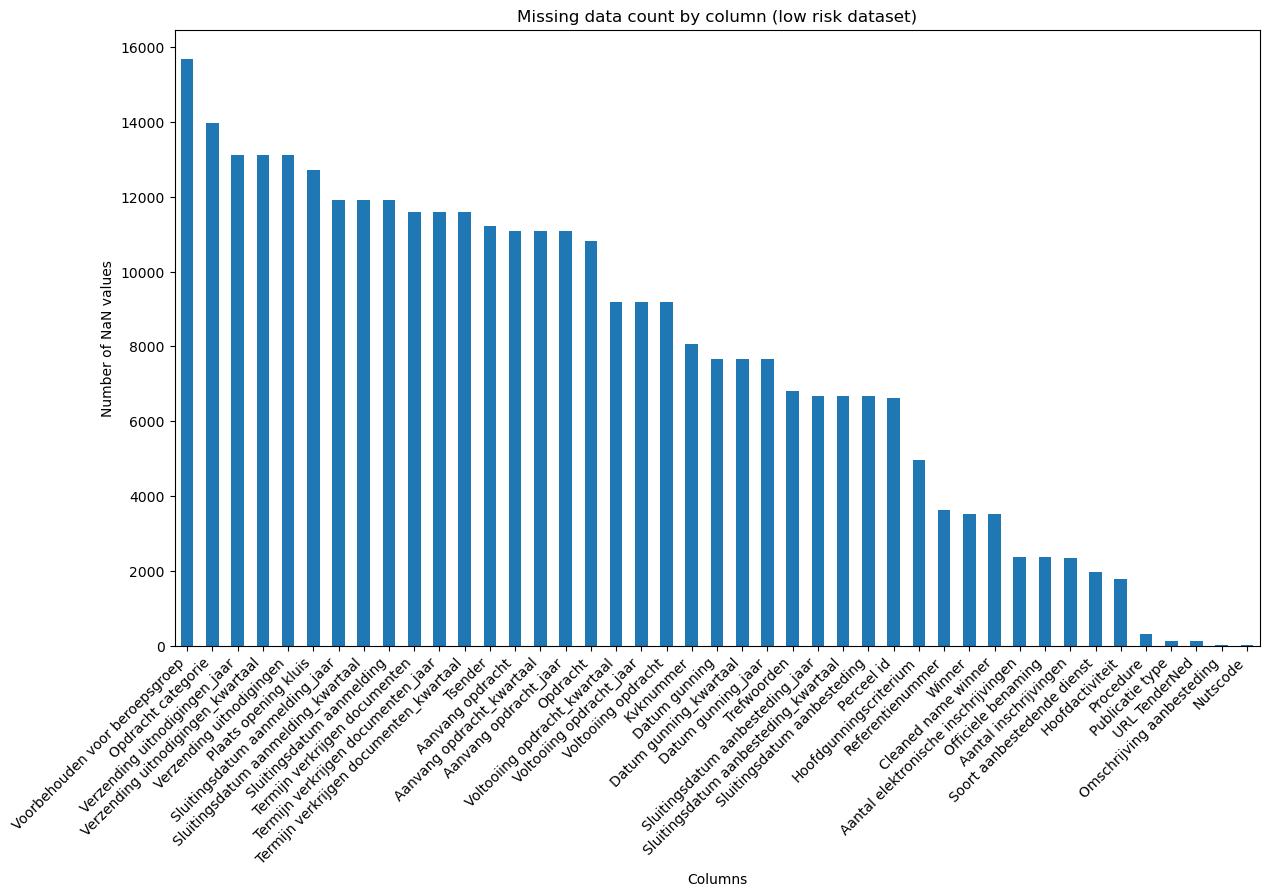

In [28]:
missing_data_summary = df_lowrisk.isnull().sum().sort_values(ascending=False)
missing_data_percentage = (df_lowrisk.isnull().sum() / len(df_lowrisk)) * 100
missing_data_summary = missing_data_summary[missing_data_summary > 0]

plt.figure(figsize=(14, 8))
missing_data_summary.plot(kind='bar')
plt.title('Missing data count by column (low risk dataset)')
plt.xlabel('Columns')
plt.ylabel('Number of NaN values')
plt.xticks(rotation=45, ha='right')  # Rotate column names for better readability
plt.show()

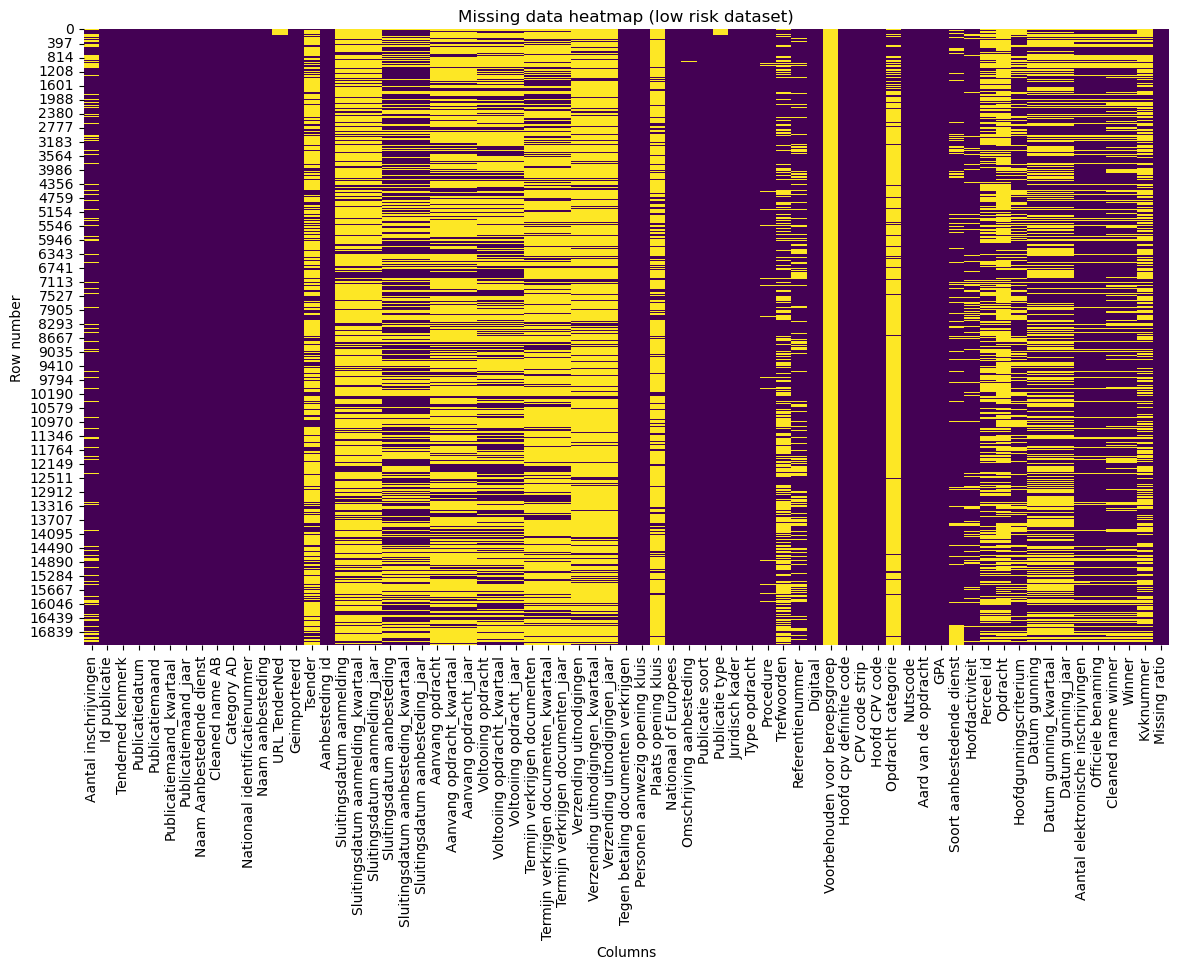

In [29]:
focus_columns = ['Aantal inschrijvingen'] + [col for col in df_lowrisk.columns if col != 'Aantal inschrijvingen']
df_focus = df_lowrisk[focus_columns]

plt.figure(figsize=(14, 8))
sns.heatmap(df_focus.isnull(), cbar=False, cmap='viridis')
plt.title('Missing data heatmap (low risk dataset)')
plt.xlabel('Columns')
plt.ylabel('Row number')
plt.show()

In [30]:
missing_aantal_inschrijvingen = df_focus['Aantal inschrijvingen'].isnull()
correlation_with_missing = df_focus.isnull().corrwith(missing_aantal_inschrijvingen) # correlation calculation

# Sort and display the correlation results
correlation_with_missing_sorted = correlation_with_missing.sort_values(ascending=False) #highest on top
correlation_with_missing_sorted = correlation_with_missing_sorted[correlation_with_missing_sorted > 0 ]
correlation_with_missing_sorted

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Aantal inschrijvingen                     1.000000
Officiele benaming                        0.992790
Aantal elektronische inschrijvingen       0.991314
Winner                                    0.778809
Cleaned name winner                       0.778809
Perceel id                                0.490629
Datum gunning_jaar                        0.429638
Datum gunning_kwartaal                    0.429638
Datum gunning                             0.429638
Kvknummer                                 0.407488
Opdracht                                  0.281320
Hoofdgunningscriterium                    0.215622
Procedure                                 0.189537
Plaats opening kluis                      0.170408
Voltooiing opdracht                       0.115627
Voltooiing opdracht_kwartaal              0.115627
Voltooiing opdracht_jaar                  0.115627
Sluitingsdatum aanbesteding               0.098406
Sluitingsdatum aanbesteding_kwartaal      0.098406
Sluitingsdatum aanbesteding_jaa

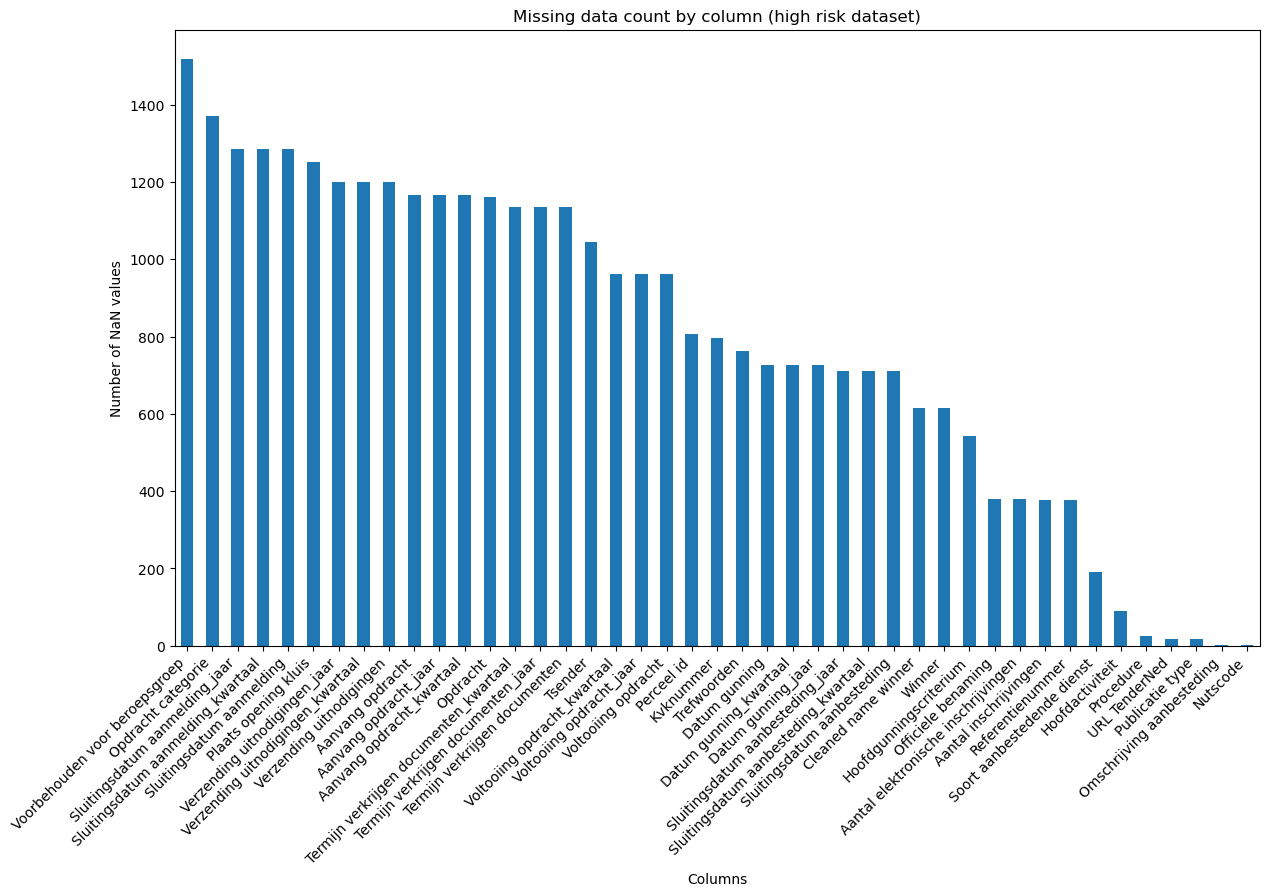

In [31]:
missing_data_summary = df_highrisk.isnull().sum().sort_values(ascending=False)
missing_data_percentage = (df_highrisk.isnull().sum() / len(df_highrisk)) * 100
missing_data_summary = missing_data_summary[missing_data_summary > 0]

plt.figure(figsize=(14, 8))
missing_data_summary.plot(kind='bar')
plt.title('Missing data count by column (high risk dataset)')
plt.xlabel('Columns')
plt.ylabel('Number of NaN values')
plt.xticks(rotation=45, ha='right')  # Rotate column names for better readability
plt.show()

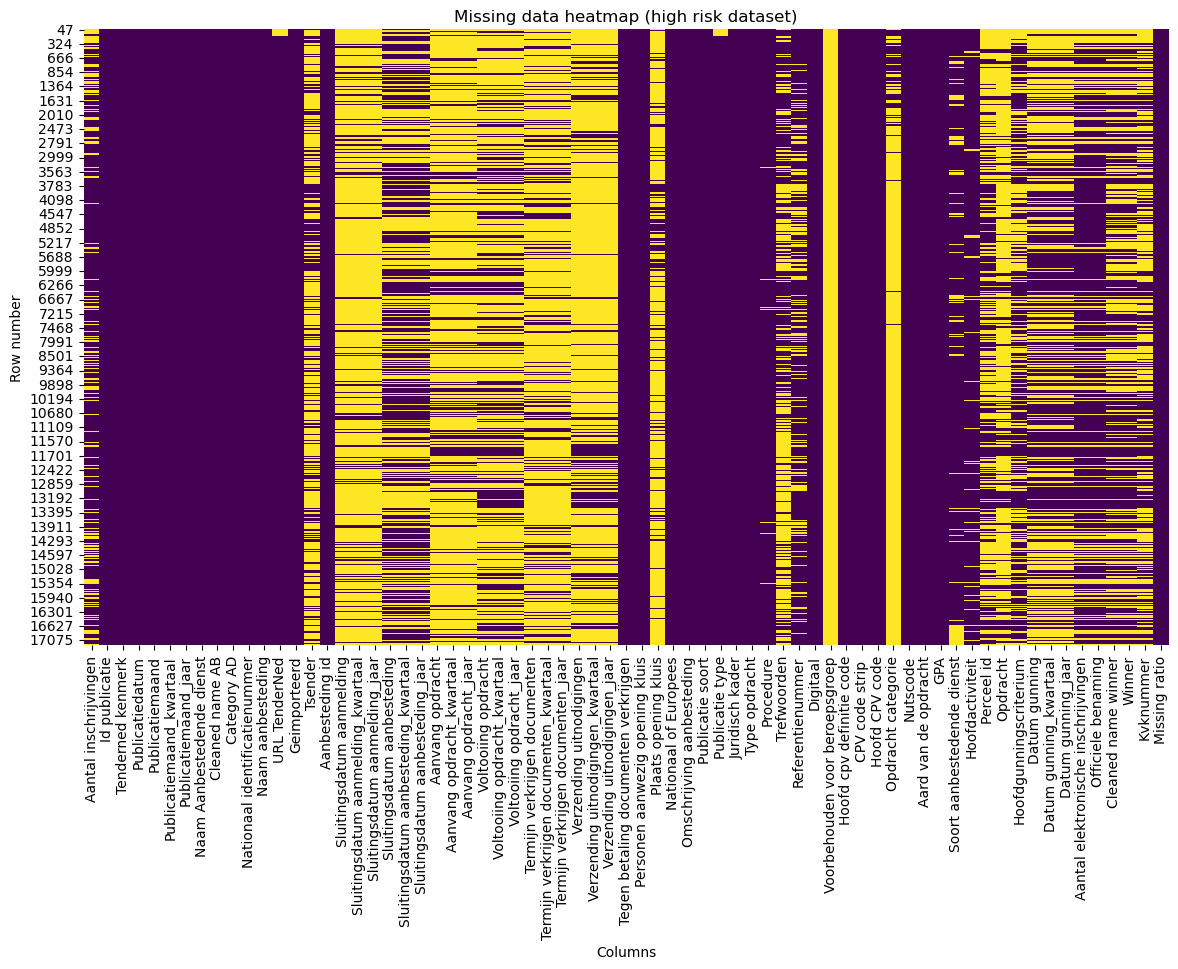

In [32]:
focus_columns = ['Aantal inschrijvingen'] + [col for col in df_lowrisk.columns if col != 'Aantal inschrijvingen']
df_focus = df_highrisk[focus_columns]

plt.figure(figsize=(14, 8))
sns.heatmap(df_focus.isnull(), cbar=False, cmap='viridis')
plt.title('Missing data heatmap (high risk dataset)')
plt.xlabel('Columns')
plt.ylabel('Row number')
plt.show()

In [33]:
missing_aantal_inschrijvingen = df_focus['Aantal inschrijvingen'].isnull()
correlation_with_missing = df_focus.isnull().corrwith(missing_aantal_inschrijvingen) # correlation calculation

# Sort and display the correlation results
correlation_with_missing_sorted = correlation_with_missing.sort_values(ascending=False) #highest on top
correlation_with_missing_sorted = correlation_with_missing_sorted[correlation_with_missing_sorted > 0 ]
correlation_with_missing_sorted

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Aantal inschrijvingen                     1.000000
Officiele benaming                        0.996490
Aantal elektronische inschrijvingen       0.996490
Winner                                    0.696797
Cleaned name winner                       0.696797
Datum gunning                             0.600640
Datum gunning_jaar                        0.600640
Datum gunning_kwartaal                    0.600640
Kvknummer                                 0.548410
Perceel id                                0.540495
Opdracht                                  0.319894
Hoofdgunningscriterium                    0.224969
Procedure                                 0.220109
Plaats opening kluis                      0.209320
Voltooiing opdracht                       0.184098
Voltooiing opdracht_kwartaal              0.184098
Voltooiing opdracht_jaar                  0.184098
Verzending uitnodigingen                  0.165406
Verzending uitnodigingen_kwartaal         0.165406
Verzending uitnodigingen_jaar  

### Low risk

Create a new DF with only the relevant columns (the training and the target one). I try to write the code as general as possibl, so I can just copy it for the high risk after this.

In [34]:
Q1 = df_lowrisk['Aantal inschrijvingen'].quantile(0.25)
Q3 = df_lowrisk['Aantal inschrijvingen'].quantile(0.75)
IQR = Q3 - Q1

# bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with NaN
df_lowrisk['Aantal inschrijvingen'] = df_lowrisk['Aantal inschrijvingen'].apply(
    lambda x: x if lower_bound <= x <= upper_bound else np.nan
)

print(df_lowrisk['Aantal inschrijvingen'].describe())

count    12308.000000
mean         6.371222
std          4.380060
min          0.000000
25%          3.000000
50%          5.000000
75%          9.000000
max         20.000000
Name: Aantal inschrijvingen, dtype: float64


/var/folders/gs/nl34jk5j4p78xt66f6906_b80000gn/T/ipykernel_3916/1186319283.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowrisk['Aantal inschrijvingen'] = df_lowrisk['Aantal inschrijvingen'].apply(


In [35]:
df = df_lowrisk.loc[:, nominal_columns]
df['Aantal inschrijvingen'] = df_lowrisk.loc[:, 'Aantal inschrijvingen']

In [36]:
data_types = df.dtypes
grouped_by_dtype = {dtype: list(data_types[data_types == dtype].index) for dtype in data_types.unique()} # useful to know what datatypes, for the ML model later

for dtype, columns in grouped_by_dtype.items():
    print(f"{dtype}: {columns}")

datetime64[ns]: ['Publicatiemaand', 'Sluitingsdatum aanbesteding', 'Aanvang opdracht', 'Voltooiing opdracht', 'Termijn verkrijgen documenten', 'Verzending uitnodigingen']
period[Q-DEC]: ['Publicatiemaand_kwartaal', 'Sluitingsdatum aanbesteding_kwartaal', 'Aanvang opdracht_kwartaal', 'Voltooiing opdracht_kwartaal', 'Termijn verkrijgen documenten_kwartaal']
object: ['Cleaned name AB', 'Category AD', 'Tegen betaling documenten verkrijgen', 'Personen aanwezig opening kluis', 'Nationaal of Europees', 'Publicatie soort', 'Juridisch kader', 'Type opdracht', 'Procedure', 'Opdracht categorie', 'Nutscode', 'Aard van de opdracht', 'GPA', 'Hoofdactiviteit', 'Hoofdgunningscriterium']
int64: ['Hoofd CPV code']
float64: ['Aantal inschrijvingen']


Because we have many different data types, we need to make them numerical as this helps for ML model.

In [37]:
# Updated datetime columns
datetime_cols = [
    'Publicatiemaand', 'Sluitingsdatum aanbesteding', 
    'Aanvang opdracht', 'Voltooiing opdracht', 
    'Termijn verkrijgen documenten'
]

for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], format='%d-%m-%Y', errors='coerce')
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df.drop(columns=col, inplace=True)

# Updated period columns
period_cols = [
    'Publicatiemaand_kwartaal', 'Sluitingsdatum aanbesteding_kwartaal', 
    'Aanvang opdracht_kwartaal', 'Voltooiing opdracht_kwartaal', 
    'Termijn verkrijgen documenten_kwartaal'
]
placeholder_period = '1900Q1'

for col in period_cols:
    df[col] = df[col].fillna(placeholder_period).astype(str)
    df[col + '_year'] = df[col].str[:4].astype(int)
    df[col + '_quarter'] = df[col].str[5:].astype(int)
    df.drop(columns=col, inplace=True)

# Updated categorical columns
categorical_cols = [
    'Cleaned name AB', 'Category AD', 'Verzending uitnodigingen', 
    'Tegen betaling documenten verkrijgen', 'Personen aanwezig opening kluis', 
    'Nationaal of Europees', 'Publicatie soort', 'Juridisch kader', 
    'Type opdracht', 'Procedure', 'Opdracht categorie', 
    'Nutscode', 'Aard van de opdracht', 'GPA', 'Hoofdactiviteit', 
    'Hoofdgunningscriterium', 'Hoofd CPV code'
]

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols)) # one hot encoding

df.drop(columns=categorical_cols, inplace=True)
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [38]:
# check if the transition was succesful
data_types = df.dtypes
grouped_by_dtype = {dtype: list(data_types[data_types == dtype].index) for dtype in data_types.unique()}

# Display the grouped columns by data type
for dtype, columns in grouped_by_dtype.items():
    print(f"{dtype}: {columns}")

float64: ['Aantal inschrijvingen', 'Sluitingsdatum aanbesteding_year', 'Sluitingsdatum aanbesteding_month', 'Sluitingsdatum aanbesteding_day', 'Aanvang opdracht_year', 'Aanvang opdracht_month', 'Aanvang opdracht_day', 'Voltooiing opdracht_year', 'Voltooiing opdracht_month', 'Voltooiing opdracht_day', 'Termijn verkrijgen documenten_year', 'Termijn verkrijgen documenten_month', 'Termijn verkrijgen documenten_day', 'Cleaned name AB_Avri', 'Cleaned name AB_Blink GRR', 'Cleaned name AB_Gemeenschappelijke Regeling Omgevingsdienst Midden- en West-Brabant', 'Cleaned name AB_Gemeenschappelijke Regeling Omgevingsdienst Regio Utrecht', 'Cleaned name AB_Gemeenschappelijke regeling Veiligheidsregio Brabant-Noord, onderdeel Brandweer', 'Cleaned name AB_Gemeente Amsterdam', 'Cleaned name AB_Gemeente Amsterdam, stadsdeel West,', 'Cleaned name AB_Gemeente Den Haag', 'Cleaned name AB_Gemeente Eindhoven', 'Cleaned name AB_Gemeente Rotterdam', 'Cleaned name AB_Gemeente Utrecht', 'Cleaned name AB_Het Water

Now we are going to impute the data. The model I chose is the gradient booster, because it can take both categorical and numerical data, but mainly because it can handle missing data. Some of the features also have missing data.

In [39]:
print(df_lowrisk['Aantal inschrijvingen'].describe()) # situation beforehand, outliers removed

count    12308.000000
mean         6.371222
std          4.380060
min          0.000000
25%          3.000000
50%          5.000000
75%          9.000000
max         20.000000
Name: Aantal inschrijvingen, dtype: float64


In [40]:
target_column = 'Aantal inschrijvingen'
df_imputed = df.copy()
df_lowrisk_imputed = df.copy()

df_imputed = df_imputed.dropna(subset=[target_column]) # skip rows where the target column is missing

#### Feature importance

Since we did one-hot encoding, the df_imputed has many columns and therefore also many many features to take into account. However, taking them all into account makes the model too complex (curse of dimensionality).

In [41]:
df_imputed.shape # 1212 features, pfew

(12308, 1212)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df_imputed.drop(columns=[target_column]), df_imputed[target_column], test_size=0.2, random_state=42) #first train the model on the whole dataset
hgb_imputer = HistGradientBoostingRegressor(random_state=42)
hgb_imputer.fit(X_train, y_train)

HistGradientBoostingRegressor(random_state=42)

In [43]:
feature_names = X_train.columns 
n_repeats = 10

def calculate_permutation_importance(model, X, y, n_repeats, random_state=42):
    print("Starting calculation")
    
    start_time = time.time()
    importances = np.zeros((n_repeats, X.shape[1]))
    
    for i in tqdm(range(n_repeats), desc="Repeats"):
        result = permutation_importance(model, X, y, n_repeats=1, random_state=random_state + i, n_jobs=-1)
        importances[i, :] = result.importances[:, 0]
        print(f"Round {i+1}/{n_repeats} done")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time taken: {elapsed_time:.2f} seconds")
    
    mean_importances = importances.mean(axis=0)
    return mean_importances


importances = calculate_permutation_importance(hgb_imputer, X_train, y_train, n_repeats) # actual function

Starting calculation


Repeats:  10%|█         | 1/10 [00:32<04:48, 32.08s/it]

Round 1/10 done


Repeats:  20%|██        | 2/10 [00:57<03:45, 28.18s/it]

Round 2/10 done


Repeats:  30%|███       | 3/10 [01:27<03:23, 29.08s/it]

Round 3/10 done


Repeats:  40%|████      | 4/10 [01:58<02:58, 29.73s/it]

Round 4/10 done


Repeats:  50%|█████     | 5/10 [02:30<02:33, 30.76s/it]

Round 5/10 done


Repeats:  60%|██████    | 6/10 [03:03<02:05, 31.49s/it]

Round 6/10 done


Repeats:  70%|███████   | 7/10 [03:36<01:35, 31.97s/it]

Round 7/10 done


Repeats:  80%|████████  | 8/10 [04:08<01:03, 31.77s/it]

Round 8/10 done


Repeats:  90%|█████████ | 9/10 [04:39<00:31, 31.47s/it]

Round 9/10 done


Repeats: 100%|██████████| 10/10 [05:10<00:00, 31.02s/it]

Round 10/10 done
Total time taken: 310.22 seconds


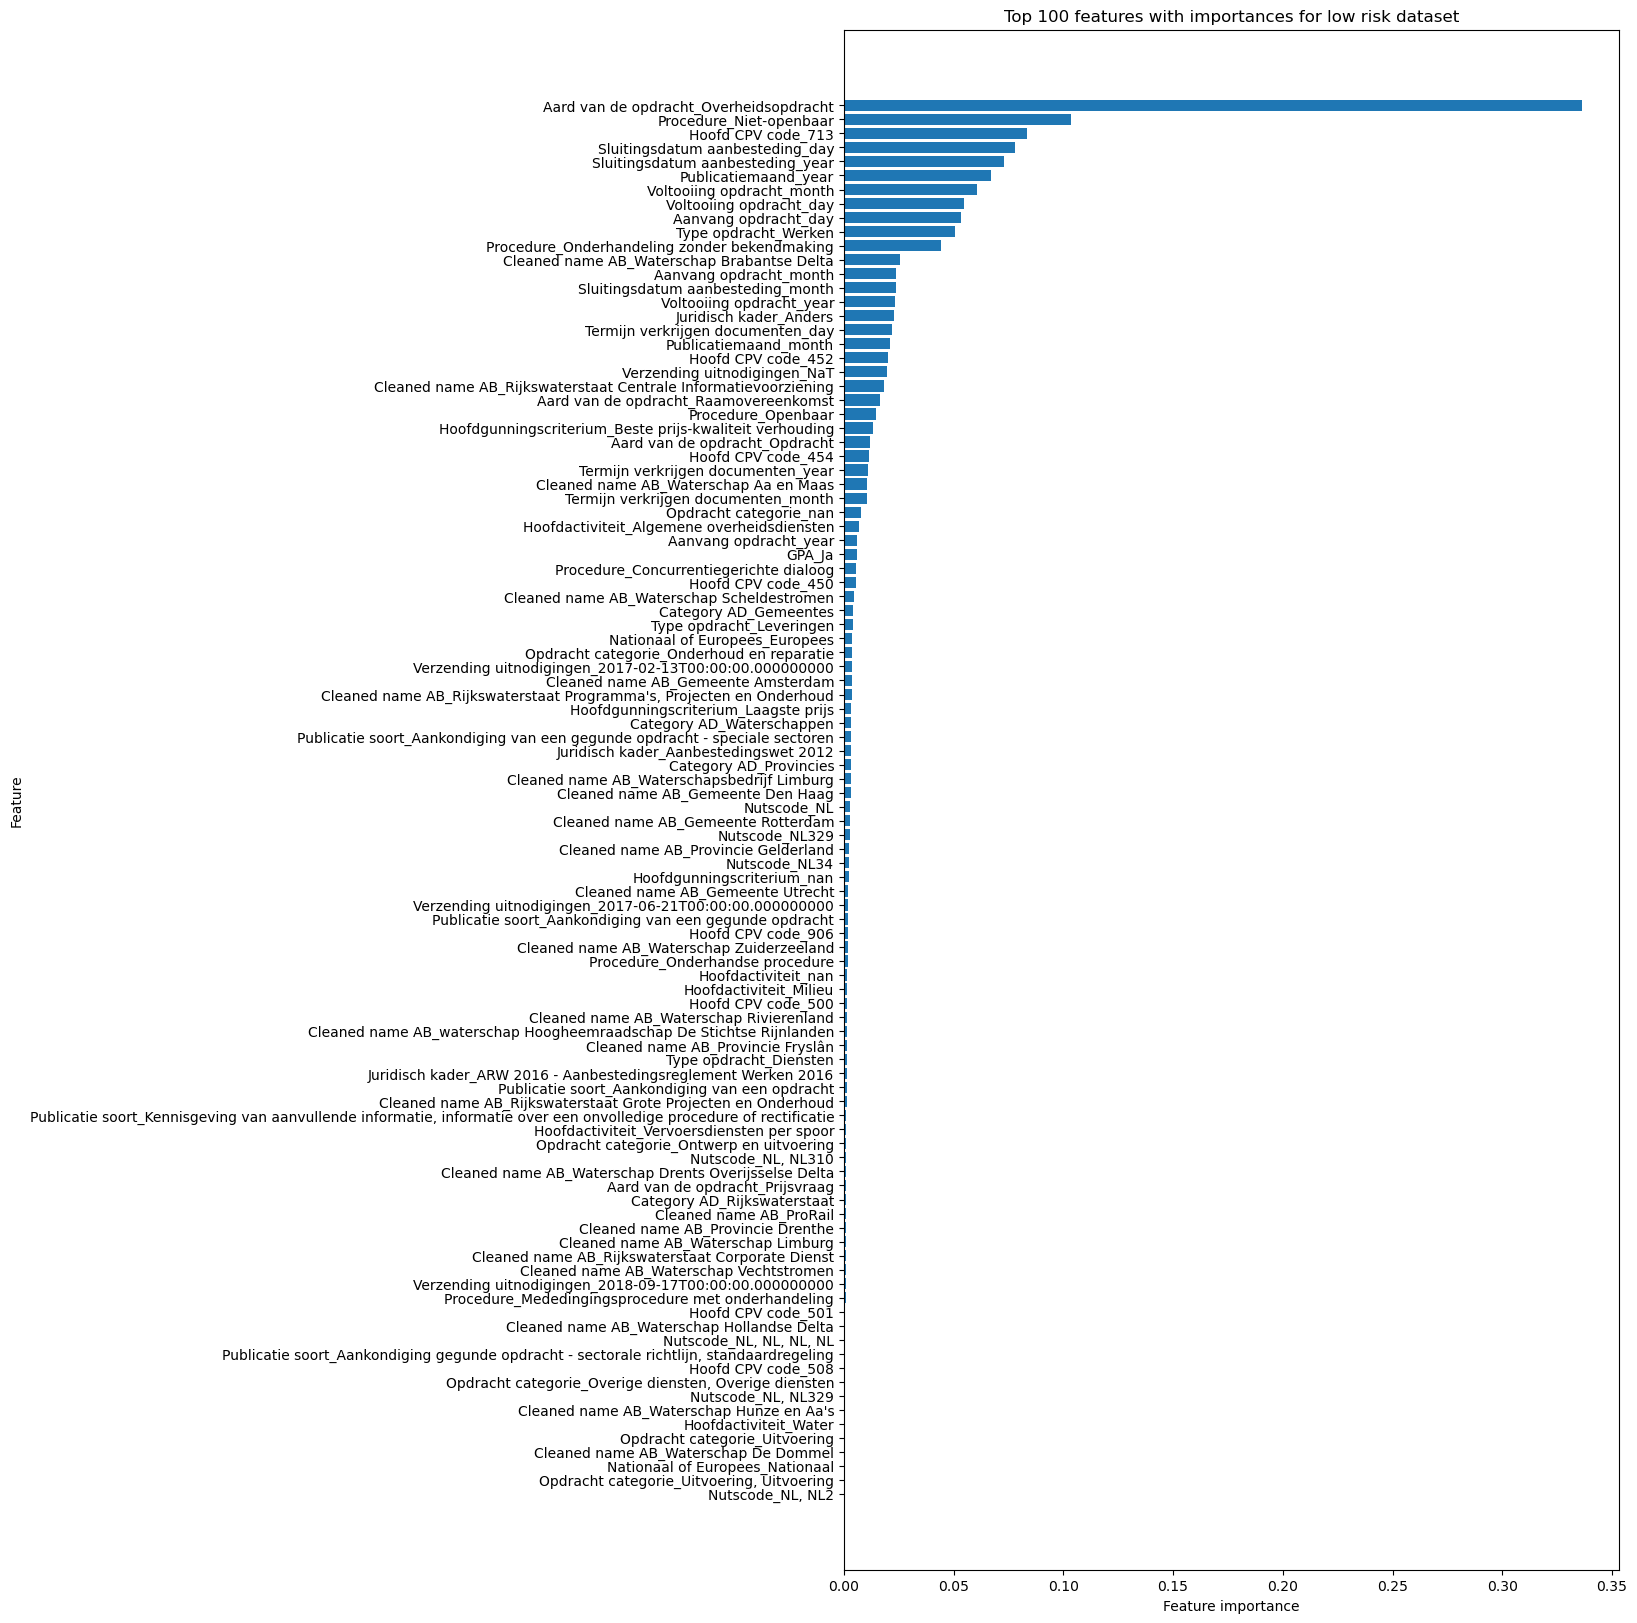

In [44]:
top_100_indices = np.argsort(importances)[::-1][:100] #take top 100

# for i in top_100_indices:
#     print(f"Feature: {feature_names[i]}, Importance: {importances[i]}")

top_100_features = [feature_names[i] for i in top_100_indices]
top_100_importances = [importances[i] for i in top_100_indices]

# Plot the feature importances for the top 100 features
plt.figure(figsize=(10, 20))
plt.barh(top_100_features, top_100_importances)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Top 100 features with importances for low risk dataset")
plt.gca().invert_yaxis()
plt.show()

After we need to check how much features we will take into account. We can do this by doing K-fold validation and checking which amount of features gives a good result.

In [45]:
top_feature_counts = list(range(5, 140, 10)) 
best_result = {'num_features': 0, 'avg_mse': float('inf'), 'avg_mae': float('inf'), 'avg_rmse': float('inf'), 'avg_r2': float('-inf')}
results = []

In [46]:
for top_n in top_feature_counts: # so it looks for different numbers
    top_indices = np.argsort(importances)[-top_n:][::-1]
    top_features = feature_names[top_indices]
    
    df_imputed_top_n = df_imputed[top_features.tolist() + [target_column]]
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    imputation_errors = []
    
    for train_index, test_index in kf.split(df_imputed_top_n):
        X_train, X_test = df_imputed_top_n.iloc[train_index].drop(columns=[target_column]), df_imputed_top_n.iloc[test_index].drop(columns=[target_column])
        y_train, y_test = df_imputed_top_n.iloc[train_index][target_column], df_imputed_top_n.iloc[test_index][target_column]
        
        hgb_imputer = HistGradientBoostingRegressor(random_state=42)
        hgb_imputer.fit(X_train, y_train)
        
        y_pred = hgb_imputer.predict(X_test)
        y_pred = np.maximum(y_pred, 0)
        
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        imputation_errors.append({'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R²': r2})
    
    # average calculation after the 10 fold
    avg_mse = np.mean([error['MSE'] for error in imputation_errors])
    avg_mae = np.mean([error['MAE'] for error in imputation_errors])
    avg_rmse = np.mean([error['RMSE'] for error in imputation_errors])
    avg_r2 = np.mean([error['R²'] for error in imputation_errors])
    
    print(f"Top {top_n} features gives: - Average MSE: {avg_mse}, Average MAE: {avg_mae}, Average RMSE: {avg_rmse}, Average R²: {avg_r2}")
    
    results.append({'num_features': top_n, 'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_rmse': avg_rmse, 'avg_r2': avg_r2})
    
    if avg_mse < best_result['avg_mse']:
        best_result = {'num_features': top_n, 'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_rmse': avg_rmse, 'avg_r2': avg_r2}

print(f"Best result: Top {best_result['num_features']} Features - Average MSE: {best_result['avg_mse']}, Average MAE: {best_result['avg_mae']}, Average RMSE: {best_result['avg_rmse']}, Average R²: {best_result['avg_r2']}")

Top 5 features gives: - Average MSE: 10.546150794734578, Average MAE: 2.3880467199535875, Average RMSE: 3.2463936204106694, Average R²: 0.4496810026622556
Top 15 features gives: - Average MSE: 6.415068031236965, Average MAE: 1.7756440710067765, Average RMSE: 2.531113570512941, Average R²: 0.6655409636654881
Top 25 features gives: - Average MSE: 5.183318104957161, Average MAE: 1.5585495671383653, Average RMSE: 2.2755739942376128, Average R²: 0.7294982588176
Top 35 features gives: - Average MSE: 4.780460570009221, Average MAE: 1.4640653210057952, Average RMSE: 2.185485010253997, Average R²: 0.7504885275362427
Top 45 features gives: - Average MSE: 4.6581448066940165, Average MAE: 1.4471984381980674, Average RMSE: 2.1575221279833, Average R²: 0.7568169613221933
Top 55 features gives: - Average MSE: 4.625079496252914, Average MAE: 1.438479535753489, Average RMSE: 2.1499108988869784, Average R²: 0.75854425530771
Top 65 features gives: - Average MSE: 4.6058263590678745, Average MAE: 1.4405474

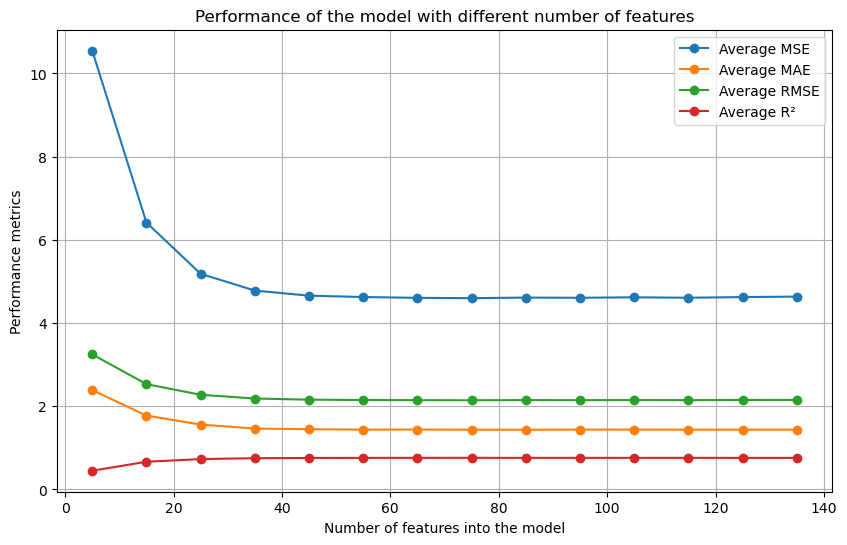

In [47]:
# visualize that so it becomes clear how it develops
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['num_features'], results_df['avg_mse'], marker='o', label='Average MSE')
plt.plot(results_df['num_features'], results_df['avg_mae'], marker='o', label='Average MAE')
plt.plot(results_df['num_features'], results_df['avg_rmse'], marker='o', label='Average RMSE')
plt.plot(results_df['num_features'], results_df['avg_r2'], marker='o', label='Average R²')

plt.xlabel('Number of features into the model')
plt.ylabel('Performance metrics')
plt.title('Performance of the model with different number of features')
plt.legend()
plt.grid(True)
plt.show()

Now we know in this instance, we can take 95 features as best and train it on that. Really happy with this performance, now impute it in the dataset

In [48]:
best_top_n = best_result['num_features']
top_indices = np.argsort(importances)[-best_top_n:][::-1]
top_features = feature_names[top_indices]
df_imputed_top = df_imputed[top_features.tolist() + [target_column]]

In [49]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
imputation_errors = []

In [50]:
for train_index, test_index in kf.split(df_imputed_top):
    X_train, X_test = df_imputed_top.iloc[train_index].drop(columns=[target_column]), df_imputed_top.iloc[test_index].drop(columns=[target_column])
    y_train, y_test = df_imputed_top.iloc[train_index][target_column], df_imputed_top.iloc[test_index][target_column]
    
    hgb_imputer = HistGradientBoostingRegressor(random_state=42)
    hgb_imputer.fit(X_train, y_train)
    
    y_pred = hgb_imputer.predict(X_test)
    y_pred = np.maximum(y_pred, 0)

    y_pred = np.round(y_pred).astype(int)

    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Fold Results - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")
    imputation_errors.append({'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R²': r2})

Fold Results - MSE: 4.775792038992689, MAE: 1.4191714053614948, RMSE: 2.185358560738418, R²: 0.7406881259972709
Fold Results - MSE: 4.90982940698619, MAE: 1.4346060113728676, RMSE: 2.2158134865069736, R²: 0.7278889401727282
Fold Results - MSE: 4.934199837530463, MAE: 1.4199837530463038, RMSE: 2.2213058856290964, R²: 0.7525887848321129
Fold Results - MSE: 4.709179528838343, MAE: 1.3785540211210399, RMSE: 2.170064406610629, R²: 0.752741441624675
Fold Results - MSE: 4.790414297319253, MAE: 1.4094232331437855, RMSE: 2.1887015094158575, R²: 0.7588828813388179
Fold Results - MSE: 4.635255889520715, MAE: 1.421608448415922, RMSE: 2.152964442233247, R²: 0.7568758233550034
Fold Results - MSE: 4.765231519090171, MAE: 1.3631194151096668, RMSE: 2.182941025105848, R²: 0.7709850535795147
Fold Results - MSE: 4.383428107229895, MAE: 1.3663688058489034, RMSE: 2.0936637999521066, R²: 0.767412359750109
Fold Results - MSE: 4.20650406504065, MAE: 1.3658536585365855, RMSE: 2.050976368718238, R²: 0.7641738081

In [51]:
avg_mse = np.mean([error['MSE'] for error in imputation_errors])
avg_mae = np.mean([error['MAE'] for error in imputation_errors])
avg_rmse = np.mean([error['RMSE'] for error in imputation_errors])
avg_r2 = np.mean([error['R²'] for error in imputation_errors])

print(f"Average MSE: {avg_mse}")
print(f"Average MAE: {avg_mae}")
print(f"Average RMSE: {avg_rmse}")
print(f"Average R²: {avg_r2}")

Average MSE: 4.675129810518252
Average MAE: 1.398437980886714
Average RMSE: 2.1616195067579134
Average R²: 0.7558774009087077


In [52]:
mask = df_lowrisk_imputed['Aantal inschrijvingen'].isna() # create mask
X_missing = df_lowrisk_imputed[mask].drop(columns=['Aantal inschrijvingen'])
X_missing = X_missing[top_features]

In [53]:
imputed_values = hgb_imputer.predict(X_missing)  # PREDICTION
imputed_values = np.maximum(imputed_values, 0)  # no negatives
imputed_values = np.round(imputed_values).astype(int) # only whole numbers

In [54]:
df_lowrisk_imputed.loc[mask, 'Aantal inschrijvingen'] = imputed_values # insert
print(df_lowrisk_imputed['Aantal inschrijvingen'].isna().sum()) # output is 0, so went correctly as i wanted

0


In [55]:
print("Before Imputation:")
print(df_lowrisk['Aantal inschrijvingen'].describe())
print("After Imputation:")
print(df_lowrisk_imputed['Aantal inschrijvingen'].describe())

Before Imputation:
count    12308.000000
mean         6.371222
std          4.380060
min          0.000000
25%          3.000000
50%          5.000000
75%          9.000000
max         20.000000
Name: Aantal inschrijvingen, dtype: float64
After Imputation:
count    15685.000000
mean         6.239273
std          4.047104
min          0.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         20.000000
Name: Aantal inschrijvingen, dtype: float64


10903 means all NaN values are filled. I now want to add the the column to the original dataset, but indexes don't match as we can wee down here, so that needs to be sorted first.

In [56]:
print("Index of df_lowrisk:", df_lowrisk.index)
print("Index of df_lowrisk_imputed:", df_lowrisk_imputed.index)

Index of df_lowrisk: Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       17193, 17194, 17195, 17196, 17197, 17198, 17199, 17200, 17201, 17202],
      dtype='int64', length=15685)
Index of df_lowrisk_imputed: RangeIndex(start=0, stop=15685, step=1)


In [57]:
df_lowrisk_imputed = df_lowrisk_imputed.set_index(df_lowrisk.index)
equal = df_lowrisk.index.equals(df_lowrisk_imputed.index)
print(equal)

True


In [58]:
df_lowrisk.loc[:, 'Aantal inschrijvingen IMPUTED'] = df_lowrisk_imputed['Aantal inschrijvingen'] # return to the old df
nan_count = df_lowrisk['Aantal inschrijvingen IMPUTED'].isna().sum()
print(nan_count)

0


/var/folders/gs/nl34jk5j4p78xt66f6906_b80000gn/T/ipykernel_3916/3156762540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowrisk.loc[:, 'Aantal inschrijvingen IMPUTED'] = df_lowrisk_imputed['Aantal inschrijvingen'] # return to the old df


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


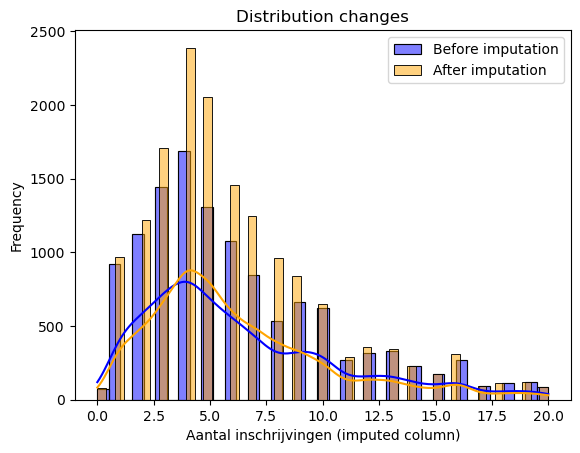

In [59]:
# distribution comparison
sns.histplot(df_lowrisk['Aantal inschrijvingen'], kde=True, color='blue', label='Before imputation')
sns.histplot(df_lowrisk['Aantal inschrijvingen IMPUTED'], kde=True, color='orange', label='After imputation')
plt.legend()
plt.title('Distribution changes')
plt.xlabel('Aantal inschrijvingen (imputed column)')
plt.ylabel('Frequency')
plt.show()

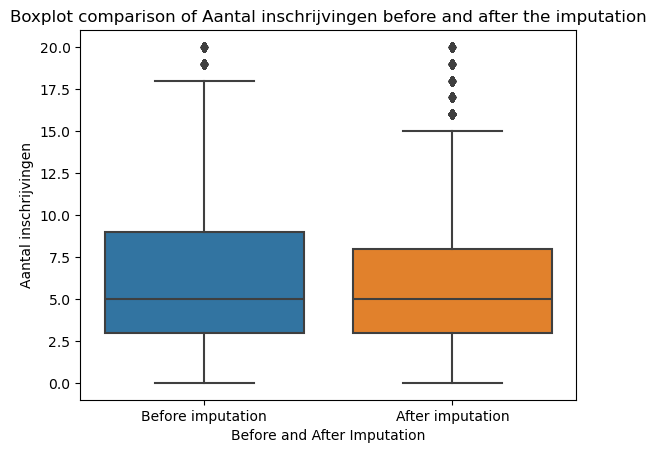

In [60]:
# boxplot
sns.boxplot(data=[df_lowrisk['Aantal inschrijvingen'], df_lowrisk['Aantal inschrijvingen IMPUTED']])
plt.xticks([0, 1], ['Before imputation', 'After imputation'])
plt.title('Boxplot comparison of Aantal inschrijvingen before and after the imputation')
plt.xlabel('Before and After Imputation')
plt.ylabel('Aantal inschrijvingen')
plt.show()

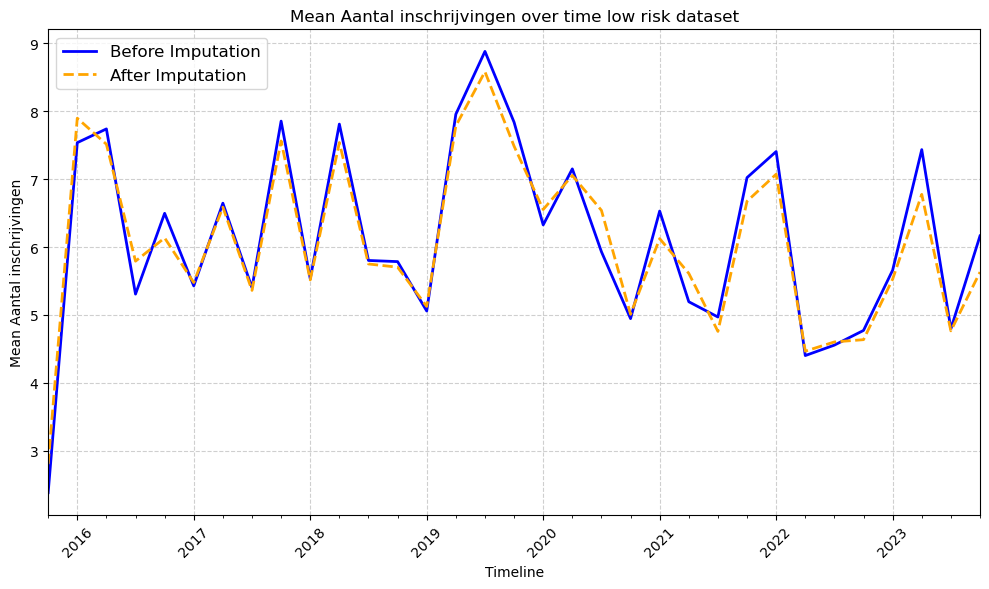

In [61]:
mean_before_imputation = df_lowrisk.groupby('Publicatiemaand_kwartaal')['Aantal inschrijvingen'].mean()
mean_after_imputation = df_lowrisk.groupby('Publicatiemaand_kwartaal')['Aantal inschrijvingen IMPUTED'].mean()

plt.figure(figsize=(10, 6))
mean_before_imputation.plot(label='Before Imputation', color='blue', linestyle='-', linewidth=2)
mean_after_imputation.plot(label='After Imputation', color='orange', linestyle='--', linewidth=2)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.title('Mean Aantal inschrijvingen over time low risk dataset')
plt.xlabel('Timeline')
plt.ylabel('Mean Aantal inschrijvingen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In the visualisations we see little difference with the old data, which means that the imputation didn't adjust the old data's structure which is good for our analysis.

### High risk

Now we can copy a lot just form the low risk part, and change the names to high risk and perform the same checks.

In [62]:
df_highrisk.columns

Index(['Id publicatie', 'Tenderned kenmerk', 'Publicatiedatum',
       'Publicatiemaand', 'Publicatiemaand_kwartaal', 'Publicatiemaand_jaar',
       'Naam Aanbestedende dienst', 'Cleaned name AB', 'Category AD',
       'Nationaal identificatienummer', 'Naam aanbesteding', 'URL TenderNed',
       'Geimporteerd', 'Tsender', 'Aanbesteding id',
       'Sluitingsdatum aanmelding', 'Sluitingsdatum aanmelding_kwartaal',
       'Sluitingsdatum aanmelding_jaar', 'Sluitingsdatum aanbesteding',
       'Sluitingsdatum aanbesteding_kwartaal',
       'Sluitingsdatum aanbesteding_jaar', 'Aanvang opdracht',
       'Aanvang opdracht_kwartaal', 'Aanvang opdracht_jaar',
       'Voltooiing opdracht', 'Voltooiing opdracht_kwartaal',
       'Voltooiing opdracht_jaar', 'Termijn verkrijgen documenten',
       'Termijn verkrijgen documenten_kwartaal',
       'Termijn verkrijgen documenten_jaar', 'Verzending uitnodigingen',
       'Verzending uitnodigingen_kwartaal', 'Verzending uitnodigingen_jaar',
       'Teg

In [63]:
print(df_highrisk['Aantal inschrijvingen'].describe()) # situation beforehand

count    1140.000000
mean        3.915789
std         2.468398
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        15.000000
Name: Aantal inschrijvingen, dtype: float64


In [64]:
Q1 = df_highrisk['Aantal inschrijvingen'].quantile(0.25)
Q3 = df_highrisk['Aantal inschrijvingen'].quantile(0.75)
IQR = Q3 - Q1

# bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with NaN
df_highrisk['Aantal inschrijvingen'] = df_highrisk['Aantal inschrijvingen'].apply(
    lambda x: x if lower_bound <= x <= upper_bound else np.nan
)

print(df_highrisk['Aantal inschrijvingen'].describe())

count    1110.000000
mean        3.675676
std         1.986710
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         9.000000
Name: Aantal inschrijvingen, dtype: float64


/var/folders/gs/nl34jk5j4p78xt66f6906_b80000gn/T/ipykernel_3916/1789581861.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highrisk['Aantal inschrijvingen'] = df_highrisk['Aantal inschrijvingen'].apply(


In [65]:
df = df_highrisk.loc[:, nominal_columns]
df['Aantal inschrijvingen'] = df_highrisk.loc[:, 'Aantal inschrijvingen']

In [66]:
data_types = df.dtypes
grouped_by_dtype = {dtype: list(data_types[data_types == dtype].index) for dtype in data_types.unique()} # useful to know what datatypes, for the ML model later

for dtype, columns in grouped_by_dtype.items():
    print(f"{dtype}: {columns}")

datetime64[ns]: ['Publicatiemaand', 'Sluitingsdatum aanbesteding', 'Aanvang opdracht', 'Voltooiing opdracht', 'Termijn verkrijgen documenten', 'Verzending uitnodigingen']
period[Q-DEC]: ['Publicatiemaand_kwartaal', 'Sluitingsdatum aanbesteding_kwartaal', 'Aanvang opdracht_kwartaal', 'Voltooiing opdracht_kwartaal', 'Termijn verkrijgen documenten_kwartaal']
object: ['Cleaned name AB', 'Category AD', 'Tegen betaling documenten verkrijgen', 'Personen aanwezig opening kluis', 'Nationaal of Europees', 'Publicatie soort', 'Juridisch kader', 'Type opdracht', 'Procedure', 'Opdracht categorie', 'Nutscode', 'Aard van de opdracht', 'GPA', 'Hoofdactiviteit', 'Hoofdgunningscriterium']
int64: ['Hoofd CPV code']
float64: ['Aantal inschrijvingen']


In [67]:
# Updated datetime columns
datetime_cols = [
    'Publicatiemaand', 'Sluitingsdatum aanbesteding', 
    'Aanvang opdracht', 'Voltooiing opdracht', 
    'Termijn verkrijgen documenten'
]

for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], format='%d-%m-%Y', errors='coerce')
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df.drop(columns=col, inplace=True)

# Updated period columns
period_cols = [
    'Publicatiemaand_kwartaal', 'Sluitingsdatum aanbesteding_kwartaal', 
    'Aanvang opdracht_kwartaal', 'Voltooiing opdracht_kwartaal', 
    'Termijn verkrijgen documenten_kwartaal'
]
placeholder_period = '1900Q1'

for col in period_cols:
    df[col] = df[col].fillna(placeholder_period).astype(str)
    df[col + '_year'] = df[col].str[:4].astype(int)
    df[col + '_quarter'] = df[col].str[5:].astype(int)
    df.drop(columns=col, inplace=True)

# Updated categorical columns
categorical_cols = [
    'Cleaned name AB', 'Category AD', 'Verzending uitnodigingen', 
    'Tegen betaling documenten verkrijgen', 'Personen aanwezig opening kluis', 
    'Nationaal of Europees', 'Publicatie soort', 'Juridisch kader', 
    'Type opdracht', 'Procedure', 'Opdracht categorie', 
    'Nutscode', 'Aard van de opdracht', 'GPA', 'Hoofdactiviteit', 
    'Hoofdgunningscriterium', 'Hoofd CPV code'
]

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols)) # one hot encoding

df.drop(columns=categorical_cols, inplace=True)
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [68]:
# check if the transition was succesful
data_types = df.dtypes
grouped_by_dtype = {dtype: list(data_types[data_types == dtype].index) for dtype in data_types.unique()}

# Display the grouped columns by data type
for dtype, columns in grouped_by_dtype.items():
    print(f"{dtype}: {columns}")

float64: ['Aantal inschrijvingen', 'Sluitingsdatum aanbesteding_year', 'Sluitingsdatum aanbesteding_month', 'Sluitingsdatum aanbesteding_day', 'Aanvang opdracht_year', 'Aanvang opdracht_month', 'Aanvang opdracht_day', 'Voltooiing opdracht_year', 'Voltooiing opdracht_month', 'Voltooiing opdracht_day', 'Termijn verkrijgen documenten_year', 'Termijn verkrijgen documenten_month', 'Termijn verkrijgen documenten_day', 'Cleaned name AB_Avri', 'Cleaned name AB_Gemeenschappelijke regeling Veiligheidsregio Brabant-Noord, onderdeel Brandweer', 'Cleaned name AB_Gemeente Amsterdam', 'Cleaned name AB_Gemeente Den Haag', 'Cleaned name AB_Gemeente Eindhoven', 'Cleaned name AB_Gemeente Rotterdam', 'Cleaned name AB_Gemeente Utrecht', 'Cleaned name AB_ProRail', 'Cleaned name AB_Provincie Flevoland', 'Cleaned name AB_Provincie Fryslân', 'Cleaned name AB_Provincie Gelderland', 'Cleaned name AB_Provincie Limburg', 'Cleaned name AB_Provincie Noord-Brabant', 'Cleaned name AB_Provincie Noord-Holland', 'Cleaned

In [69]:
print(df_highrisk['Aantal inschrijvingen'].describe()) # situation beforehand 
print(f"The number of rows: {df_highrisk.shape[0]}")

count    1110.000000
mean        3.675676
std         1.986710
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         9.000000
Name: Aantal inschrijvingen, dtype: float64
The number of rows: 1518


In [70]:
target_column = 'Aantal inschrijvingen'
df_imputed = df.copy()
df_highrisk_imputed = df.copy()

df_imputed = df_imputed.dropna(subset=[target_column]) # skip rows where the target column is missing

#### Feature importance

In [71]:
df_imputed.shape # 335 columns

(1110, 335)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df_imputed.drop(columns=[target_column]), df_imputed[target_column], test_size=0.2, random_state=42) #first train the model on the whole dataset
hgb_imputer = HistGradientBoostingRegressor(random_state=42)
hgb_imputer.fit(X_train, y_train)

HistGradientBoostingRegressor(random_state=42)

In [73]:
feature_names = X_train.columns 
n_repeats = 10

def calculate_permutation_importance(model, X, y, n_repeats, random_state=42):
    print("Starting calculation")
    
    start_time = time.time()
    importances = np.zeros((n_repeats, X.shape[1]))
    
    for i in tqdm(range(n_repeats), desc="Repeats"):
        result = permutation_importance(model, X, y, n_repeats=1, random_state=random_state + i, n_jobs=-1)
        importances[i, :] = result.importances[:, 0]
        print(f"Round {i+1}/{n_repeats} done")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time taken: {elapsed_time:.2f} seconds")
    
    mean_importances = importances.mean(axis=0)
    return mean_importances

importances = calculate_permutation_importance(hgb_imputer, X_train, y_train, n_repeats) # actual function

Starting calculation


Repeats:  10%|█         | 1/10 [00:01<00:12,  1.40s/it]

Round 1/10 done


Repeats:  20%|██        | 2/10 [00:02<00:11,  1.39s/it]

Round 2/10 done


Repeats:  30%|███       | 3/10 [00:04<00:10,  1.46s/it]

Round 3/10 done


Repeats:  40%|████      | 4/10 [00:05<00:08,  1.45s/it]

Round 4/10 done


Repeats:  50%|█████     | 5/10 [00:06<00:06,  1.34s/it]

Round 5/10 done


Repeats:  60%|██████    | 6/10 [00:08<00:05,  1.29s/it]

Round 6/10 done


Repeats:  70%|███████   | 7/10 [00:09<00:03,  1.23s/it]

Round 7/10 done


Repeats:  80%|████████  | 8/10 [00:10<00:02,  1.20s/it]

Round 8/10 done


Repeats:  90%|█████████ | 9/10 [00:11<00:01,  1.19s/it]

Round 9/10 done


Repeats: 100%|██████████| 10/10 [00:12<00:00,  1.30s/it]

Round 10/10 done
Total time taken: 12.99 seconds


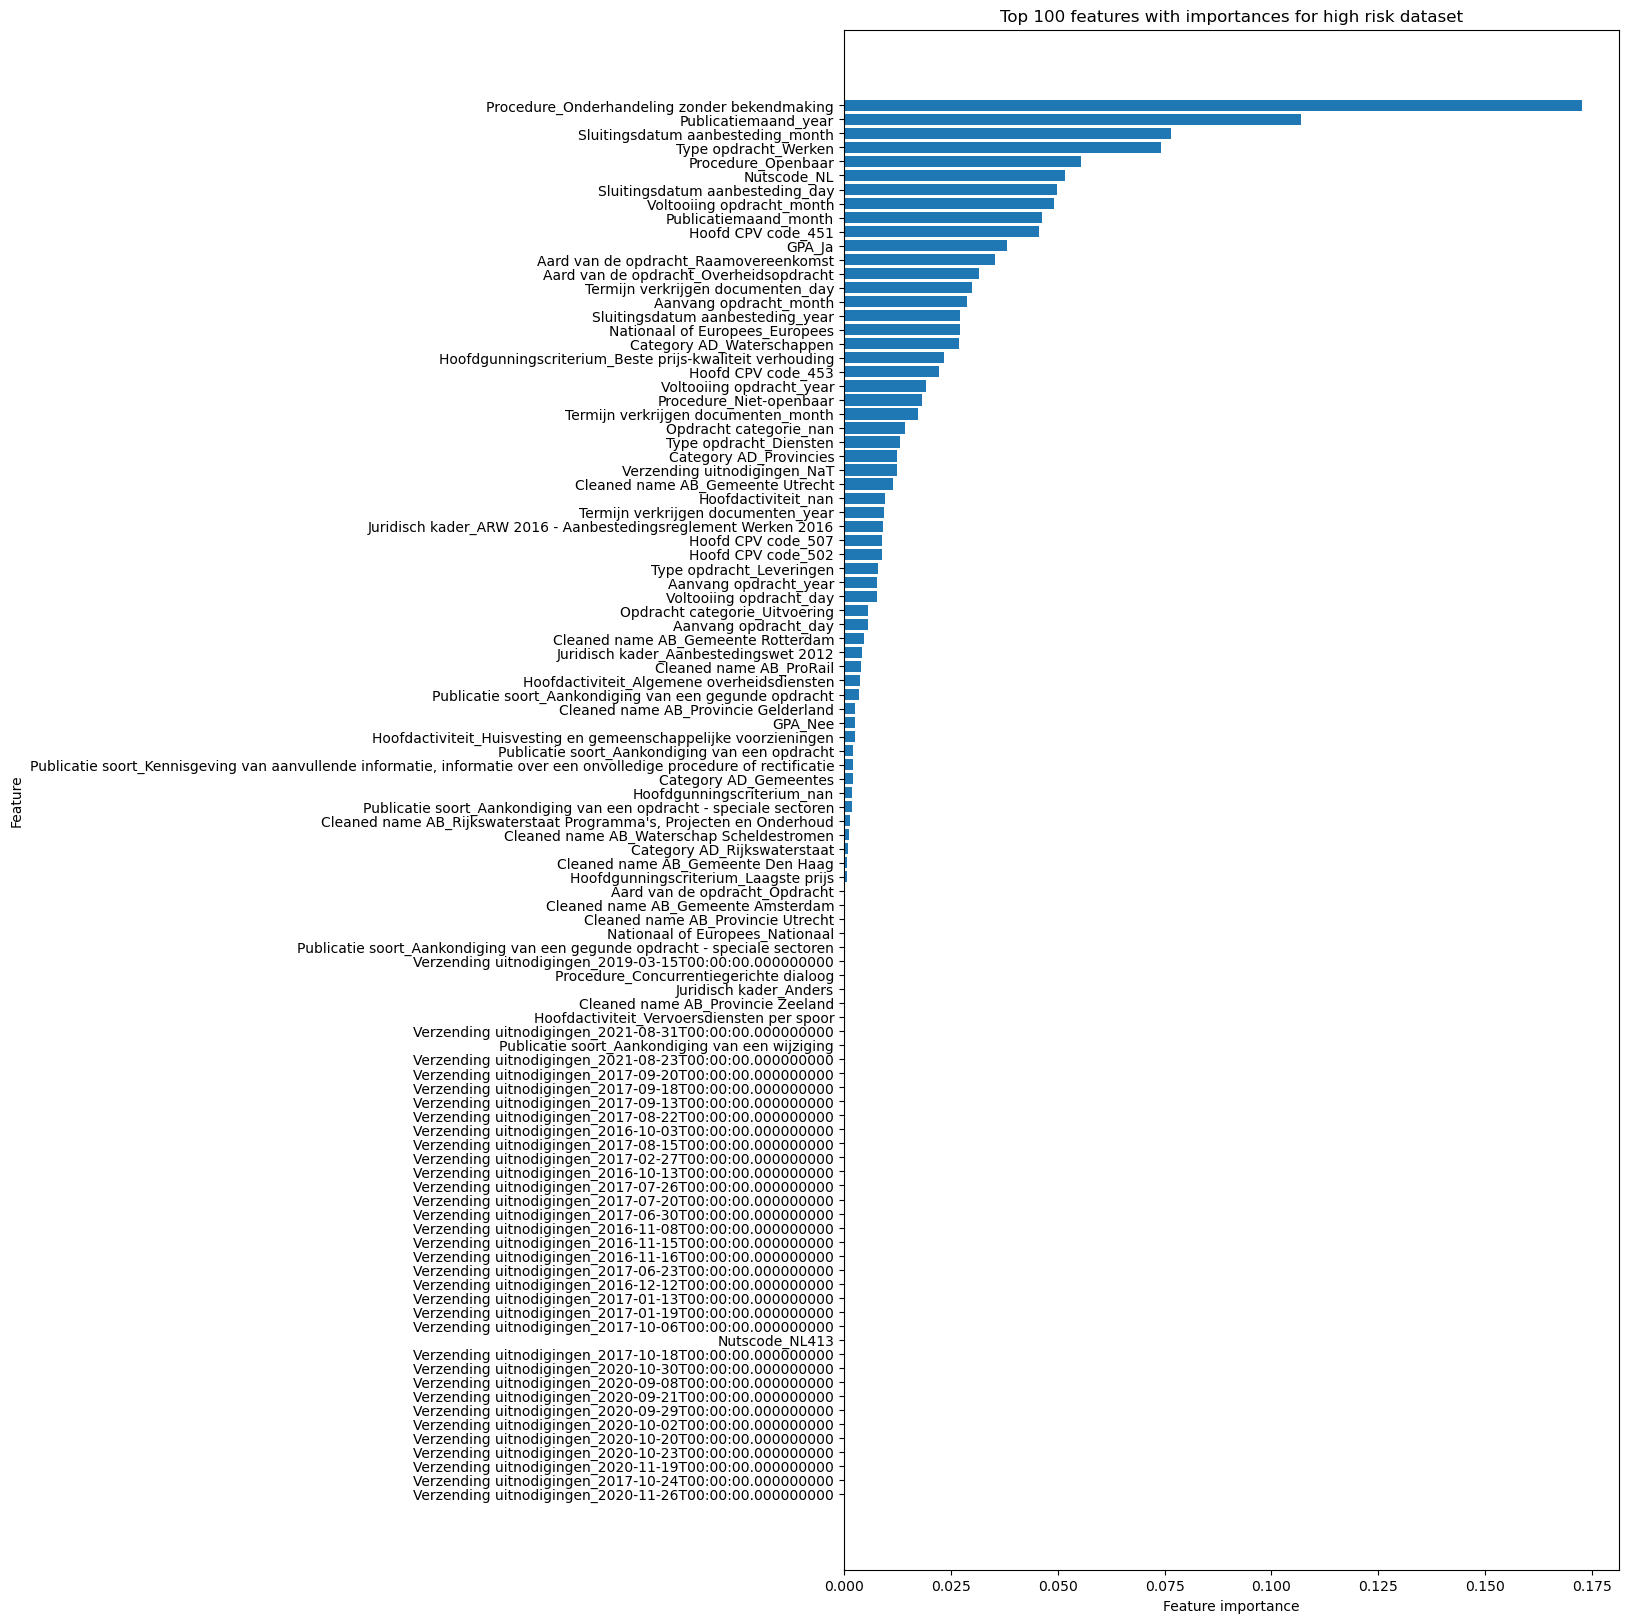

In [74]:
top_100_indices = np.argsort(importances)[::-1][:100] #take top 100

# for i in top_100_indices:
#     print(f"Feature: {feature_names[i]}, Importance: {importances[i]}")

top_100_indices = np.argsort(importances)[::-1][:100] #take top 100

# for i in top_100_indices:
#     print(f"Feature: {feature_names[i]}, Importance: {importances[i]}")

top_100_features = [feature_names[i] for i in top_100_indices]
top_100_importances = [importances[i] for i in top_100_indices]

# Plot the feature importances for the top 100 features
plt.figure(figsize=(10, 20))
plt.barh(top_100_features, top_100_importances)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Top 100 features with importances for high risk dataset")
plt.gca().invert_yaxis()
plt.show()

In [75]:
top_feature_counts = list(range(5, 140, 10)) 
best_result = {'num_features': 0, 'avg_mse': float('inf'), 'avg_mae': float('inf'), 'avg_rmse': float('inf'), 'avg_r2': float('-inf')}
results = []

In [76]:
for top_n in top_feature_counts: # so it looks for different numbers
    top_indices = np.argsort(importances)[-top_n:][::-1]
    top_features = feature_names[top_indices]
    
    df_imputed_top_n = df_imputed[top_features.tolist() + [target_column]]
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    imputation_errors = []
    
    for train_index, test_index in kf.split(df_imputed_top_n):
        X_train, X_test = df_imputed_top_n.iloc[train_index].drop(columns=[target_column]), df_imputed_top_n.iloc[test_index].drop(columns=[target_column])
        y_train, y_test = df_imputed_top_n.iloc[train_index][target_column], df_imputed_top_n.iloc[test_index][target_column]
        
        hgb_imputer = HistGradientBoostingRegressor(random_state=42)
        hgb_imputer.fit(X_train, y_train)
        
        y_pred = hgb_imputer.predict(X_test)
        y_pred = np.maximum(y_pred, 0)
        y_pred = np.round(y_pred).astype(int)
        
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        imputation_errors.append({'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R²': r2})
    
    # average calculation after the 10 fold
    avg_mse = np.mean([error['MSE'] for error in imputation_errors])
    avg_mae = np.mean([error['MAE'] for error in imputation_errors])
    avg_rmse = np.mean([error['RMSE'] for error in imputation_errors])
    avg_r2 = np.mean([error['R²'] for error in imputation_errors])
    
    print(f"Top {top_n} features gives: - Average MSE: {avg_mse}, Average MAE: {avg_mae}, Average RMSE: {avg_rmse}, Average R²: {avg_r2}")
    
    results.append({'num_features': top_n, 'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_rmse': avg_rmse, 'avg_r2': avg_r2})
    
    if avg_mse < best_result['avg_mse']:
        best_result = {'num_features': top_n, 'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_rmse': avg_rmse, 'avg_r2': avg_r2}

print(f"Best result: Top {best_result['num_features']} Features - Average MSE: {best_result['avg_mse']}, Average MAE: {best_result['avg_mae']}, Average RMSE: {best_result['avg_rmse']}, Average R²: {best_result['avg_r2']}")

Top 5 features gives: - Average MSE: 2.724324324324324, Average MAE: 1.172972972972973, Average RMSE: 1.644180032102708, Average R²: 0.3064317146985397
Top 15 features gives: - Average MSE: 1.598198198198198, Average MAE: 0.7873873873873874, Average RMSE: 1.2604954682642326, Average R²: 0.5921078376339708
Top 25 features gives: - Average MSE: 1.4675675675675675, Average MAE: 0.718018018018018, Average RMSE: 1.2067030628681956, Average R²: 0.6252267518713672
Top 35 features gives: - Average MSE: 1.4495495495495496, Average MAE: 0.7216216216216217, Average RMSE: 1.199819439308352, Average R²: 0.6293490718987179
Top 45 features gives: - Average MSE: 1.4225225225225224, Average MAE: 0.7108108108108108, Average RMSE: 1.187853487876587, Average R²: 0.6360422308449144
Top 55 features gives: - Average MSE: 1.4117117117117117, Average MAE: 0.7036036036036036, Average RMSE: 1.1814022581161248, Average R²: 0.6401318765585877
Top 65 features gives: - Average MSE: 1.4405405405405405, Average MAE: 0

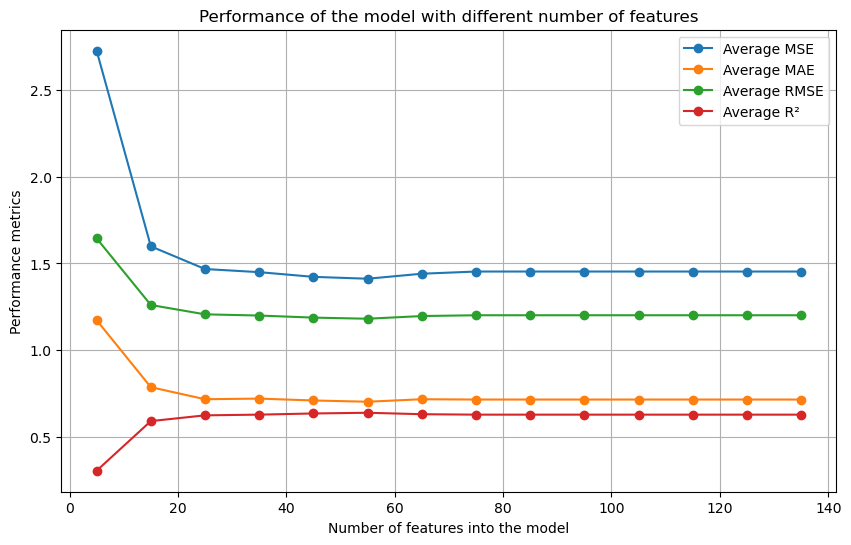

In [77]:
# visualize that so it becomes clear how it develops
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['num_features'], results_df['avg_mse'], marker='o', label='Average MSE')
plt.plot(results_df['num_features'], results_df['avg_mae'], marker='o', label='Average MAE')
plt.plot(results_df['num_features'], results_df['avg_rmse'], marker='o', label='Average RMSE')
plt.plot(results_df['num_features'], results_df['avg_r2'], marker='o', label='Average R²')

plt.xlabel('Number of features into the model')
plt.ylabel('Performance metrics')
plt.title('Performance of the model with different number of features')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
best_top_n = best_result['num_features']
top_indices = np.argsort(importances)[-best_top_n:][::-1]
top_features = feature_names[top_indices]
df_imputed_top = df_imputed[top_features.tolist() + [target_column]]

In [79]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
imputation_errors = []

In [80]:
for train_index, test_index in kf.split(df_imputed_top):
    X_train, X_test = df_imputed_top.iloc[train_index].drop(columns=[target_column]), df_imputed_top.iloc[test_index].drop(columns=[target_column])
    y_train, y_test = df_imputed_top.iloc[train_index][target_column], df_imputed_top.iloc[test_index][target_column]
    
    hgb_imputer = HistGradientBoostingRegressor(random_state=42)
    hgb_imputer.fit(X_train, y_train)
    
    y_pred = hgb_imputer.predict(X_test)
    y_pred = np.maximum(y_pred, 0)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Fold Results - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")
    imputation_errors.append({'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R²': r2})

Fold Results - MSE: 1.3600270077129737, MAE: 0.7570931164588242, RMSE: 1.16620195837298, R²: 0.6162309279490761
Fold Results - MSE: 1.308334126379868, MAE: 0.7286879060221726, RMSE: 1.1438243424494288, R²: 0.7094660664132659
Fold Results - MSE: 1.4462391586672114, MAE: 0.7093282036674569, RMSE: 1.2025968396213302, R²: 0.6497540554694019
Fold Results - MSE: 1.3343472913825183, MAE: 0.8029954809978457, RMSE: 1.1551395116532541, R²: 0.6408804504778505
Fold Results - MSE: 1.5158563840584303, MAE: 0.8366480117064996, RMSE: 1.2312011956046949, R²: 0.597047108781361
Fold Results - MSE: 1.9723257337841194, MAE: 0.9105351435696073, RMSE: 1.404395148732763, R²: 0.5715162858208884
Fold Results - MSE: 1.022136111080348, MAE: 0.6651318086298762, RMSE: 1.011007473305884, R²: 0.731052427612417
Fold Results - MSE: 1.207846379095006, MAE: 0.7165887412330124, RMSE: 1.099020645436202, R²: 0.6919249112567887
Fold Results - MSE: 0.9951540665767347, MAE: 0.6415504756237912, RMSE: 0.9975740907705726, R²: 0.7

In [81]:
avg_mse = np.mean([error['MSE'] for error in imputation_errors])
avg_mae = np.mean([error['MAE'] for error in imputation_errors])
avg_rmse = np.mean([error['RMSE'] for error in imputation_errors])
avg_r2 = np.mean([error['R²'] for error in imputation_errors])

print(f"Average MSE: {avg_mse}")
print(f"Average MAE: {avg_mae}")
print(f"Average RMSE: {avg_rmse}")
print(f"Average R²: {avg_r2}")

Average MSE: 1.3752118649006377
Average MAE: 0.7634554384264719
Average RMSE: 1.1671854694814892
Average R²: 0.6493404542552318


In [82]:
mask = df_highrisk_imputed['Aantal inschrijvingen'].isna() # create mask
X_missing = df_highrisk_imputed[mask].drop(columns=['Aantal inschrijvingen'])
X_missing = X_missing[top_features] 

In [83]:
imputed_values = hgb_imputer.predict(X_missing)  # PREDICTION
imputed_values = np.maximum(imputed_values, 0)  # no negatives
imputed_values = np.round(imputed_values).astype(int) # integers only

In [84]:
df_highrisk_imputed.loc[mask, 'Aantal inschrijvingen'] = imputed_values #Insert
print(df_highrisk_imputed['Aantal inschrijvingen'].isna().sum()) # output is 0, so went correctly as i wanted

0


In [85]:
print("Before Imputation:")
print(df_highrisk['Aantal inschrijvingen'].describe())
print("After Imputation:")
print(df_highrisk_imputed['Aantal inschrijvingen'].describe())

Before Imputation:
count    1110.000000
mean        3.675676
std         1.986710
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         9.000000
Name: Aantal inschrijvingen, dtype: float64
After Imputation:
count    1518.000000
mean        3.778656
std         1.854217
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         9.000000
Name: Aantal inschrijvingen, dtype: float64


In [86]:
print("Index of df_highrisk:", df_highrisk.index)
print("Index of df_highrisk_imputed:", df_highrisk_imputed.index)

Index of df_highrisk: Index([   47,    59,    60,    61,    63,    75,    80,    82,    84,    87,
       ...
       17080, 17082, 17096, 17112, 17133, 17138, 17151, 17158, 17161, 17179],
      dtype='int64', length=1518)
Index of df_highrisk_imputed: RangeIndex(start=0, stop=1518, step=1)


In [87]:
df_highrisk_imputed = df_highrisk_imputed.set_index(df_highrisk.index)
equal = df_highrisk.index.equals(df_highrisk_imputed.index)
print(equal)

True


In [88]:
df_highrisk.loc[:, 'Aantal inschrijvingen IMPUTED'] = df_highrisk_imputed['Aantal inschrijvingen'] # return to the old df
nan_count = df_highrisk['Aantal inschrijvingen IMPUTED'].isna().sum()
print(nan_count)

0


/var/folders/gs/nl34jk5j4p78xt66f6906_b80000gn/T/ipykernel_3916/4134220264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highrisk.loc[:, 'Aantal inschrijvingen IMPUTED'] = df_highrisk_imputed['Aantal inschrijvingen'] # return to the old df


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


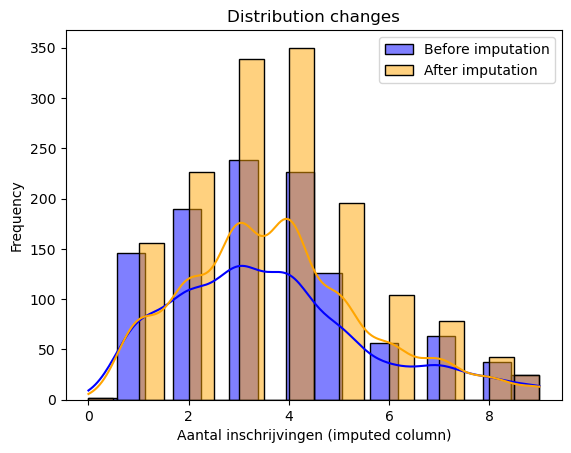

In [89]:
# distribution comparison
sns.histplot(df_highrisk['Aantal inschrijvingen'], kde=True, color='blue', label='Before imputation')
sns.histplot(df_highrisk['Aantal inschrijvingen IMPUTED'], kde=True, color='orange', label='After imputation')
plt.legend()
plt.title('Distribution changes')
plt.xlabel('Aantal inschrijvingen (imputed column)')
plt.ylabel('Frequency')
plt.show()

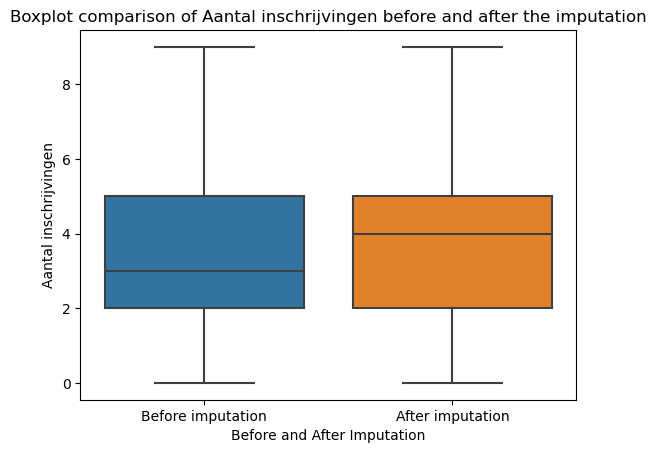

In [90]:
# boxplot
sns.boxplot(data=[df_highrisk['Aantal inschrijvingen'], df_highrisk['Aantal inschrijvingen IMPUTED']])
plt.xticks([0, 1], ['Before imputation', 'After imputation'])
plt.title('Boxplot comparison of Aantal inschrijvingen before and after the imputation')
plt.xlabel('Before and After Imputation')
plt.ylabel('Aantal inschrijvingen')
plt.show()

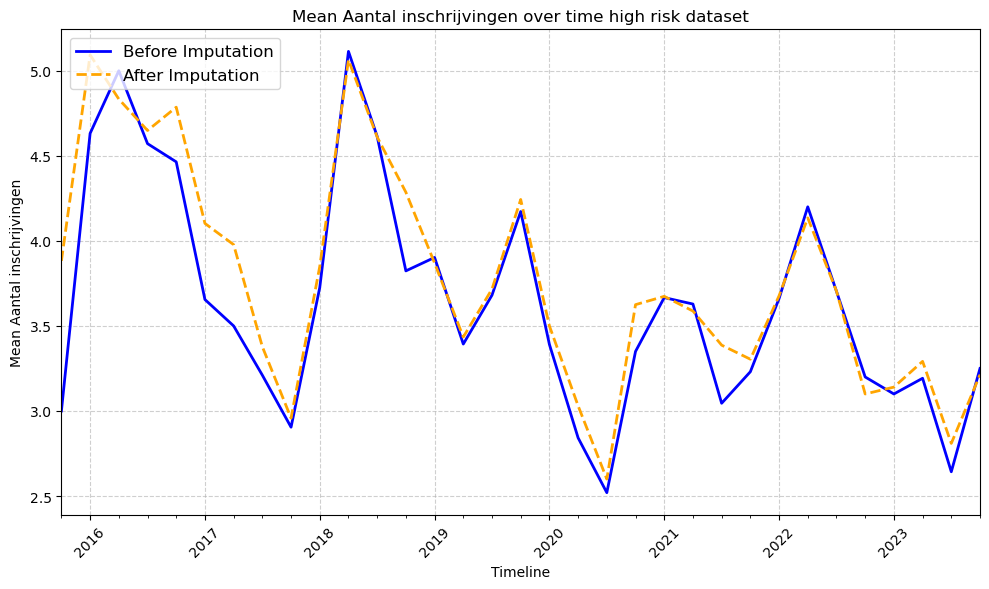

In [91]:
mean_before_imputation = df_highrisk.groupby('Publicatiemaand_kwartaal')['Aantal inschrijvingen'].mean()
mean_after_imputation = df_highrisk.groupby('Publicatiemaand_kwartaal')['Aantal inschrijvingen IMPUTED'].mean()

plt.figure(figsize=(10, 6))
mean_before_imputation.plot(label='Before Imputation', color='blue', linestyle='-', linewidth=2)
mean_after_imputation.plot(label='After Imputation', color='orange', linestyle='--', linewidth=2)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.title('Mean Aantal inschrijvingen over time high risk dataset')
plt.xlabel('Timeline')
plt.ylabel('Mean Aantal inschrijvingen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

All in all, also here i am satisfied, because the overall patterns and tendency have stayed in place. This ensures that the cyclical patterns will also stay the same.

In [92]:
df_lowrisk.to_csv('/Users/aymanelhattache/Desktop/School /UU - ADS/Thesis/df_lowrisk_no.csv', index=False)
df_highrisk.to_csv('/Users/aymanelhattache/Desktop/School /UU - ADS/Thesis/df_highrisk_no.csv', index=False)

# Data exploration

Data exploration across the whole dataset

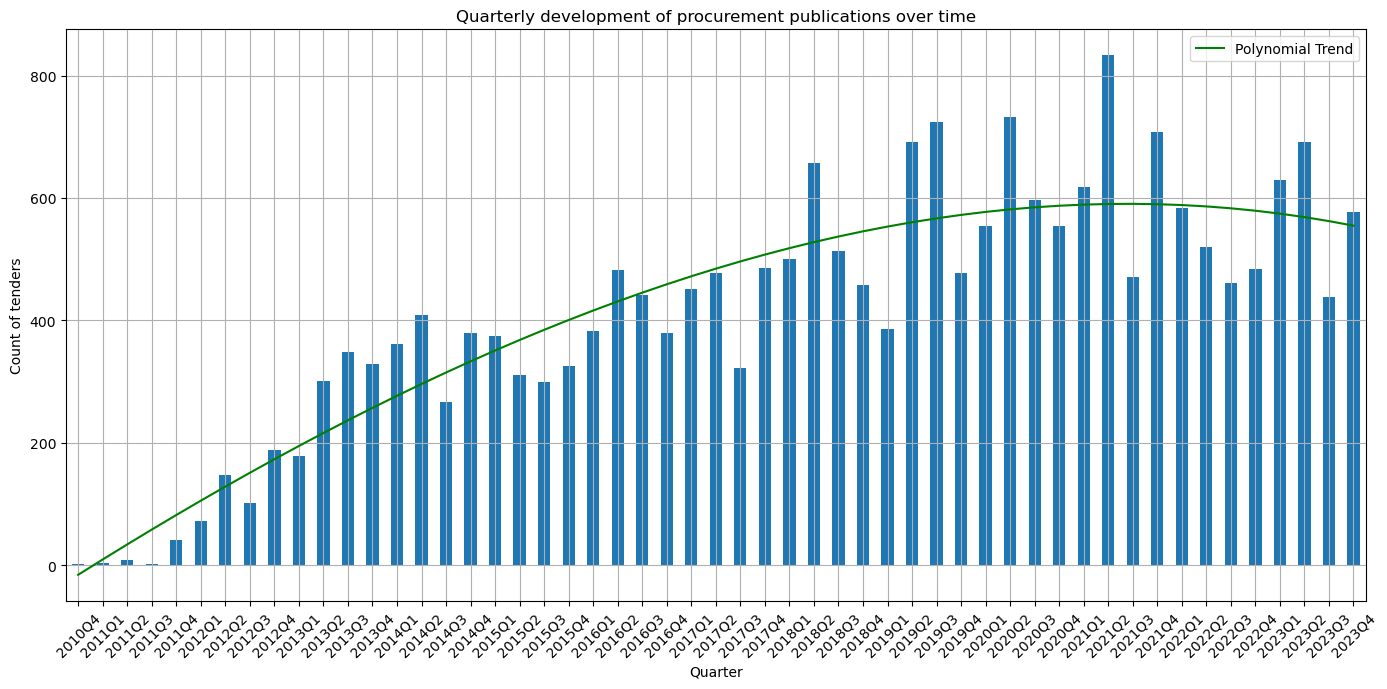

In [93]:
# before delving deep in the data, lets look at some general things
quarterly = df_tenderned.groupby('Publicatiemaand_kwartaal').size()
quarterly = quarterly.sort_index() #grouping, couod also do 

# PLOT
fig, ax = plt.subplots(figsize=(14,7))
quarterly.plot(kind='bar')
ax.set_title('Quarterly development of procurement publications over time')
ax.set_xlabel('Quarter')
ax.set_ylabel('Count of tenders')


# addition of trend line to suppor our statementd, went for polynomial fit instead of trend line because it is smoother
x_coords = np.arange(len(quarterly))

polynomial = np.polyfit(x=x_coords, y=quarterly, deg=3)
trend_poly = np.polyval(polynomial, x_coords)

# plot trend line
ax.plot(x_coords, trend_poly, color='Green', label='Polynomial Trend')
ax.set_xticks(x_coords)
ax.set_xticklabels([str(p) for p in quarterly.index], rotation=45)
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

More and more tenders over time in total. Discussed this with RWS, and those confirm it. This is because organizations tend to become more and more transaparant in their procurement assignments

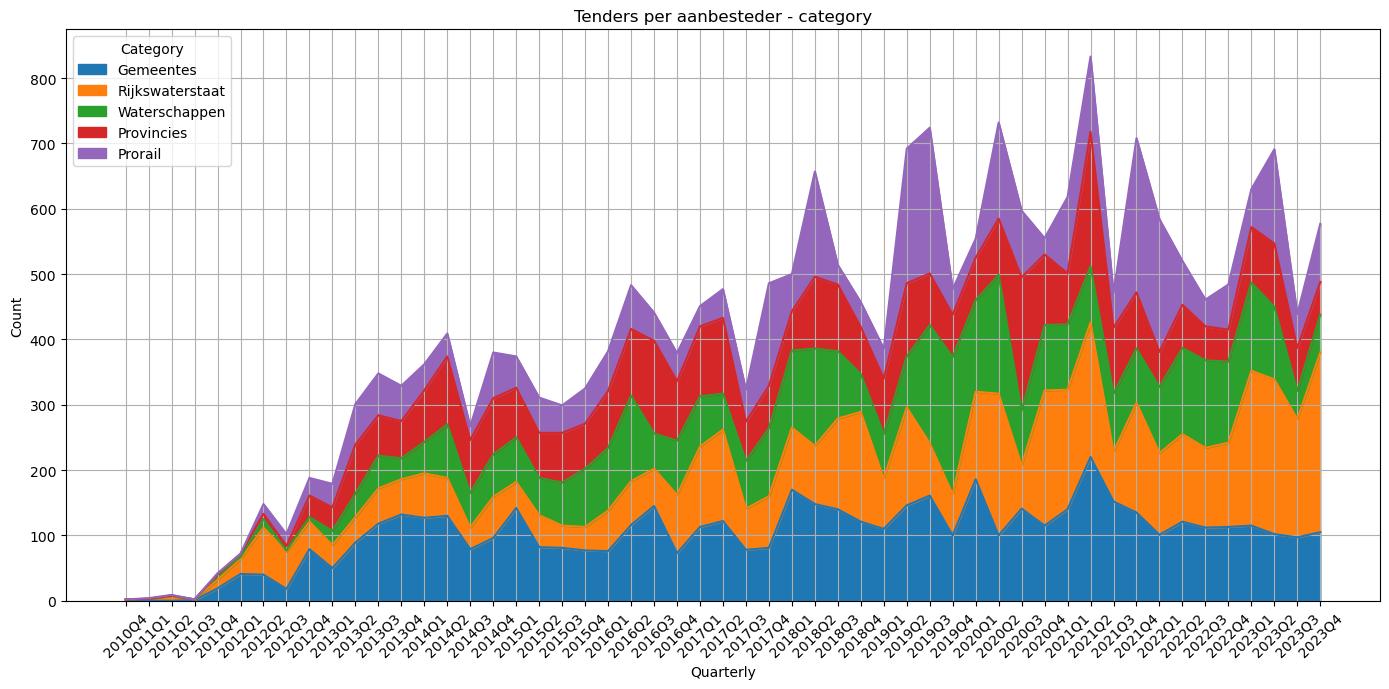

In [94]:
df_grouped = df_tenderned.groupby(['Publicatiemaand_kwartaal', 'Category AD']).size().reset_index(name='counts') # group the categories per half year
df_pivot = df_grouped.pivot(index='Publicatiemaand_kwartaal', columns='Category AD', values='counts')
df_pivot.index = df_pivot.index.astype(str) # convert index to string

# for ordering from highest to lowest, useful for figure
category_totals = df_pivot.sum().sort_values(ascending=False)
df_pivot_sorted = df_pivot[category_totals.index]

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
df_pivot_sorted.plot(kind='area', stacked=True, ax=ax)
x_coords = np.arange(len(df_pivot.index))
ax.set_xticks(x_coords)
ax.set_xticklabels(df_pivot_sorted.index, rotation=45)
ax.set_xlabel('Quarterly')
ax.set_ylabel('Count')
ax.set_title('Tenders per aanbesteder - category')
plt.grid(True)
ax.legend(title='Category', loc='upper left')
plt.tight_layout()
plt.show()

We have mapped the procurers by different categories to get a bette view of who is the most active in the field, we will visualize this more.

Gemeentes are really active, which is not surprise, but also Rijkswaterstaat. Now we will look at individual players instead of categories.

In [95]:
top_5_aanbesteders = df_tenderned['Cleaned name AB'].value_counts().nlargest(5)
print(top_5_aanbesteders)
# PPO is on top

Cleaned name AB
ProRail                                                3485
Rijkswaterstaat Programma's, Projecten en Onderhoud    3384
Gemeente Amsterdam                                     1716
Gemeente Rotterdam                                     1231
Gemeente Den Haag                                      1067
Name: count, dtype: int64


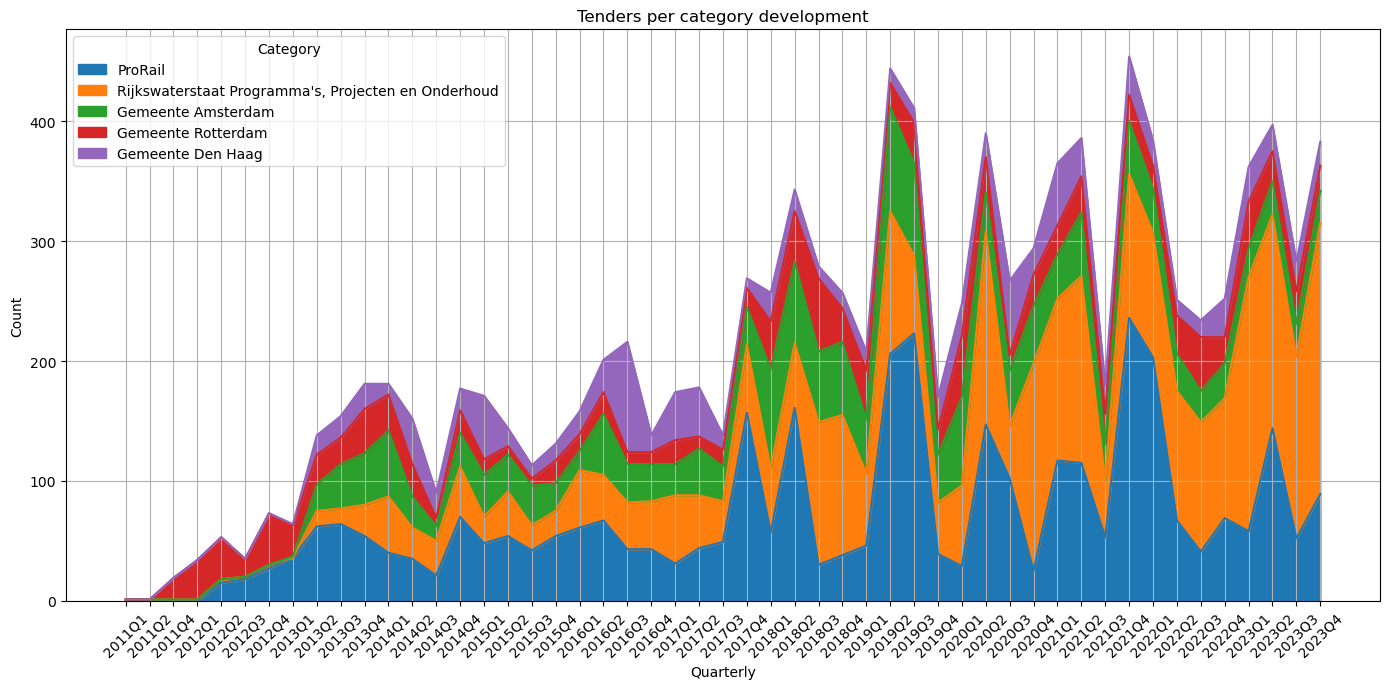

In [96]:
df_top5 = df_tenderned[df_tenderned['Cleaned name AB'].isin(top_5_aanbesteders.index)]

df_grouped = df_top5.groupby(['Publicatiemaand_kwartaal', 'Cleaned name AB']).size().reset_index(name='counts') # group the categories per half year
df_pivot = df_grouped.pivot(index='Publicatiemaand_kwartaal', columns='Cleaned name AB', values='counts')
df_pivot.index = df_pivot.index.astype(str) # convert index to string

# for ordering from highest to lowest, useful for figure
category_totals = df_pivot.sum().sort_values(ascending=False)
df_pivot_sorted = df_pivot[category_totals.index]

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
df_pivot_sorted.plot(kind='area', stacked=True, ax=ax)
x_coords = np.arange(len(df_pivot.index))
ax.set_xticks(x_coords)
ax.set_xticklabels(df_pivot_sorted.index, rotation=45)
ax.set_xlabel('Quarterly')
ax.set_ylabel('Count')
ax.set_title('Tenders per category development')
plt.grid(True)
ax.legend(title='Category', loc='upper left')
plt.tight_layout()
plt.show()

# Analysis

In [97]:
# load so skip the preprocessing

# df_lowrisk.to_csv('/Users/aymanelhattache/Desktop/School /UU - ADS/Thesis/df_lowrisk_no.csv', index=False)
# df_highrisk.to_csv('/Users/aymanelhattache/Desktop/School /UU - ADS/Thesis/df_highrisk_no.csv', index=False)

# filepath = '/Users/aymanelhattache/Desktop/School /UU - ADS/Thesis/df_lowrisk_no.csv'
# df_lowrisk = pd.read_csv(filepath)
# filepath = '/Users/aymanelhattache/Desktop/School /UU - ADS/Thesis/df_highrisk_no.csv'
# df_highrisk = pd.read_csv(filepath)

## Low Risk

### Across whole dataset

Now we will dive into the actual analysis, were we will check if there are seasonality patterns, per 'Hoofd CPV code'. But first let's do a general analysis.



In [98]:
df_grouped = df_lowrisk.groupby(['Publicatiemaand', 'Hoofd CPV code']).size().reset_index(name='Count')
df_grouped.head(5)

Publicatiemaand  Hoofd CPV code  Count
0      2015-12-01             450     18
1      2015-12-01             452     42
2      2015-12-01             454      2
3      2015-12-01             500     57
4      2015-12-01             508      1

Define the function for seasonal decomposition. First across the whole dataset.

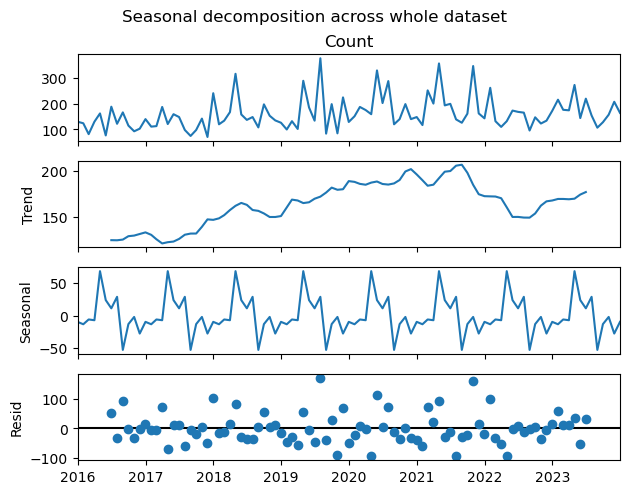

Seasonal Strength: 0.2165
F-test result: F-value = 531.6600, p-value = 0.0000
The seasonal component is statistically significant.


In [99]:
def plot_and_quantify_seasonality(data, period=12):
    data_overall = data.set_index('Publicatiemaand')['Count'].resample('M').sum()
    data_overall = data_overall.interpolate()
    
    result = seasonal_decompose(data_overall, model='additive', period=period)
    result.plot()
    plt.suptitle('Seasonal decomposition across whole dataset', y=1.02)
    plt.show()
    
    seasonal_strength = np.var(result.seasonal.dropna()) / np.var(result.observed.dropna())
    print(f"Seasonal Strength: {seasonal_strength:.4f}")
    
    seasonal_component = result.seasonal.dropna()
    trend_component = result.trend.dropna()
    resid_component = result.resid.dropna()
    min_length = min(len(seasonal_component), len(trend_component), len(resid_component))
    seasonal_component = seasonal_component[:min_length]
    trend_component = trend_component[:min_length]
    resid_component = resid_component[:min_length]
    
    anova_result = f_oneway(seasonal_component, trend_component, resid_component)
    print(f"F-test result: F-value = {anova_result.statistic:.4f}, p-value = {anova_result.pvalue:.4f}")
    
    # F-test result
    if anova_result.pvalue < 0.05:
        print("The seasonal component is statistically significant.")
    else:
        print("The seasonal component is not statistically significant.")
    
    return result, data_overall, seasonal_strength, anova_result


result, temporal_data, seasonal_strength, anova_result = plot_and_quantify_seasonality(df_grouped)


In [100]:
seasonal = result.seasonal
mean_seasonal = seasonal.mean()
peak_periods = seasonal[seasonal > mean_seasonal].index
offpeak_periods = seasonal[seasonal <= mean_seasonal].index

# print(f'Peak periods: {peak_periods}')
# print(f'Off-peak periods: {offpeak_periods}')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


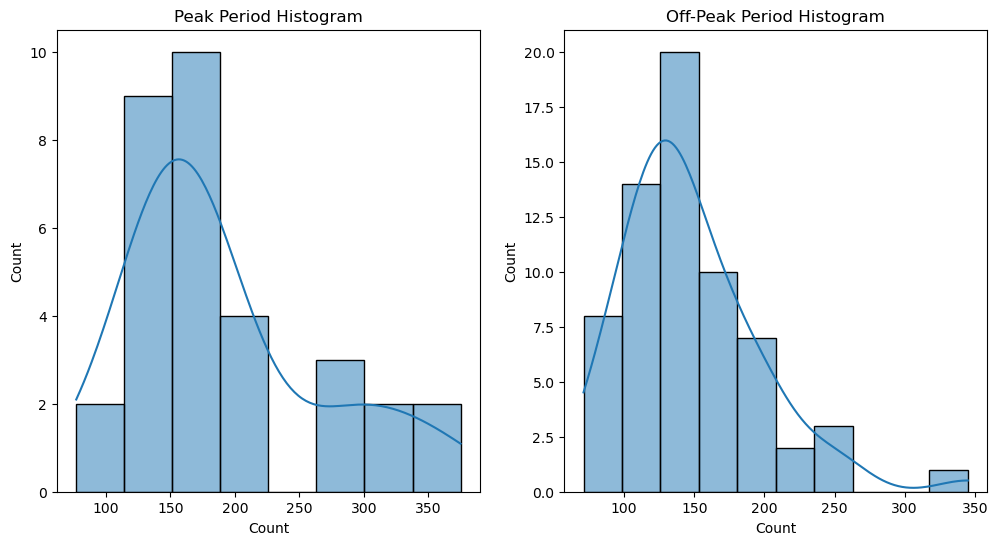

In [101]:
# check if we can validate the assumptions for the T-test
data_peak = temporal_data.loc[peak_periods]
data_off_peak = temporal_data.loc[offpeak_periods]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data_peak, kde=True)
plt.title('Peak Period Histogram')
plt.subplot(1, 2, 2)
sns.histplot(data_off_peak, kde=True)
plt.title('Off-Peak Period Histogram')
plt.show()

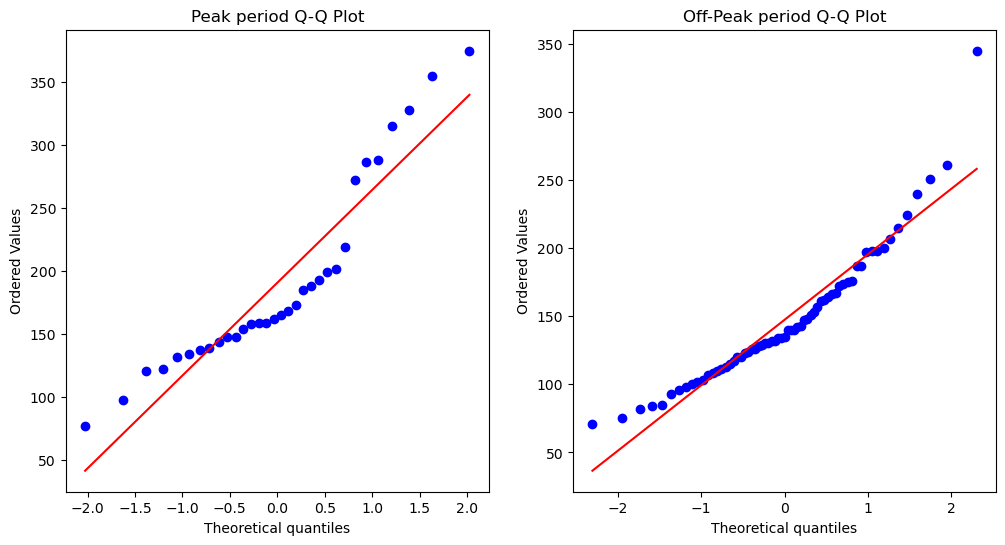

In [102]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
stats.probplot(data_peak, dist="norm", plot=plt)
plt.title('Peak period Q-Q Plot')
plt.subplot(1, 2, 2)
stats.probplot(data_off_peak, dist="norm", plot=plt)
plt.title('Off-Peak period Q-Q Plot')
plt.show()

In [103]:
# Shapiro-Wilk test
shapiro_peak = shapiro(data_peak)
shapiro_off_peak = shapiro(data_off_peak)
print(f'Shapiro-Wilk Test Peak: Statistic={shapiro_peak[0]}, p-value={shapiro_peak[1]}')
print(f'Shapiro-Wilk Test Off-Peak: Statistic={shapiro_off_peak[0]}, p-value={shapiro_off_peak[1]}')

# Levene's test for homogeneity of variances
levene_test = levene(data_peak, data_off_peak)
print(f'Levene\'s Test: Statistic={levene_test[0]}, p-value={levene_test[1]}')

Shapiro-Wilk Test Peak: Statistic=0.8790083527565002, p-value=0.0018866192549467087
Shapiro-Wilk Test Off-Peak: Statistic=0.9166953563690186, p-value=0.0003250213630963117
Levene's Test: Statistic=3.4147934049926727, p-value=0.06772588703276408


In [104]:
# If assumptions are met, perform t-test
if shapiro_peak[1] > 0.05 and shapiro_off_peak[1] > 0.05 and levene_test[1] > 0.05:
    t_test = ttest_ind(data_peak, data_off_peak)
    print(f'T-Test: Statistic={t_test[0]}, p-value={t_test[1]}')
else:
    # If assumptions are not met, consider non-parametric test
    mwu_test = mannwhitneyu(data_peak, data_off_peak)
    print(f'Mann-Whitney U Test: Statistic={mwu_test[0]}, p-value={mwu_test[1]}')


Mann-Whitney U Test: Statistic=1436.0, p-value=0.002407142155453474


### Per CPV code

Now we will also do it per CPV code.

In [106]:
print(df_lowrisk.columns)

Index(['Id publicatie', 'Tenderned kenmerk', 'Publicatiedatum',
       'Publicatiemaand', 'Publicatiemaand_kwartaal', 'Publicatiemaand_jaar',
       'Naam Aanbestedende dienst', 'Cleaned name AB', 'Category AD',
       'Nationaal identificatienummer', 'Naam aanbesteding', 'URL TenderNed',
       'Geimporteerd', 'Tsender', 'Aanbesteding id',
       'Sluitingsdatum aanmelding', 'Sluitingsdatum aanmelding_kwartaal',
       'Sluitingsdatum aanmelding_jaar', 'Sluitingsdatum aanbesteding',
       'Sluitingsdatum aanbesteding_kwartaal',
       'Sluitingsdatum aanbesteding_jaar', 'Aanvang opdracht',
       'Aanvang opdracht_kwartaal', 'Aanvang opdracht_jaar',
       'Voltooiing opdracht', 'Voltooiing opdracht_kwartaal',
       'Voltooiing opdracht_jaar', 'Termijn verkrijgen documenten',
       'Termijn verkrijgen documenten_kwartaal',
       'Termijn verkrijgen documenten_jaar', 'Verzending uitnodigingen',
       'Verzending uitnodigingen_kwartaal', 'Verzending uitnodigingen_jaar',
       'Teg

In [107]:
df_lowrisk['Publicatiemaand'] = pd.to_datetime(df_lowrisk['Publicatiemaand'])

/var/folders/gs/nl34jk5j4p78xt66f6906_b80000gn/T/ipykernel_3916/1314238919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowrisk['Publicatiemaand'] = pd.to_datetime(df_lowrisk['Publicatiemaand'])


In [108]:
def analyze_and_generate_report(df):
    unique_cpv_codes = df['Hoofd CPV code'].unique()
    reports = []
    num_comparisons = len(unique_cpv_codes)  # For Bonferroni correction

    for cpv_code in unique_cpv_codes:
        df_cpv = df[df['Hoofd CPV code'] == cpv_code]
        df_grouped = df_cpv.groupby(['Publicatiemaand', 'Hoofd CPV code']).size().reset_index(name='Count')

        # Step 1: Plot and quantify seasonality
        data_overall = df_grouped.set_index('Publicatiemaand')['Count'].resample('M').sum()
        data_overall = data_overall.interpolate()
        result = seasonal_decompose(data_overall, model='additive', period=12)
        result.plot()
        plt.suptitle(f'Seasonal decomposition for CPV Code {cpv_code}', y=1.02)
        plt.show()

        seasonal_strength = np.var(result.seasonal.dropna()) / np.var(result.observed.dropna())
        print(f"Seasonal Strength: {seasonal_strength:.4f}")

        seasonal_component = result.seasonal.dropna()
        trend_component = result.trend.dropna()
        resid_component = result.resid.dropna()
        min_length = min(len(seasonal_component), len(trend_component), len(resid_component))
        seasonal_component = seasonal_component[:min_length]
        trend_component = trend_component[:min_length]
        resid_component = resid_component[:min_length]

        anova_result = f_oneway(seasonal_component, trend_component, resid_component)
        print(f"F-test result: F-value = {anova_result.statistic:.4f}, p-value = {anova_result.pvalue:.4f}")

        if anova_result.pvalue < 0.05:
            print("The seasonal component is statistically significant.")
        else:
            print("The seasonal component is not statistically significant.")

        # Step 2: Identify peak and off-peak periods
        seasonal = result.seasonal
        mean_seasonal = seasonal.mean()
        peak_periods = seasonal[seasonal > mean_seasonal].index
        offpeak_periods = seasonal[seasonal <= mean_seasonal].index

        # Step 3: Identify peak and off-peak data
        imputed_data = df_cpv.set_index('Publicatiemaand')['Aantal inschrijvingen IMPUTED']
        imputed_data.index = pd.to_datetime(imputed_data.index)
        imputed_data = imputed_data.resample('M').sum().interpolate()
        peak_values = imputed_data.loc[peak_periods].dropna()
        offpeak_values = imputed_data.loc[offpeak_periods].dropna()

        # Step 4: Plot histograms and Q-Q plots
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(peak_values, kde=True)
        plt.title(f'Peak Period Histogram for CPV Code: {cpv_code}')
        plt.subplot(1, 2, 2)
        sns.histplot(offpeak_values, kde=True)
        plt.title(f'Off-Peak Period Histogram for CPV Code: {cpv_code}')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        stats.probplot(peak_values, dist="norm", plot=plt)
        plt.title(f'Peak Period Q-Q Plot for CPV Code: {cpv_code}')
        plt.subplot(1, 2, 2)
        stats.probplot(offpeak_values, dist="norm", plot=plt)
        plt.title(f'Off-Peak Period Q-Q Plot for CPV Code: {cpv_code}')
        plt.show()

        # Step 5: Shapiro-Wilk test
        shapiro_peak = shapiro(peak_values)
        shapiro_off_peak = shapiro(offpeak_values)
        print(f'Shapiro-Wilk Test Peak for CPV Code {cpv_code}: Statistic={shapiro_peak[0]}, p-value={shapiro_peak[1]}')
        print(f'Shapiro-Wilk Test Off-Peak for CPV Code {cpv_code}: Statistic={shapiro_off_peak[0]}, p-value={shapiro_off_peak[1]}')

        # Step 6: Levene's test for homogeneity of variances
        levene_test = levene(peak_values, offpeak_values)
        print(f'Levene\'s Test for CPV Code {cpv_code}: Statistic={levene_test[0]}, p-value={levene_test[1]}')

        # Step 7: T-test or Mann-Whitney U test
        if shapiro_peak[1] > 0.05 and shapiro_off_peak[1] > 0.05 and levene_test[1] > 0.05:
            t_test = ttest_ind(peak_values, offpeak_values)
            mwu_test = None
            print(f'T-Test for CPV Code {cpv_code}: Statistic={t_test[0]}, p-value={t_test[1]}')
        else:
            t_test = None
            mwu_test = mannwhitneyu(peak_values, offpeak_values)
            print(f'Mann-Whitney U Test for CPV Code {cpv_code}: Statistic={mwu_test[0]}, p-value={mwu_test[1]}')

        # Step 8: Apply Bonferroni correction
        bonferroni_p_val = min(mwu_test.pvalue * num_comparisons, 1.0) if mwu_test else None

        # Step 9: Generate the report
        report = f"Report on the statistical difference and seasonality for CPV Code: {cpv_code}\n\n"
        report += f"Seasonal Strength: {seasonal_strength:.4f}\n"
        report += f"ANOVA F-test result: F-value = {anova_result.statistic:.4f}, p-value = {anova_result.pvalue:.4f}\n\n"

        report += f"Shapiro-Wilk Test Peak: Statistic={shapiro_peak[0]}, p-value={shapiro_peak[1]}\n"
        report += f"Shapiro-Wilk Test Off-Peak: Statistic={shapiro_off_peak[0]}, p-value={shapiro_off_peak[1]}\n\n"
        report += f"Levene's Test: Statistic={levene_test[0]}, p-value={levene_test[1]}\n\n"

        if t_test:
            report += f"T-Test: Statistic={t_test[0]}, p-value={t_test[1]}\n"
        else:
            report += f"Mann-Whitney U Test: Statistic={mwu_test[0]}, p-value={mwu_test[1]}, Bonferroni corrected p-value={bonferroni_p_val}\n"

        report += "\nConclusion:\n"
        if bonferroni_p_val < 0.05:
            report += f"The value of 'Aantal inschrijvingen IMPUTED' is statistically significantly different between peak and off-peak periods for CPV code {cpv_code}. "
            report += "This suggests that the Rijkswaterstaat can optimize the publication of their procurement contracts by considering these periods, as tenders tend to get on average a higher amount of registrations during peak periods."
        else:
            report += f"There is no statistically significant difference in the value of 'Aantal inschrijvingen IMPUTED' between peak and off-peak periods for CPV code {cpv_code}. It makes no difference to publicize in peak or off-peak seasons.\n"

        peak_months = [date.strftime('%B') for date in peak_periods]
        offpeak_months = [date.strftime('%B') for date in offpeak_periods]

        peak_month_common = pd.Series(peak_months).mode().tolist()
        offpeak_month_common = pd.Series(offpeak_months).mode().tolist()

        report += "\nAverage Peak Season Months:\n"
        report += ", ".join(peak_month_common)
        
        report += "\n\nAverage Off-Peak Season Months:\n"
        report += ", ".join(offpeak_month_common)
        
        reports.append(report)

    return reports


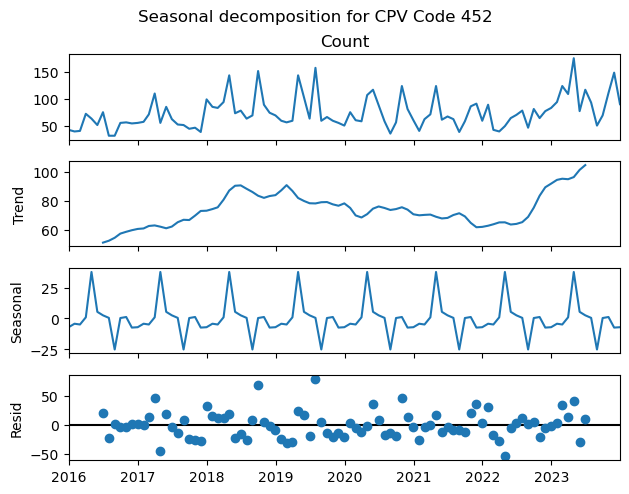

Seasonal Strength: 0.2050
F-test result: F-value = 547.9394, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


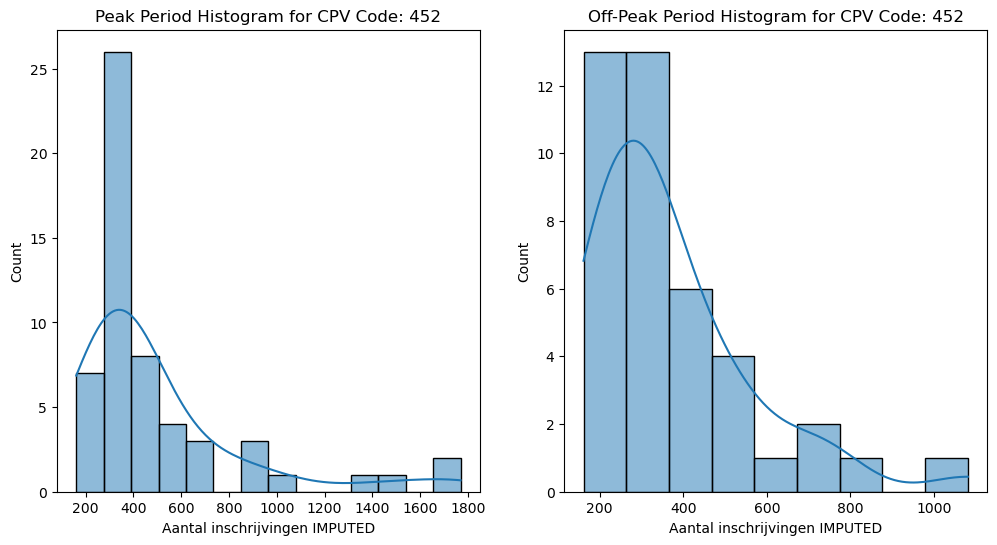

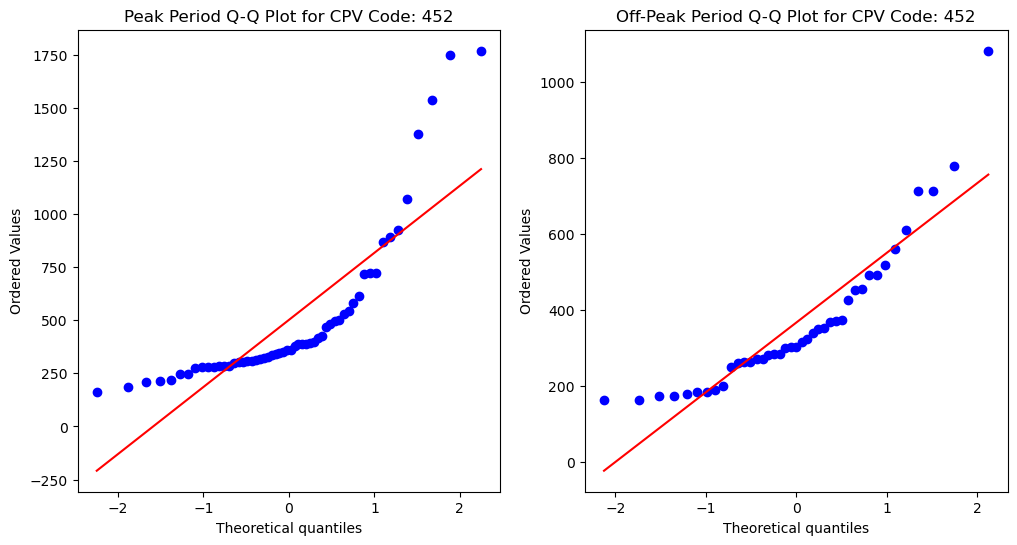

Shapiro-Wilk Test Peak for CPV Code 452: Statistic=0.7073091268539429, p-value=2.908447482852239e-09
Shapiro-Wilk Test Off-Peak for CPV Code 452: Statistic=0.8409441709518433, p-value=4.522315430222079e-05
Levene's Test for CPV Code 452: Statistic=2.246267284731495, p-value=0.13725286698868167
Mann-Whitney U Test for CPV Code 452: Statistic=1455.5, p-value=0.024954663086343143


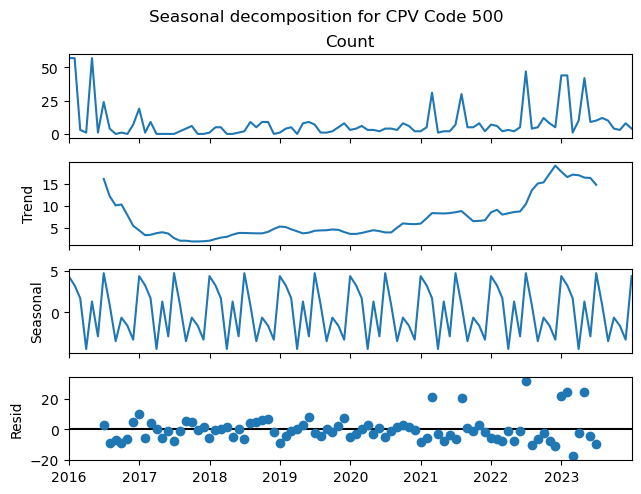

Seasonal Strength: 0.0558
F-test result: F-value = 42.3051, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


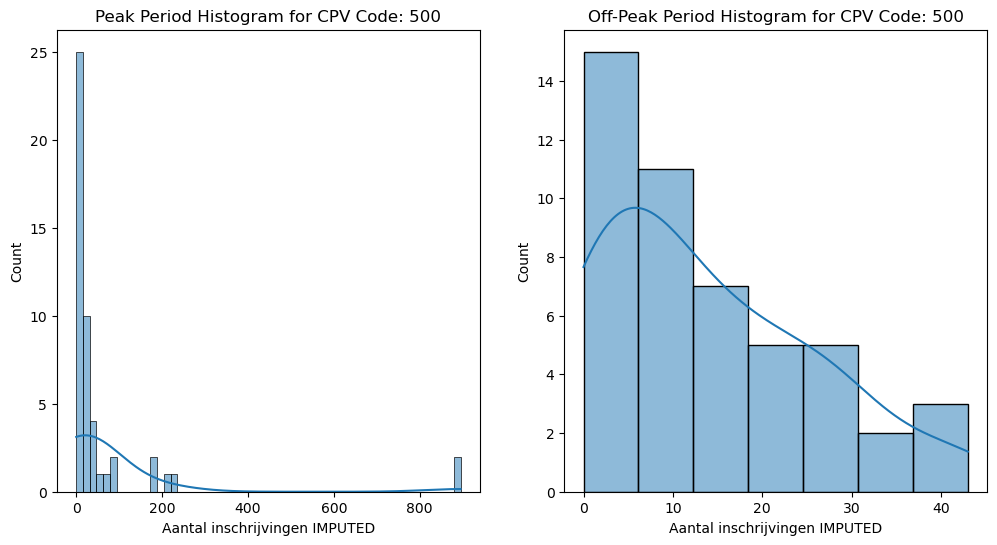

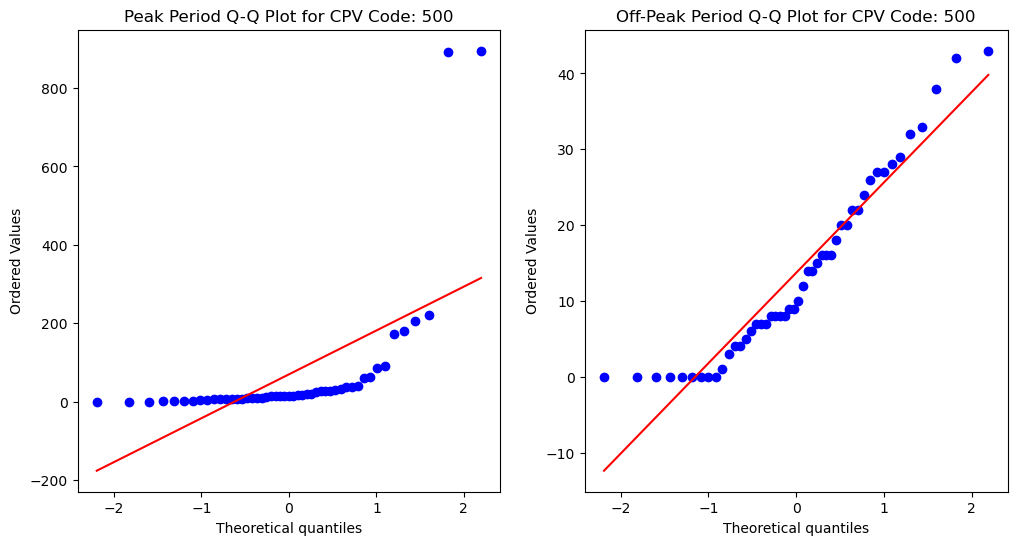

Shapiro-Wilk Test Peak for CPV Code 500: Statistic=0.3842788338661194, p-value=4.817354739942992e-13
Shapiro-Wilk Test Off-Peak for CPV Code 500: Statistic=0.9119828939437866, p-value=0.0015686418628320098
Levene's Test for CPV Code 500: Statistic=4.3146266540003, p-value=0.04048481987862637
Mann-Whitney U Test for CPV Code 500: Statistic=1473.0, p-value=0.03215762000373326


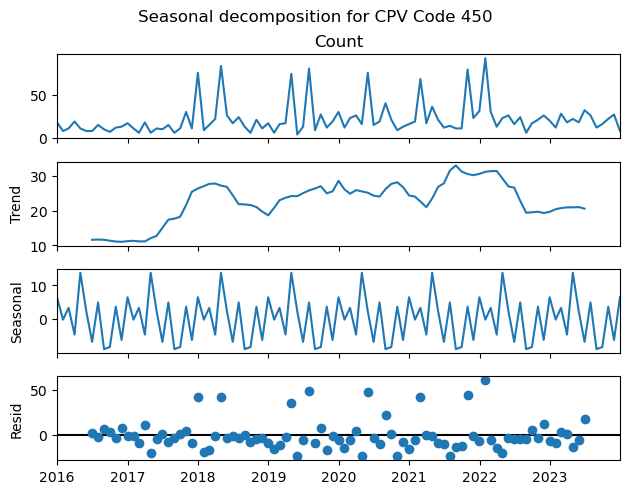

Seasonal Strength: 0.1307
F-test result: F-value = 115.9543, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


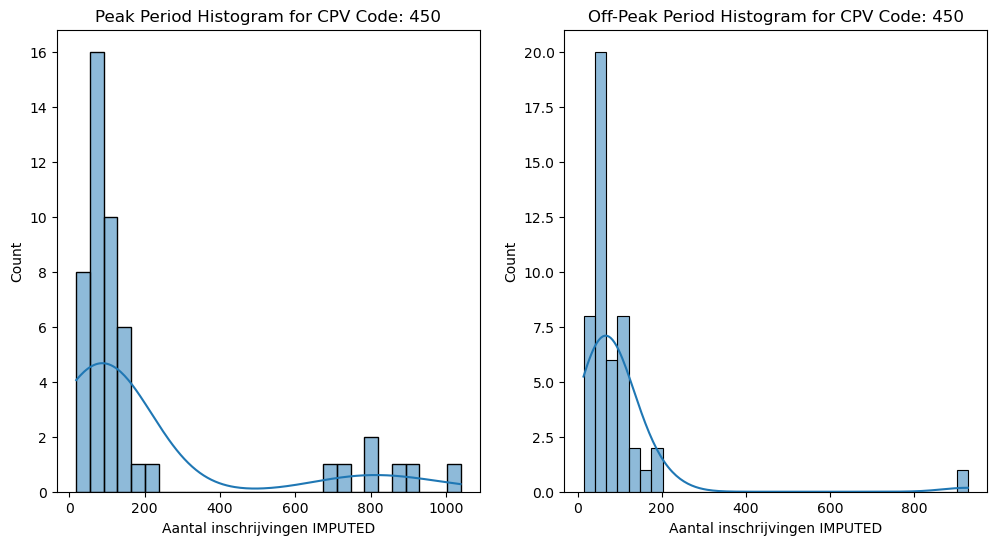

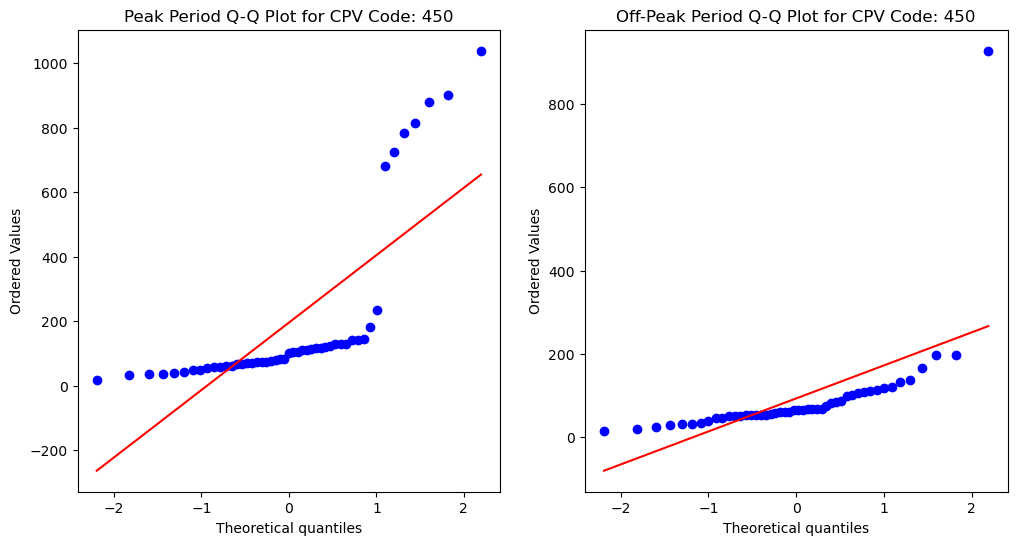

Shapiro-Wilk Test Peak for CPV Code 450: Statistic=0.5754119157791138, p-value=1.1199090960145597e-10
Shapiro-Wilk Test Off-Peak for CPV Code 450: Statistic=0.38058942556381226, p-value=6.00747045425426e-13
Levene's Test for CPV Code 450: Statistic=4.903957961501124, p-value=0.029186399288980838
Mann-Whitney U Test for CPV Code 450: Statistic=1557.0, p-value=0.00603581313288542


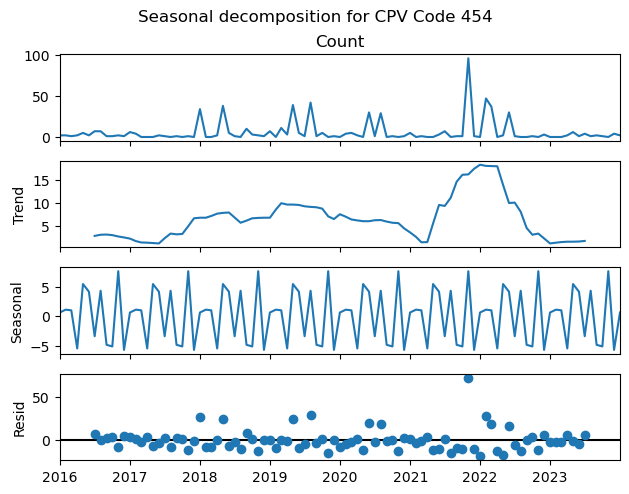

Seasonal Strength: 0.1071
F-test result: F-value = 17.7760, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


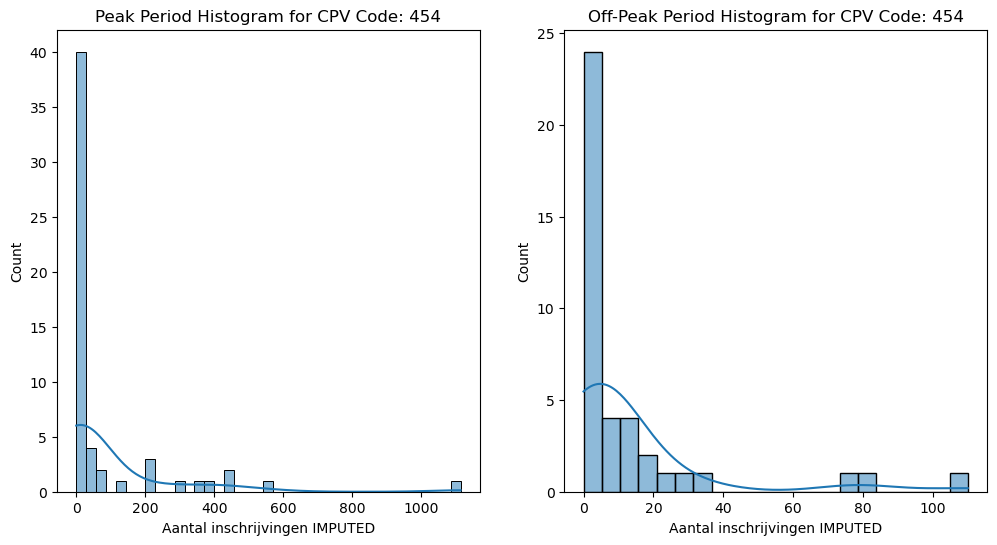

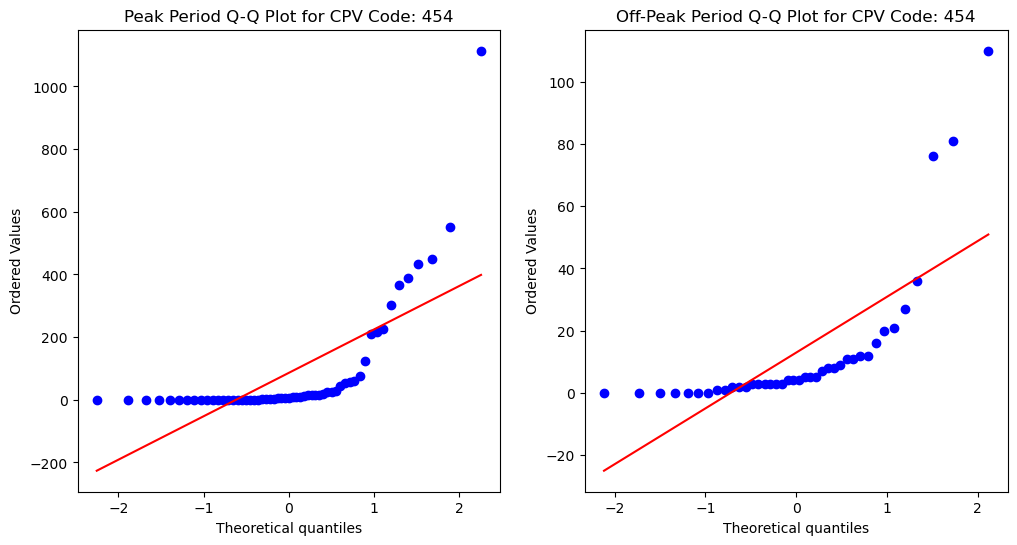

Shapiro-Wilk Test Peak for CPV Code 454: Statistic=0.512062132358551, p-value=1.743354267370878e-12
Shapiro-Wilk Test Off-Peak for CPV Code 454: Statistic=0.5543692111968994, p-value=7.846591154603288e-10
Levene's Test for CPV Code 454: Statistic=5.977894525168491, p-value=0.01632920689948658
Mann-Whitney U Test for CPV Code 454: Statistic=1236.5, p-value=0.47620033767560344


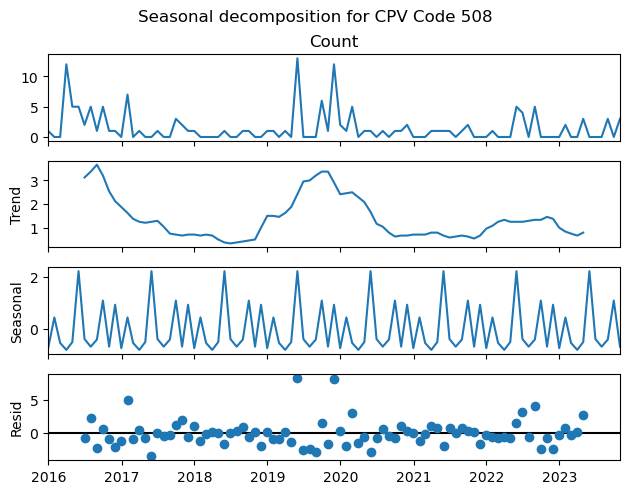

Seasonal Strength: 0.1316
F-test result: F-value = 27.9512, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


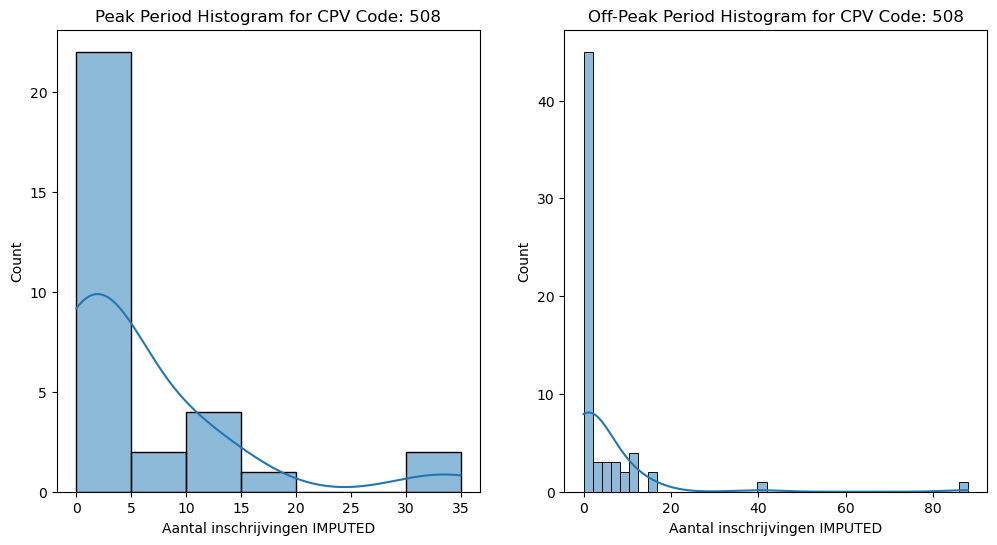

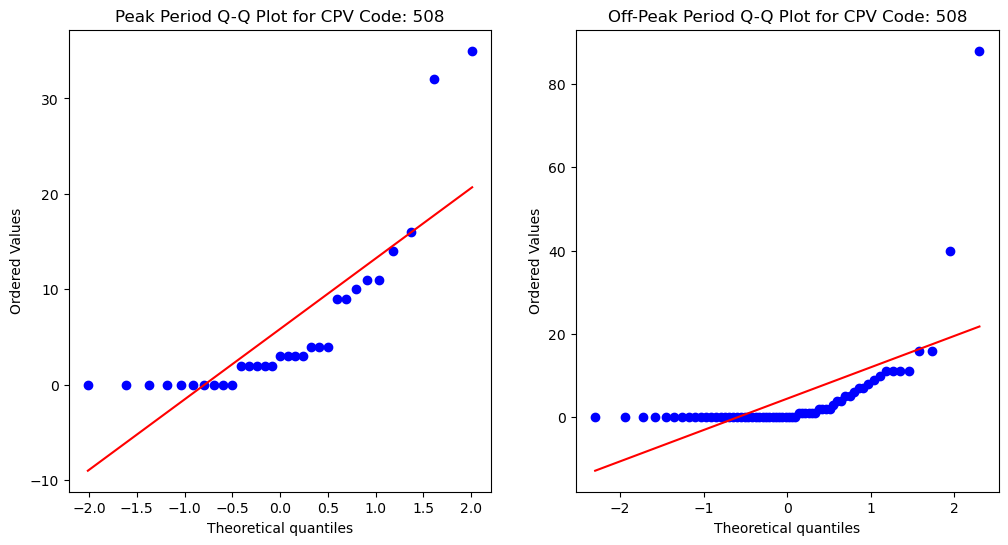

Shapiro-Wilk Test Peak for CPV Code 508: Statistic=0.6811647415161133, p-value=6.200440338943736e-07
Shapiro-Wilk Test Off-Peak for CPV Code 508: Statistic=0.3795955181121826, p-value=5.646477480459461e-15
Levene's Test for CPV Code 508: Statistic=0.06808889007601795, p-value=0.7947168962036506
Mann-Whitney U Test for CPV Code 508: Statistic=1238.5, p-value=0.038698613868403384


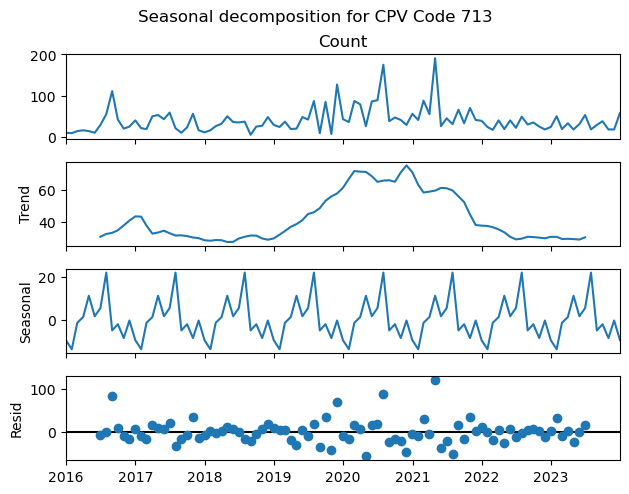

Seasonal Strength: 0.0880
F-test result: F-value = 141.2035, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


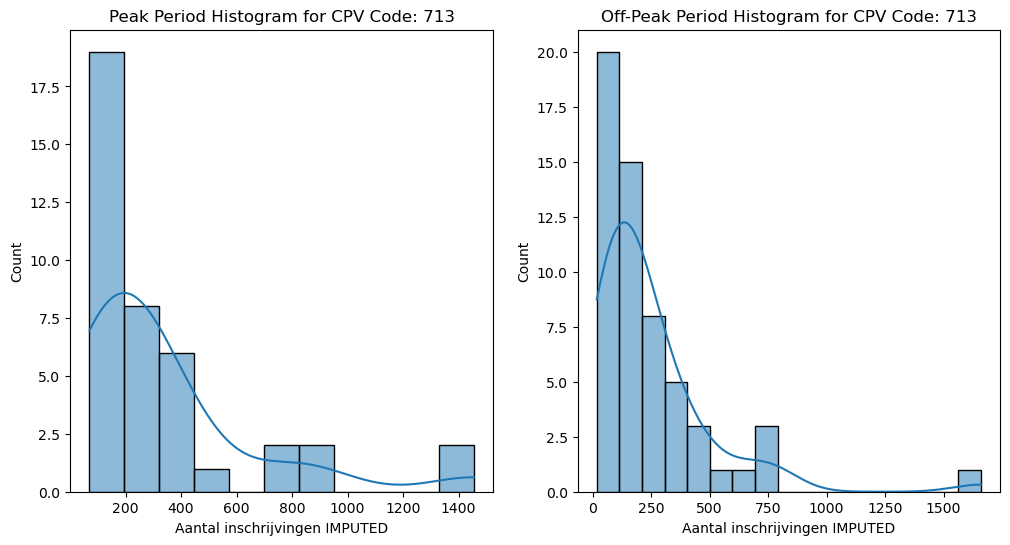

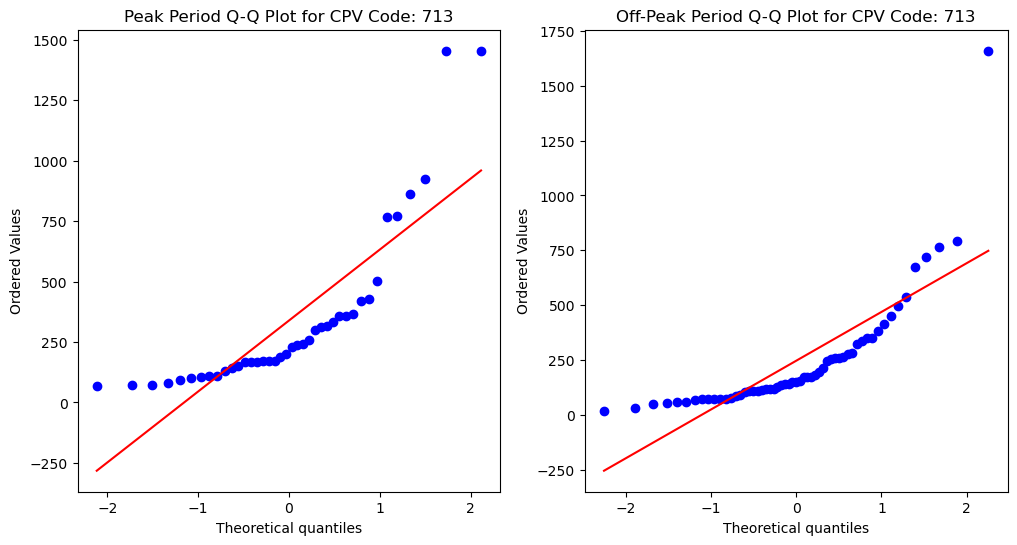

Shapiro-Wilk Test Peak for CPV Code 713: Statistic=0.7146017551422119, p-value=1.7043068112343462e-07
Shapiro-Wilk Test Off-Peak for CPV Code 713: Statistic=0.6777516007423401, p-value=6.597954405052064e-10
Levene's Test for CPV Code 713: Statistic=0.9128078212666184, p-value=0.3417954133389757
Mann-Whitney U Test for CPV Code 713: Statistic=1401.5, p-value=0.055772238368456434


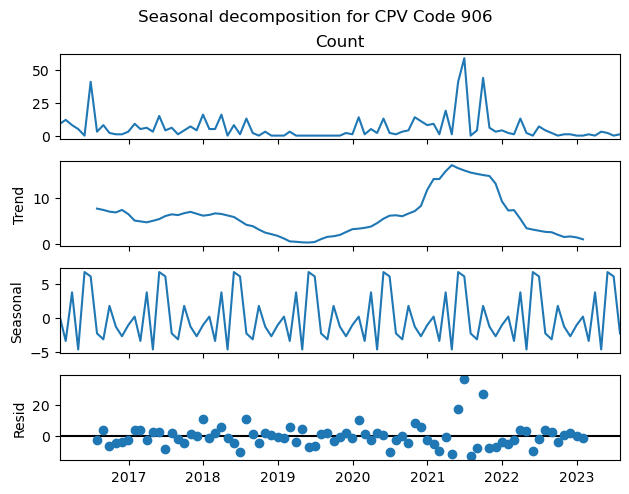

Seasonal Strength: 0.1426
F-test result: F-value = 32.0500, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


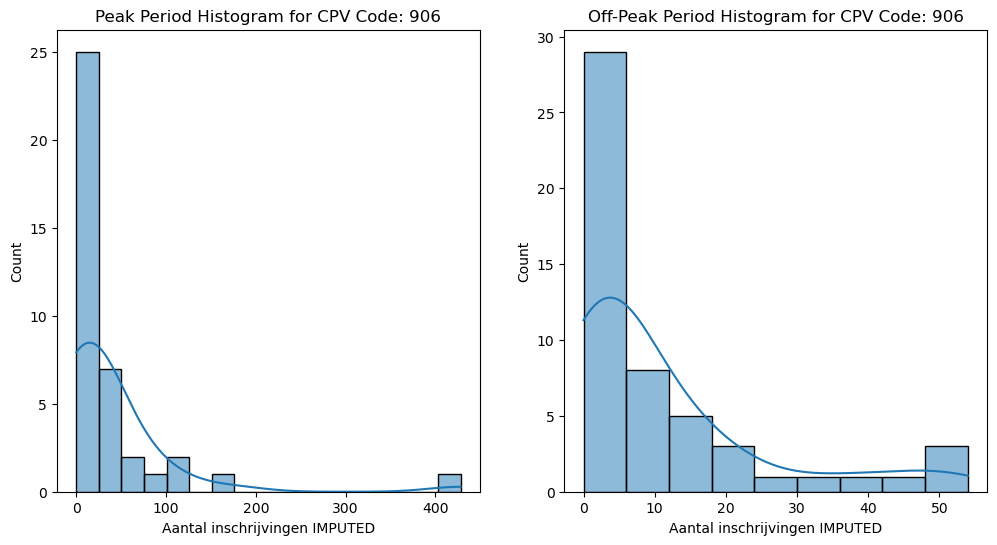

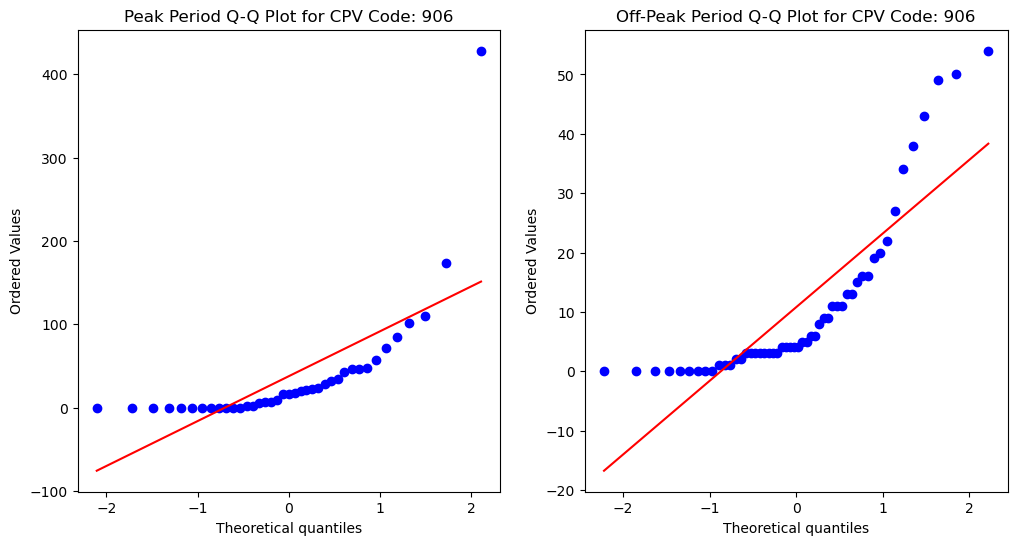

Shapiro-Wilk Test Peak for CPV Code 906: Statistic=0.5170064568519592, p-value=3.7273067965415407e-10
Shapiro-Wilk Test Off-Peak for CPV Code 906: Statistic=0.7356533408164978, p-value=2.4710038459829775e-08
Levene's Test for CPV Code 906: Statistic=7.131062258129983, p-value=0.009006218906879747
Mann-Whitney U Test for CPV Code 906: Statistic=1205.5, p-value=0.1230422635493933


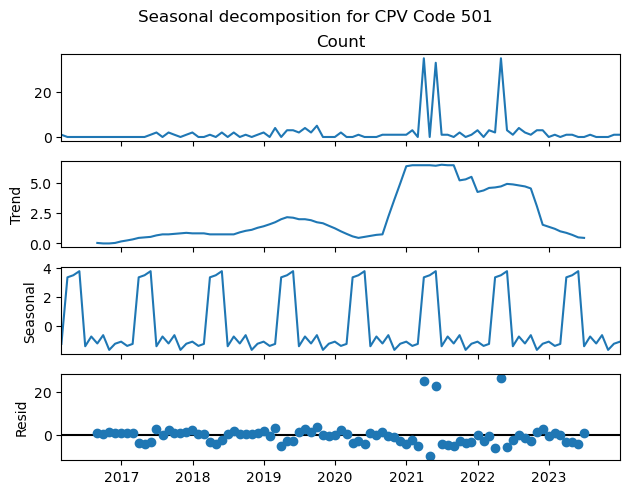

Seasonal Strength: 0.1193
F-test result: F-value = 10.7519, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


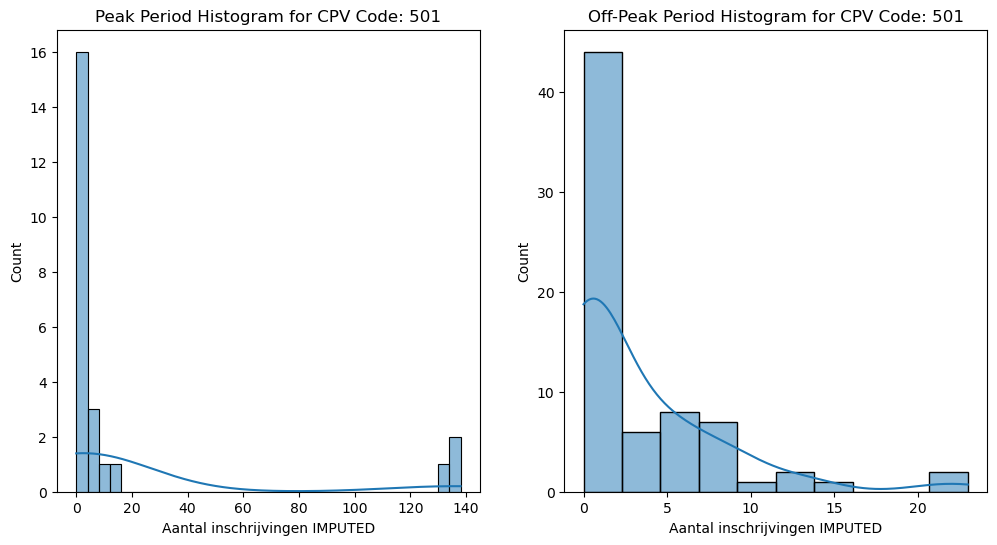

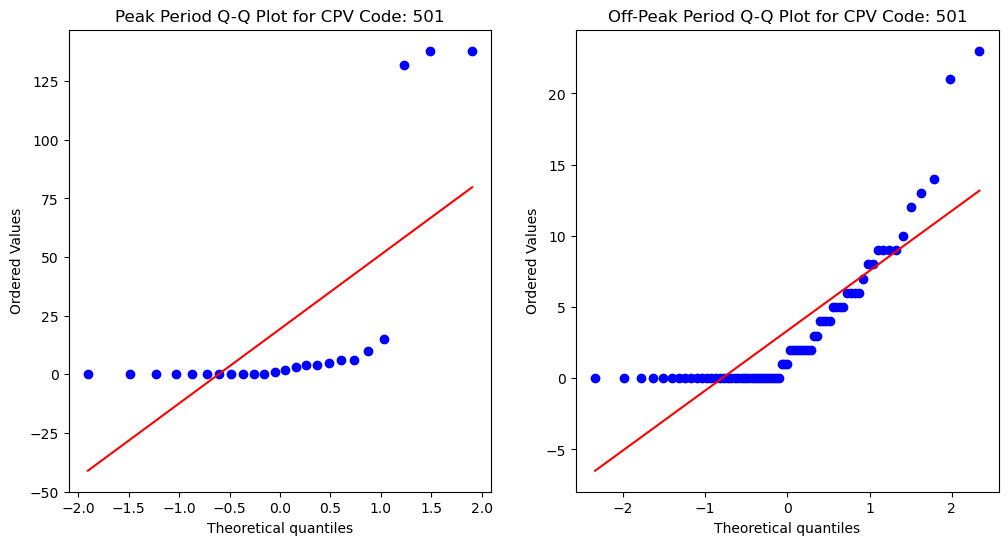

Shapiro-Wilk Test Peak for CPV Code 501: Statistic=0.4560436010360718, p-value=2.1672347472190268e-08
Shapiro-Wilk Test Off-Peak for CPV Code 501: Statistic=0.7255467176437378, p-value=3.256410419094635e-10
Levene's Test for CPV Code 501: Statistic=9.060502250642354, p-value=0.003361872300622904
Mann-Whitney U Test for CPV Code 501: Statistic=908.5, p-value=0.6129618904312515


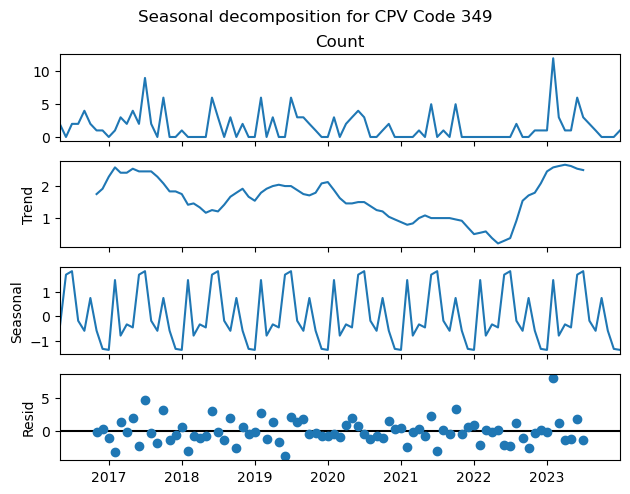

Seasonal Strength: 0.2562
F-test result: F-value = 41.3454, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


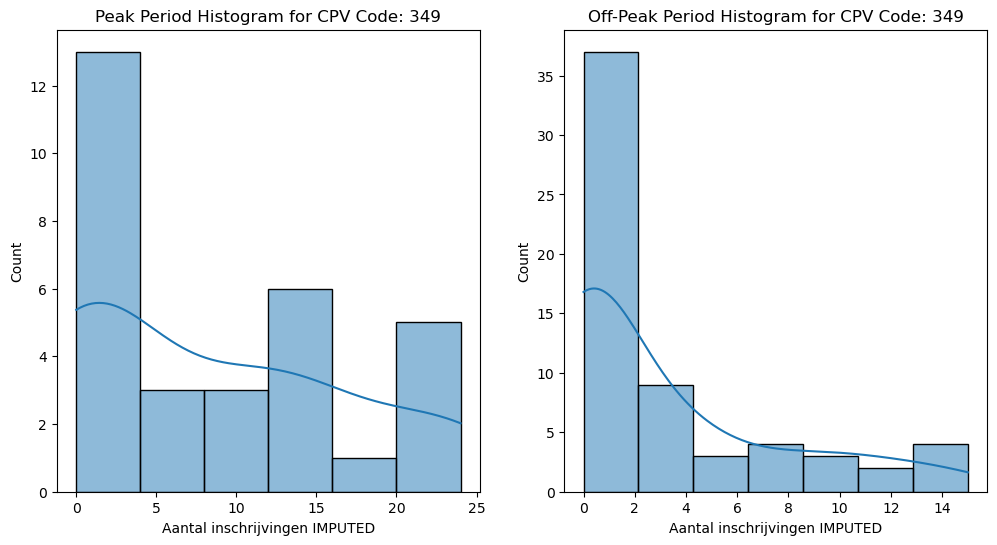

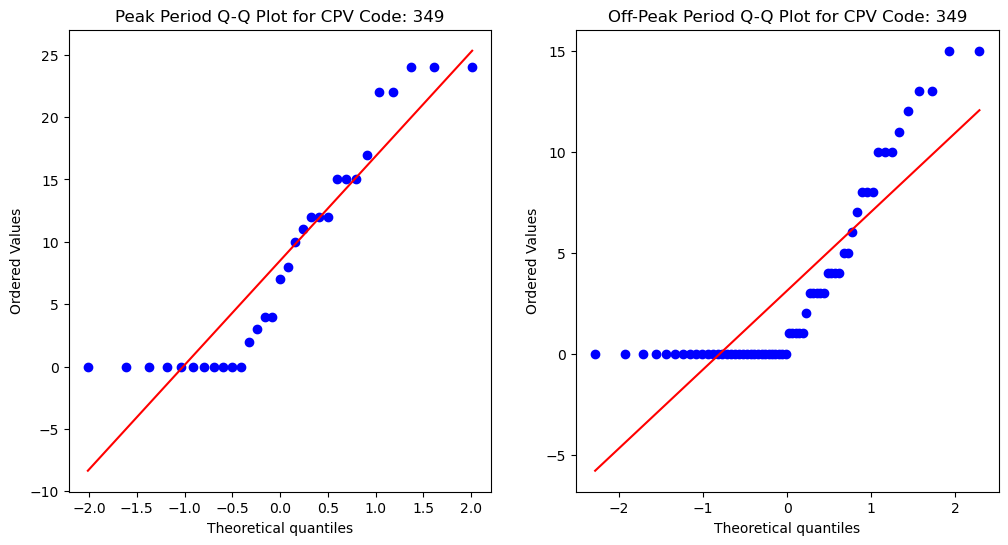

Shapiro-Wilk Test Peak for CPV Code 349: Statistic=0.8494899868965149, p-value=0.0004941312363371253
Shapiro-Wilk Test Off-Peak for CPV Code 349: Statistic=0.7408999800682068, p-value=3.9896352888035835e-09
Levene's Test for CPV Code 349: Statistic=21.44785431385677, p-value=1.205415524997031e-05
Mann-Whitney U Test for CPV Code 349: Statistic=1274.0, p-value=0.007484315064306372
Report on the statistical difference and seasonality for CPV Code: 452

Seasonal Strength: 0.2050
ANOVA F-test result: F-value = 547.9394, p-value = 0.0000

Shapiro-Wilk Test Peak: Statistic=0.7073091268539429, p-value=2.908447482852239e-09
Shapiro-Wilk Test Off-Peak: Statistic=0.8409441709518433, p-value=4.522315430222079e-05

Levene's Test: Statistic=2.246267284731495, p-value=0.13725286698868167

Mann-Whitney U Test: Statistic=1455.5, p-value=0.024954663086343143, Bonferroni corrected p-value=0.22459196777708829

Conclusion:
There is no statistically significant difference in the value of 'Aantal inschrijvi

In [ ]:
reports = analyze_and_generate_report(df_lowrisk)
for report in reports:
    print(report)

## High risk

### Across whole dataset

Same as before, we are going to copy as much as possible from the first code, only replace the filtered_df_highrisk dataframe, without the outlier.

In [109]:
df_grouped = df_highrisk.groupby(['Publicatiemaand', 'Hoofd CPV code']).size().reset_index(name='Count') 
df_grouped.head(5)

Publicatiemaand  Hoofd CPV code  Count
0      2015-12-01             451      5
1      2015-12-01             453      3
2      2015-12-01             502      8
3      2015-12-01             507      1
4      2016-01-01             451      9

In [110]:
def analyze_and_generate_report(df):
    unique_cpv_codes = df['Hoofd CPV code'].unique()
    reports = []
    num_comparisons = len(unique_cpv_codes)  # For Bonferroni correction

    for cpv_code in unique_cpv_codes:
        df_cpv = df[df['Hoofd CPV code'] == cpv_code]
        df_grouped = df_cpv.groupby(['Publicatiemaand', 'Hoofd CPV code']).size().reset_index(name='Count')

        # Step 1: Plot and quantify seasonality
        data_overall = df_grouped.set_index('Publicatiemaand')['Count'].resample('M').sum()
        data_overall = data_overall.interpolate()
        result = seasonal_decompose(data_overall, model='additive', period=12)
        result.plot()
        plt.suptitle(f'Seasonal decomposition for CPV Code {cpv_code}', y=1.02)
        plt.show()

        seasonal_strength = np.var(result.seasonal.dropna()) / np.var(result.observed.dropna())
        print(f"Seasonal Strength: {seasonal_strength:.4f}")

        seasonal_component = result.seasonal.dropna()
        trend_component = result.trend.dropna()
        resid_component = result.resid.dropna()
        min_length = min(len(seasonal_component), len(trend_component), len(resid_component))
        seasonal_component = seasonal_component[:min_length]
        trend_component = trend_component[:min_length]
        resid_component = resid_component[:min_length]

        anova_result = f_oneway(seasonal_component, trend_component, resid_component)
        print(f"F-test result: F-value = {anova_result.statistic:.4f}, p-value = {anova_result.pvalue:.4f}")

        if anova_result.pvalue < 0.05:
            print("The seasonal component is statistically significant.")
        else:
            print("The seasonal component is not statistically significant.")

        # Step 2: Identify peak and off-peak periods
        seasonal = result.seasonal
        mean_seasonal = seasonal.mean()
        peak_periods = seasonal[seasonal > mean_seasonal].index
        offpeak_periods = seasonal[seasonal <= mean_seasonal].index

        # Step 3: Identify peak and off-peak data
        imputed_data = df_cpv.set_index('Publicatiemaand')['Aantal inschrijvingen IMPUTED']
        imputed_data.index = pd.to_datetime(imputed_data.index)
        imputed_data = imputed_data.resample('M').sum().interpolate()
        peak_values = imputed_data.loc[peak_periods].dropna()
        offpeak_values = imputed_data.loc[offpeak_periods].dropna()

        # Step 4: Plot histograms and Q-Q plots
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(peak_values, kde=True)
        plt.title(f'Peak Period Histogram for CPV Code: {cpv_code}')
        plt.subplot(1, 2, 2)
        sns.histplot(offpeak_values, kde=True)
        plt.title(f'Off-Peak Period Histogram for CPV Code: {cpv_code}')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        stats.probplot(peak_values, dist="norm", plot=plt)
        plt.title(f'Peak Period Q-Q Plot for CPV Code: {cpv_code}')
        plt.subplot(1, 2, 2)
        stats.probplot(offpeak_values, dist="norm", plot=plt)
        plt.title(f'Off-Peak Period Q-Q Plot for CPV Code: {cpv_code}')
        plt.show()

        # Step 5: Shapiro-Wilk test
        shapiro_peak = shapiro(peak_values)
        shapiro_off_peak = shapiro(offpeak_values)
        print(f'Shapiro-Wilk Test Peak for CPV Code {cpv_code}: Statistic={shapiro_peak[0]}, p-value={shapiro_peak[1]}')
        print(f'Shapiro-Wilk Test Off-Peak for CPV Code {cpv_code}: Statistic={shapiro_off_peak[0]}, p-value={shapiro_off_peak[1]}')

        # Step 6: Levene's test for homogeneity of variances
        levene_test = levene(peak_values, offpeak_values)
        print(f'Levene\'s Test for CPV Code {cpv_code}: Statistic={levene_test[0]}, p-value={levene_test[1]}')

        # Step 7: T-test or Mann-Whitney U test
        if shapiro_peak[1] > 0.05 and shapiro_off_peak[1] > 0.05 and levene_test[1] > 0.05:
            t_test = ttest_ind(peak_values, offpeak_values)
            mwu_test = None
            print(f'T-Test for CPV Code {cpv_code}: Statistic={t_test[0]}, p-value={t_test[1]}')
        else:
            t_test = None
            mwu_test = mannwhitneyu(peak_values, offpeak_values)
            print(f'Mann-Whitney U Test for CPV Code {cpv_code}: Statistic={mwu_test[0]}, p-value={mwu_test[1]}')

        # Step 8: Apply Bonferroni correction
        bonferroni_p_val = min(mwu_test.pvalue * num_comparisons, 1.0) if mwu_test else None

        # Step 9: Generate the report
        report = f"Report on the statistical difference and seasonality for CPV Code: {cpv_code}\n\n"
        report += f"Seasonal Strength: {seasonal_strength:.4f}\n"
        report += f"ANOVA F-test result: F-value = {anova_result.statistic:.4f}, p-value = {anova_result.pvalue:.4f}\n\n"

        report += f"Shapiro-Wilk Test Peak: Statistic={shapiro_peak[0]}, p-value={shapiro_peak[1]}\n"
        report += f"Shapiro-Wilk Test Off-Peak: Statistic={shapiro_off_peak[0]}, p-value={shapiro_off_peak[1]}\n\n"
        report += f"Levene's Test: Statistic={levene_test[0]}, p-value={levene_test[1]}\n\n"

        if t_test:
            report += f"T-Test: Statistic={t_test[0]}, p-value={t_test[1]}\n"
        else:
            report += f"Mann-Whitney U Test: Statistic={mwu_test[0]}, p-value={mwu_test[1]}, Bonferroni corrected p-value={bonferroni_p_val}\n"

        report += "\nConclusion:\n"
        if bonferroni_p_val < 0.05:
            report += f"The value of 'Aantal inschrijvingen IMPUTED' is statistically significantly different between peak and off-peak periods for CPV code {cpv_code}. "
            report += "This suggests that the Rijkswaterstaat can optimize the publication of their procurement contracts by considering these periods, as tenders tend to get on average a higher amount of registrations during peak periods."
        else:
            report += f"There is no statistically significant difference in the value of 'Aantal inschrijvingen IMPUTED' between peak and off-peak periods for CPV code {cpv_code}. It makes no difference to publicize in peak or off-peak seasons.\n"

        peak_months = [date.strftime('%B') for date in peak_periods]
        offpeak_months = [date.strftime('%B') for date in offpeak_periods]

        peak_month_common = pd.Series(peak_months).mode().tolist()
        offpeak_month_common = pd.Series(offpeak_months).mode().tolist()

        report += "\nAverage Peak Season Months:\n"
        report += ", ".join(peak_month_common)
        
        report += "\n\nAverage Off-Peak Season Months:\n"
        report += ", ".join(offpeak_month_common)
        
        reports.append(report)

    return reports


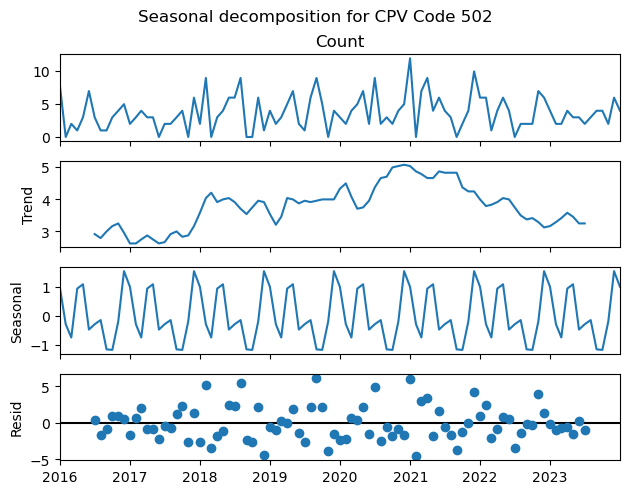

Seasonal Strength: 0.1179
F-test result: F-value = 180.3696, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


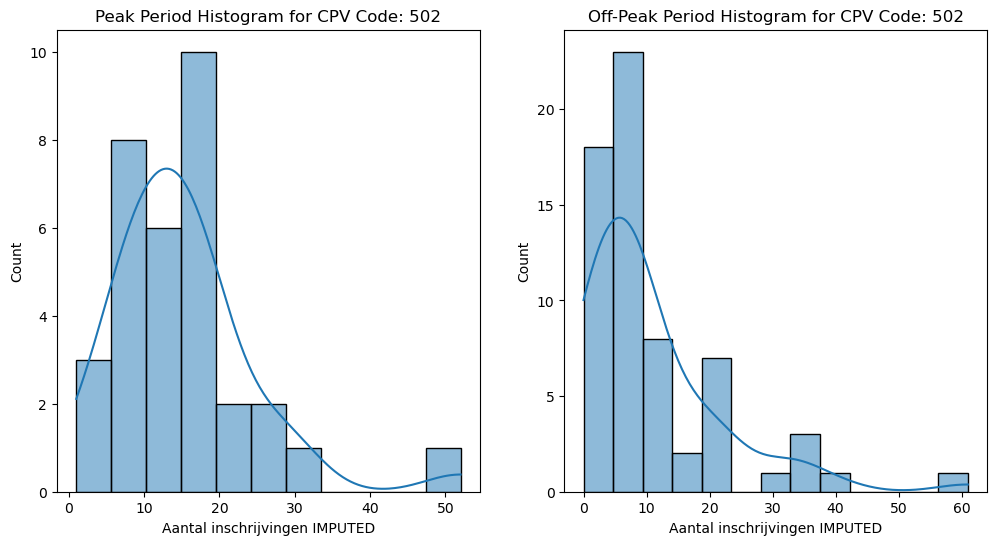

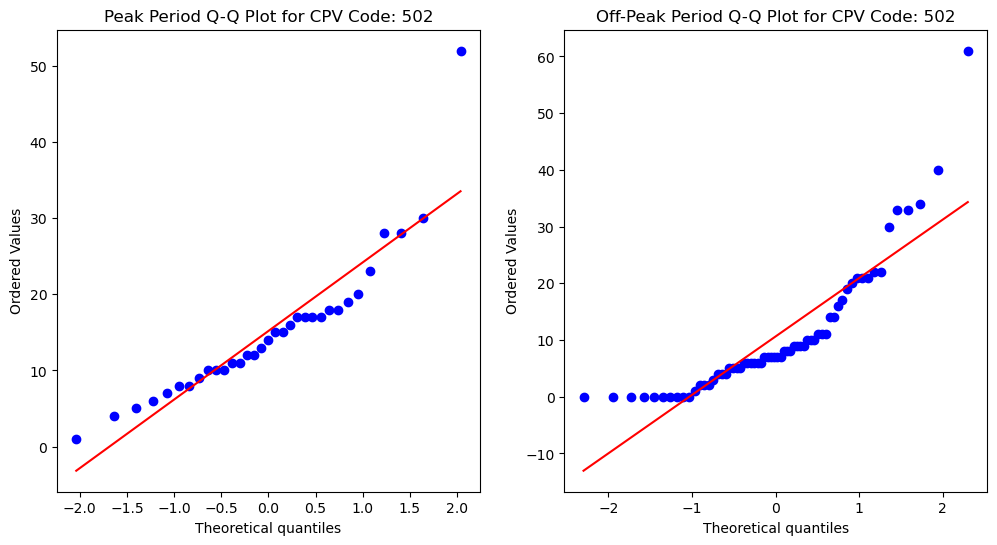

Shapiro-Wilk Test Peak for CPV Code 502: Statistic=0.8531885743141174, p-value=0.0004004414367955178
Shapiro-Wilk Test Off-Peak for CPV Code 502: Statistic=0.7925244569778442, p-value=4.302266631839302e-08
Levene's Test for CPV Code 502: Statistic=0.22119644112136866, p-value=0.6392077601216801
Mann-Whitney U Test for CPV Code 502: Statistic=1471.5, p-value=0.0015531122621243794


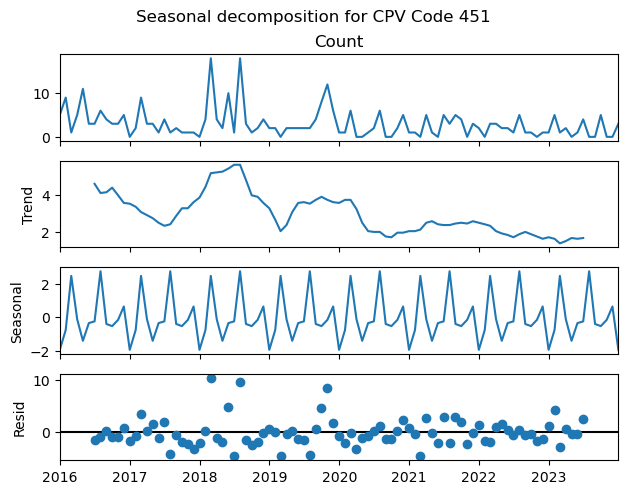

Seasonal Strength: 0.1566
F-test result: F-value = 73.7573, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


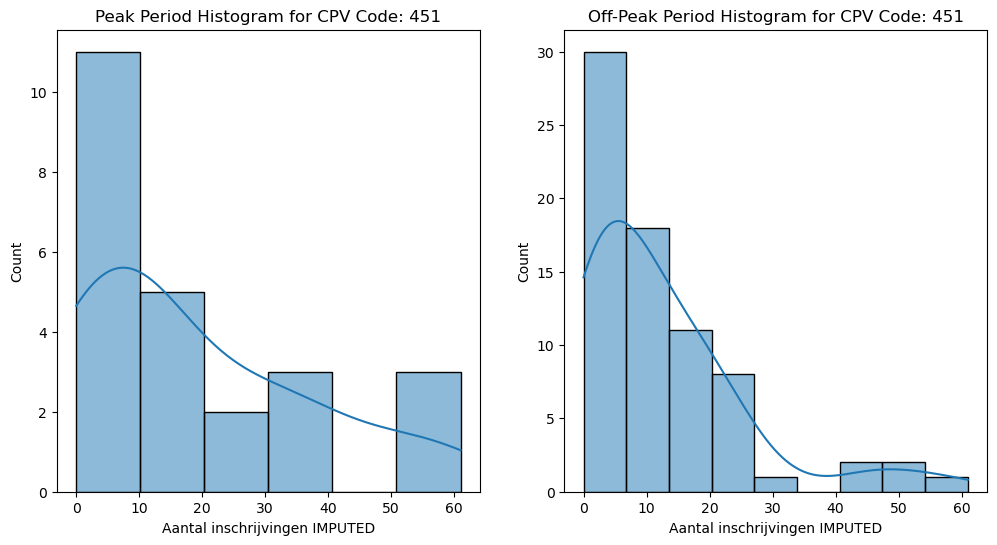

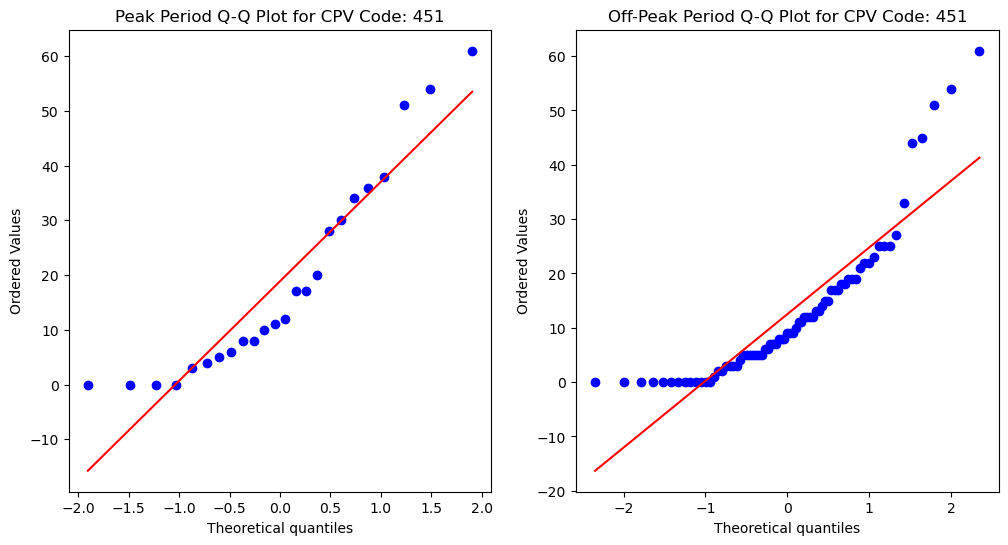

Shapiro-Wilk Test Peak for CPV Code 451: Statistic=0.8759428262710571, p-value=0.006892825476825237
Shapiro-Wilk Test Off-Peak for CPV Code 451: Statistic=0.8141838312149048, p-value=3.595532049871508e-08
Levene's Test for CPV Code 451: Statistic=3.7030069749337216, p-value=0.05730715800368981
Mann-Whitney U Test for CPV Code 451: Statistic=1028.0, p-value=0.20380137625620665


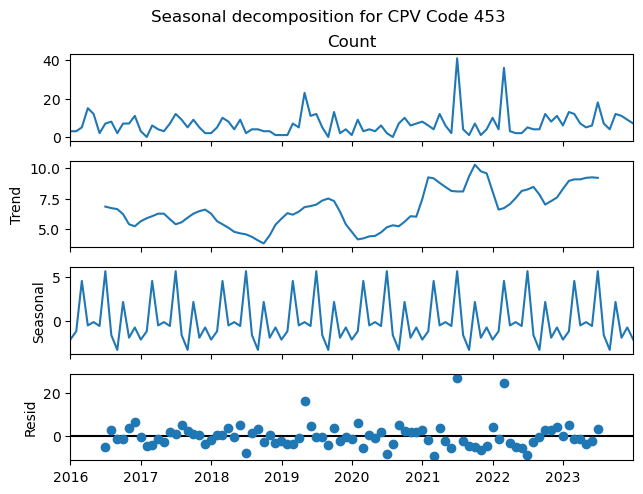

Seasonal Strength: 0.1759
F-test result: F-value = 88.2800, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


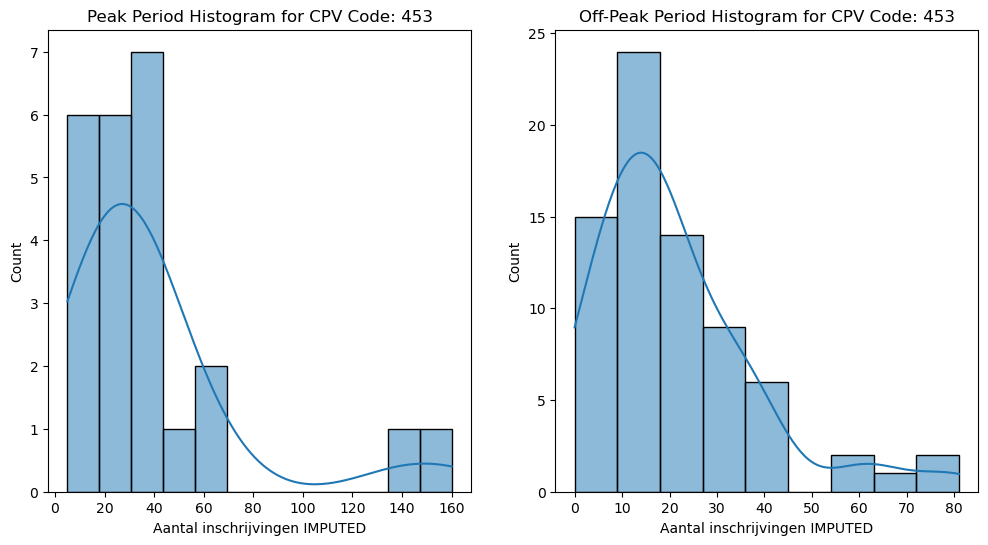

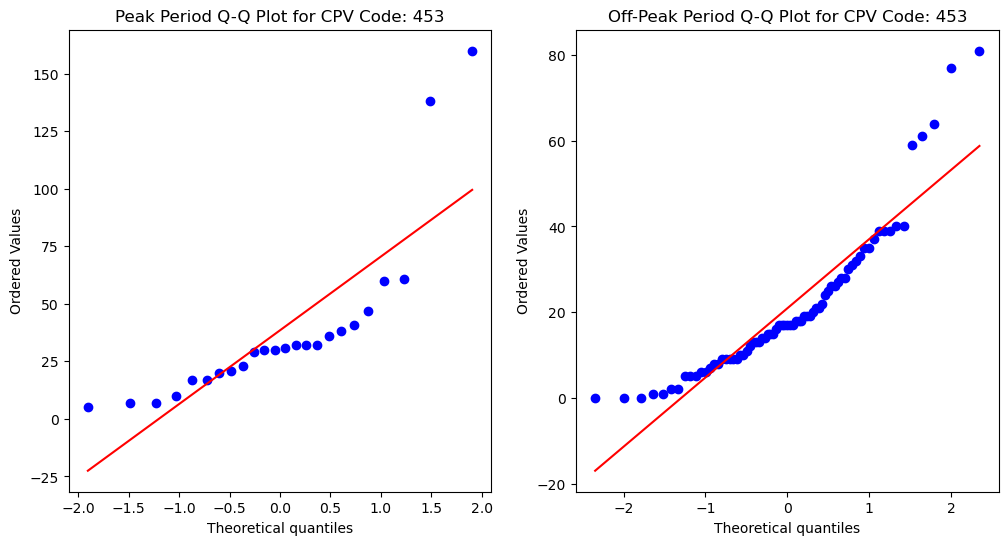

Shapiro-Wilk Test Peak for CPV Code 453: Statistic=0.6926200985908508, p-value=8.058485946094152e-06
Shapiro-Wilk Test Off-Peak for CPV Code 453: Statistic=0.8637962341308594, p-value=1.243039491782838e-06
Levene's Test for CPV Code 453: Statistic=3.686076066301534, p-value=0.05786863509858049
Mann-Whitney U Test for CPV Code 453: Statistic=1215.5, p-value=0.0045724094957285836


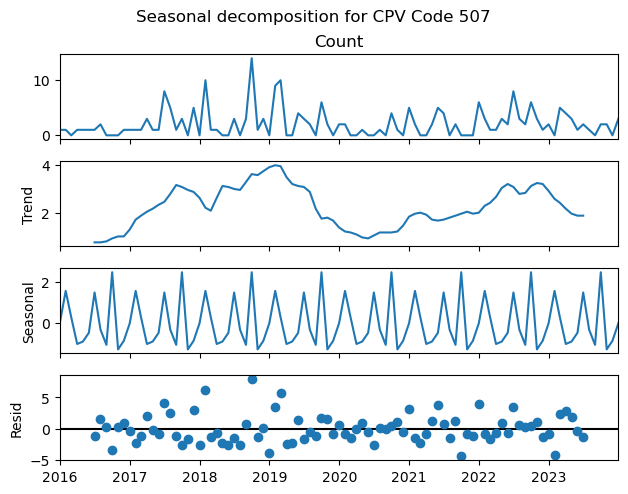

Seasonal Strength: 0.2018
F-test result: F-value = 58.8551, p-value = 0.0000
The seasonal component is statistically significant.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


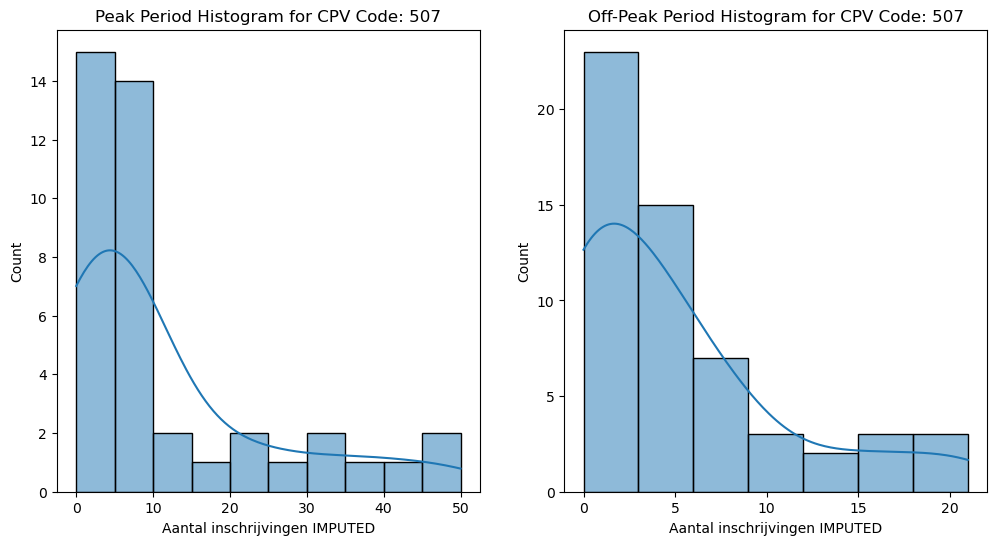

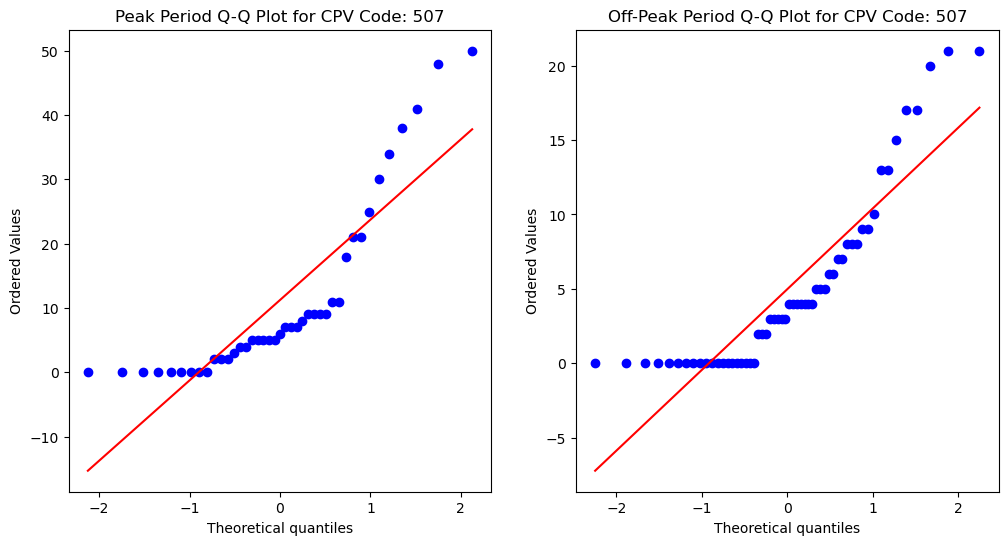

Shapiro-Wilk Test Peak for CPV Code 507: Statistic=0.7660492062568665, p-value=1.1331271707604174e-06
Shapiro-Wilk Test Off-Peak for CPV Code 507: Statistic=0.8056772351264954, p-value=3.854419219351257e-07
Levene's Test for CPV Code 507: Statistic=8.132477240967402, p-value=0.005334563858073823
Mann-Whitney U Test for CPV Code 507: Statistic=1466.0, p-value=0.018619513772066373
Report on the statistical difference and seasonality for CPV Code: 502

Seasonal Strength: 0.1179
ANOVA F-test result: F-value = 180.3696, p-value = 0.0000

Shapiro-Wilk Test Peak: Statistic=0.8531885743141174, p-value=0.0004004414367955178
Shapiro-Wilk Test Off-Peak: Statistic=0.7925244569778442, p-value=4.302266631839302e-08

Levene's Test: Statistic=0.22119644112136866, p-value=0.6392077601216801

Mann-Whitney U Test: Statistic=1471.5, p-value=0.0015531122621243794, Bonferroni corrected p-value=0.006212449048497518

Conclusion:
The value of 'Aantal inschrijvingen IMPUTED' is statistically significantly diffe

In [ ]:
reports = analyze_and_generate_report(df_highrisk)
for report in reports:
    print(report)